# Analyze experimentally tested designs

## Import `Python` modules

In [1]:
# Import `Python` modules
import os
import shutil
import sys
sys.path.append('scripts/')
import scoring_utils

import glob
import random
import doctest
import time
import pandas
import subprocess
import Bio.PDB
from Bio.Data import CodonTable
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
import re
import math
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2, style='ticks', palette='colorblind')
from IPython.display import display

import pyrosetta
import pyrosetta.rosetta
pyrosetta.init('-beta_nov16 -corrections:beta_nov16 -mute all -mute core -mute protocols')

import sys
sys.path.append('scripts/')
import design_utils

# Initialize directories
resultsdir = 'results/'
if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)

## Forward fold designs with PDBs as inputs

First, forward fold designs from input PDBs, so that Rosetta can quantify RMSD to the native structure.

In [2]:
# Define input PDBs
pdb_dir = \
    '/home/haddox/2018/SD2_data_for_ML/Rocklin_2017_Science/pdb_files/'
pdb_names = [
    'HHH_rd4_0284', 'HHH_rd4_0626', 'HHH_rd4_0636',
    'EEHEE_rd3_1267', 'EEHEE_rd4_0215', 'EEHEE_rd4_0464',
    'EHEE_rd4_0144', 'EHEE_rd4_0152', 'EHEE_rd4_0570',
    'EHEE_rd4_0810','HHH_rd1_0192', 'HHH_rd1_0501',
    'HHH_rd1_0649', 'HHH_rd1_0972', 'HHH_rd2_0120',
    'HHH_rd2_0184', 'HHH_rd4_0068', 'HHH_rd4_0216',
    'HHH_rd4_0628', 'HHH_rd4_0821', 'HHH_rd4_0838',
    'HHH_rd4_0998'
]
pdb_paths = [
    os.path.join(pdb_dir, '{0}.pdb'.format(pdb_name))
    for pdb_name in pdb_names
]

# Forward fold from input PDB file
forward_folding_dir = \
    'results/forward_folding_with_pdb/'
if not os.path.isdir(forward_folding_dir):
    os.makedirs(forward_folding_dir)
boinc_id_prefix = 'HH_2019_'
design_utils.forward_fold_designs_on_boinc(
    pdb_paths,
    forward_folding_dir,
    boinc_id_prefix=boinc_id_prefix,
    run_jobs=True
)

Copy forward-folding results

In [3]:
# Copy results from the `bionc` results directory on the digs
if False:
    overwrite = True
    run_prefix = 'HH_2019_'
    boinc_results_dir = '/projects/boinc-results/'
    forward_folding_dir = \
        'results/forward_folding_with_pdb/'
    pdb_names = [
        'HHH_rd4_0284', 'HHH_rd4_0626', 'HHH_rd4_0636',
        'EEHEE_rd3_1267', 'EEHEE_rd4_0215', 'EEHEE_rd4_0464',
        'EHEE_rd4_0144', 'EHEE_rd4_0152', 'EHEE_rd4_0570',
        'EHEE_rd4_0810','HHH_rd1_0192', 'HHH_rd1_0501',
        'HHH_rd1_0649', 'HHH_rd1_0972', 'HHH_rd2_0120',
        'HHH_rd2_0184', 'HHH_rd4_0068', 'HHH_rd4_0216',
        'HHH_rd4_0628', 'HHH_rd4_0821', 'HHH_rd4_0838',
        'HHH_rd4_0998'
    ]
    for pdb_name in pdb_names:
        run_name = run_prefix + pdb_name #+ '_fragments'
        new_results_dir = os.path.join(
            forward_folding_dir,
            pdb_name + '_fragments'
        )
        assert os.path.isdir(new_results_dir)
        print(run_name)
        if True:
            design_utils.copy_boinc_results(
                run_name, boinc_results_dir, new_results_dir,
                verbose=False, overwrite=overwrite,
                file_suffix='.sc.bz2',
                file_suffixes_to_ignore=['.all.out.bz2']
            )

Read in forward-folding results

In [4]:
dfs = []
max_datapoints = 10000
if max_datapoints:
    print("Reading in data, stopping at a maximum of {0} datapoints per protein".format(max_datapoints))
forward_folding_dir = \
    'results/forward_folding_with_pdb/'
#pdb_names = ['HHH_rd4_0284', 'HHH_rd4_0626', 'HHH_rd4_0636']
for pdb_name in pdb_names:
    for protocol in ['fold', 'relax']:
        ff_results_dir = os.path.join(
            forward_folding_dir,
            pdb_name + '_fragments'
        )
        file = glob.glob(os.path.join(
            ff_results_dir,
            '*_{0}_*.sc.bz2'.format(protocol)
        ))
        if not file:
            continue
        assert len(file) == 1
        file = file[0]
        df = design_utils.parse_boinc_silent_scores_file(
            file,
            max_datapoints=max_datapoints
        )
        df['pdb'] = pdb_name
        df['protocol'] = protocol
        dfs.append(df)

ff_df = pandas.concat(dfs)
pdbs_with_ff_data = list(set(ff_df['pdb']))
print("Read in data for {0} proteins".format(len(pdbs_with_ff_data)))

Reading in data, stopping at a maximum of 10000 datapoints per protein
Read in data for 22 proteins


Plot forward-folding results

In [5]:
def make_ff_plots(pdbs_to_plot, ff_df, plot_bins=False):
    """
    Make forward-folding plots for an input list of PDBs
    """
    ncols = 2
    nrows = math.ceil(len(pdbs_to_plot) / ncols)
    fig = plt.figure(figsize=[15,5*nrows])
    xlim = (-0.5, ff_df['rms'].max()+0.5)
    ylim = (ff_df['score'].min()-2, ff_df['score'].max()+2)
    for (i, pdb) in enumerate(pdbs_to_plot, 1):

        # Define the axis and get the relevant data
        ax = fig.add_subplot(nrows, ncols, i)
        data_to_plot = ff_df[(ff_df['pdb'] == pdb)]

        # Plot the score vs. rms in different colors for the abinitio
        # data and relax data
        if False:
            data = data_to_plot[data_to_plot['protocol']=='fold']
            ax.hexbin(x=data['rms'], y=data['score'])
            data = data_to_plot[data_to_plot['protocol']=='relax']
            ax.hexbin(x=data['rms'], y=data['score'])
        if True:
            sns.regplot(
                x="rms", y="score",
                data=data_to_plot[data_to_plot['protocol']=='fold'], 
                fit_reg=False, color='steelblue',
                scatter_kws={'alpha':0.3}, ax=ax
            )
            sns.regplot(
                x="rms", y="score",
                data=data_to_plot[data_to_plot['protocol']=='relax'],
                fit_reg=False, color='firebrick',
                scatter_kws={'alpha':0.3}, ax=ax
            )
            sns.regplot(
                x="rms", y="score",
                data=data_to_plot[data_to_plot['protocol']=='abinitio'],
                fit_reg=False, color='0.25',
                scatter_kws={'alpha':0.3}, ax=ax
            )
        if plot_bins:
            bin_mins = np.arange(0.5, 2.5, 0.5)
            for bin_min in bin_mins:
                ax.plot([bin_min, bin_min], ylim, c='0.5', ls='--')
        ax.set_title(pdb)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if i%2 == 0:
            ax.set(ylabel='')

    sns.despine()
    plt.tight_layout()
    plt.show()

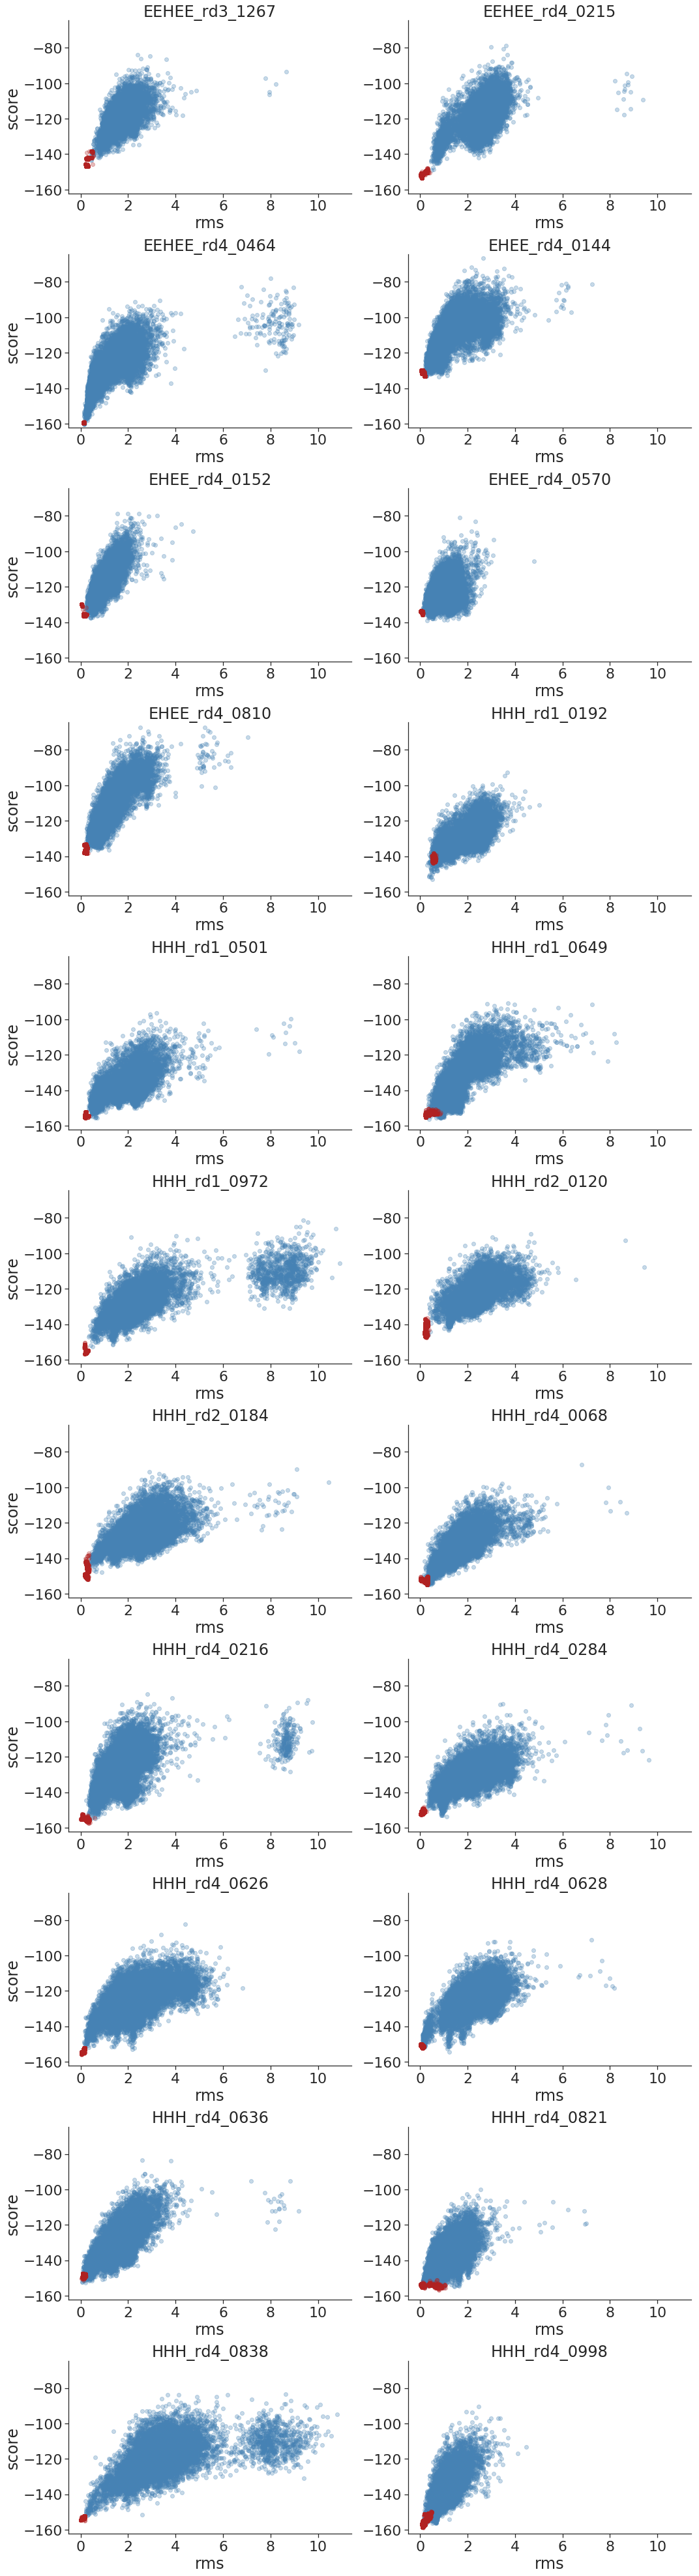

In [6]:
#pdb_names = ['HHH_rd4_0284', 'HHH_rd4_0626', 'HHH_rd4_0636']
make_ff_plots(sorted(pdb_names), ff_df)

**Observations**:

* I/V/M -> A/G/V designs
    * alternate minima: HHH_rd4_0284 (and 0626), HHH_rd4_0628
    * look pretty good: HHH_rd4_0636
    * look good: EEHEE_rd4_0215, HHH_rd4_0068, HHH_rd4_0216
    
* A few of the helical designs that didn't rescue have plots that indicate problems with the designs:
    * 0821 has many alternate conformations
    * 0120 funnels but at a high energy

Extract the best-scoring PDB files from forward-folding results

In [7]:
if False:
    forward_folding_dir = \
        'results/forward_folding_with_pdb/'
    pdb = 'HHH_rd4_0284'

    # Get data for PDB of interest and sort by score
    print("\n#--------------------------")
    print(pdb)
    data = ff_df[ff_df['pdb'] == pdb].copy()
    print("Number trajectories: {0}".format(len(data)))
    data.sort_values('score', ascending=True, inplace=True)
    display(data.head())

    # Extract PDB with best score
    ff_results_dir = os.path.join(
        forward_folding_dir,
        pdb + '_fragments'
    )
    tags = [list(data['description'])[0]]
    print("Extracting the PDBs for: {0}".format(' '.join(tags)))
    silent_file = glob.glob(os.path.join(
        ff_results_dir, '*fold*.out*bz2'
    ))
    assert len(silent_file) == 1
    silent_file = os.path.basename(silent_file[0])
    print(silent_file)
    design_utils.extract_pdb_from_boinc_output(
        ff_results_dir, silent_file, tags
    )
    # Sleep for a bit to give time for the PDB to appear for
    # copying
    time.sleep(5)

## Next, fold designs and mutant variants from their amino-acid sequences

Forward fold proteins from their amino-acid sequences

In [8]:
# Define the path to a script for forward folding
cwd = os.getcwd()
setup_boinc_alone_script = os.path.join(
    cwd, 'scripts/setup_boinc_alone.rb'
)

# Define a list of designs for forward folding
pdb_dir = \
    '/home/haddox/2018/SD2_data_for_ML/Rocklin_2017_Science/pdb_files'
pdb_names = [
    'HHH_rd4_0284', 'HHH_rd4_0626', 'HHH_rd4_0636',
    'HHH_rd4_0628', 'HHH_rd2_0184', 'HHH_rd4_0216',
    'HHH_rd4_0998', 'HHH_rd4_0068', 'HHH_rd4_0838',
    'EEHEE_rd4_0215'
]

# Define which mutants to test for each protein
mutations_dict = {
    'HHH_rd4_0284' : [
        ('S', 2, 'W'),
        ('K' , 6, 'L'), ('K' , 6, 'I'), ('K' , 6, 'W'),
        ('R' , 7, 'A'),
        ('E', 8, 'W'), ('E', 8, 'L'),
        ('A', 9, 'I'), ('A', 9, 'L'),
        ('V', 21, 'A'), ('V', 21, 'G')
    ],
    'HHH_rd4_0636' : [
        ('K', 6, 'L'), ('K', 6, 'M'), ('K', 6, 'F'),
        ('V', 12, 'A'), ('V', 12, 'L'), ('V', 12, 'M'), ('V', 12, 'W'),
        ('V', 12, 'Y'),
        ('E', 18, 'Y')
    ],
    'HHH_rd4_0628' : [
        ('K', 2, 'E'),
        ('K', 6, 'L'), ('K', 6, 'V'), ('K', 6, 'W'), ('K', 6, 'F'),
        ('K', 6, 'M'),
        ('R', 8, 'W'), ('R', 8, 'L'),
        ('A', 9, 'L'), ('A', 9, 'V'), ('A', 9, 'I'), ('A', 9, 'M'),
        ('E', 18, 'M'), ('E', 18, 'L'), ('E', 18, 'I'), ('E', 18, 'V'),
        ('E', 18, 'F'), ('E', 18, 'Y'), ('E', 18, 'W'),
        ('V', 21, 'A'), ('V', 21, 'G'),
        ('V', 30, 'F'), ('V', 30, 'Y')
    ],
    'HHH_rd2_0184' : [
        ('A', 25, 'L')
    ],
    'HHH_rd4_0216' : [
        ('R', 3, 'L'),
        ('A', 4, 'L'), ('A', 4, 'I'), ('A', 4, 'V'),
        ('K', 8, 'L'), ('K', 8, 'M'), ('K', 8, 'V'), ('K', 8, 'I'),
        ('V', 11, 'A'), ('V', 11, 'G'),
        ('I', 21, 'A'), ('I', 21, 'G'),
        ('L', 39, 'E'),
        
        ('E', 5, 'L'), ('E', 5, 'I'),
        ('R', 9, 'L'), ('R', 9, 'I'),
        ('E', 12, 'L'), ('E', 12, 'I'),
        ('R', 13, 'L'), ('R', 13, 'I'),
        ('R', 33, 'L'), ('R', 33, 'I'),
        ('K', 37, 'L'), ('K', 37, 'I')
    ],
    'HHH_rd4_0998' : [
        ('K', 3, 'W'), ('K', 3, 'W'),
        ('V', 11, 'A'), ('V', 11, 'F'),
        ('R', 14, 'L'), ('R', 14, 'M'), ('R', 14, 'W'),
        ('D', 18, 'W'),
        ('E', 24, 'W'), ('E', 24, 'Y'), ('E', 24, 'F'),
        ('V', 30, 'W'), ('V', 30, 'Y'), ('V', 30, 'F'), ('V', 30, 'L'),
        ('K', 39, 'I'), ('K', 39, 'L')
    ],
    'HHH_rd4_0068' : [
        ('E', 18, 'M'), ('E', 18, 'L'), ('E', 18, 'I'), ('E', 18, 'V'),
        ('E', 18, 'F'), ('E', 18, 'Y'), ('E', 18, 'W'),
        ('V', 21, 'A'), ('V', 21, 'G'),
        ('V', 30, 'W'), ('V', 30, 'Y'), ('V', 30, 'F'), ('V', 30, 'L'),
        ('V', 42, 'W'), ('V', 42, 'Y'), ('V', 42, 'F'), ('V', 42, 'L')
    ],
    'HHH_rd4_0838' : [
        ('K', 6, 'I'), ('K', 6, 'L'), ('K', 6, 'M'), ('K', 6, 'V'),
        ('K', 6, 'W'), ('K', 6, 'F'),
        ('E', 18, 'L'), ('E', 18, 'V'), ('E', 18, 'L'), ('E', 18, 'F')
    ],
    'EEHEE_rd4_0215' : [
        ('M', 3, 'V'),
        ('A', 18, 'M'),
        ('Y', 29, 'W')
    ]
}

# Define energy functions
e_function_dict = {
    'beta_nov16' : {
        'weights_file' : 'beta_nov16',
        'cart_weights_file' : 'beta_nov16_cart',
        'flags_file' : None, 
        'extra_args' : [
            '-beta_nov16',
            '-corrections:beta_nov16'
        ]
    },
    'beta16.nostab-refit' : {
        'weights_file' : \
            'scripts/weights_and_flags/beta16.nostab-refit.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/beta16.nostab-refit_cart.wts',
        'flags_file' : None, 
        'extra_args' : [
            '-beta_nov16',
            '-corrections:beta_nov16'
        ]
    },
    'HH_run15_step458' : {
        'weights_file' : \
            'scripts/weights_and_flags/HH_run15_weights_458.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run15_weights_458_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/HH_run15_flags_458', 
        'extra_args' : []
    },
    'HH_run17_step403' : {
        'weights_file' : \
            'scripts/weights_and_flags/HH_run17_weights_403.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run17_weights_403_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/HH_run17_flags_403', 
        'extra_args' : []
    },
    'HH_run17D_step36' : {
        'weights_file' : \
            'scripts/weights_and_flags/HH_run17D_weights_36.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run17D_weights_36_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/HH_run17D_flags_36', 
        'extra_args' : []
    }
}

In [9]:
mutations_dict = {
    'HHH_rd4_0284' : [
        ('K' , 6, 'L'), ('K' , 6, 'I'), ('K' , 6, 'W'),
        ('R' , 7, 'A'),
        ('E', 8, 'W'), ('E', 8, 'L')
    ],
    'HHH_rd4_0636' : [
        ('K', 6, 'L'), ('K', 6, 'M'), ('K', 6, 'F'),
        ('E', 18, 'Y')
    ],
    'HHH_rd4_0628' : [
        ('K', 6, 'L'), ('K', 6, 'W'),
        ('R', 8, 'W'), ('R', 8, 'L'),
        ('E', 18, 'M'), ('E', 18, 'L'), ('E', 18, 'I'), ('E', 18, 'V'),
        ('E', 18, 'F'), ('E', 18, 'Y'), ('E', 18, 'W')
    ],
    'HHH_rd4_0216' : [
        ('K', 8, 'L'), ('K', 8, 'M'), ('K', 8, 'I')
    ],
    'HHH_rd4_0998' : [
        ('K', 3, 'W'), ('K', 3, 'W'),
        ('R', 14, 'L'), ('R', 14, 'M'), ('R', 14, 'W'),
        ('D', 18, 'W'),
        ('E', 24, 'W'), ('E', 24, 'Y'), ('E', 24, 'F'),
        ('K', 39, 'I'), ('K', 39, 'L')
    ],
    'HHH_rd4_0068' : [
        ('E', 18, 'M'), ('E', 18, 'L'), ('E', 18, 'I'), ('E', 18, 'V'),
        ('E', 18, 'F'), ('E', 18, 'Y'), ('E', 18, 'W')
    ],
    'HHH_rd4_0838' : [
        ('K', 6, 'I'), ('K', 6, 'L'), ('K', 6, 'M'),
        ('K', 6, 'W'), ('K', 6, 'F'),
        ('E', 18, 'L'), ('E', 18, 'L')
    ]
}

Forward fold sequences using a given energy function

In [10]:
# Forward fold each design and each mutant variant
dfs = []
for pdb_name in pdb_names:
    
    if pdb_name not in mutations_dict:
        continue

    # Make a list of sequences to forward fold
    seqs_for_ff = {
        key : []
        for key in ['seq_name', 'seq']
    }
    pose = pyrosetta.pose_from_pdb(
        os.path.join(pdb_dir, '{0}.pdb'.format(pdb_name))
    )
    seq = pose.sequence()

    # ... first adding the wildtype sequence
    seqs_for_ff['seq_name'].append('{0}_wt'.format(pdb_name))
    seqs_for_ff['seq'].append(seq)

    # ... then adding mutant sequences
    if pdb_name in mutations_dict:
        for (wt_aa, site_n, mut_aa) in mutations_dict[pdb_name]:
            mut_seq = design_utils.mutate_protein_sequence(
                seq, site_n, wt_aa, mut_aa
            )
            seqs_for_ff['seq_name'].append(
                '{0}_{1}{2}{3}'.format(pdb_name, wt_aa, site_n, mut_aa)
            )
            seqs_for_ff['seq'].append(mut_seq)
    seqs_for_ff_df = pandas.DataFrame(seqs_for_ff)
    dfs.append(seqs_for_ff_df)
    
    # Fold each sequence in the above dataframe
    e_function = 'beta16.nostab-refit' # 'HH_run17_step403' #  'HH_run17D_step36'  # 
    for (i, row) in seqs_for_ff_df.iterrows():

        # Define an output directory for storing results.
        # Do not forward fold sequences if this directory already
        # exists
        seq = row['seq']
        seq_name = row['seq_name']
        forward_folding_dir = os.path.join(
            resultsdir,
            'forward_folding_from_seq/',
            e_function,
            f'{seq_name}/'
        )
        
        # Make a FASTA file for use as input for forward folding
        fasta_dir = os.path.join(forward_folding_dir, 'fasta/')
        if not os.path.isdir(fasta_dir):
            os.makedirs(fasta_dir)
        fasta_file = os.path.join(
            fasta_dir, '{0}.fasta'.format(seq_name)
        )
        if not os.path.isfile(fasta_file):
            with open(fasta_file, 'w') as f:
                f.write('>{0}\n'.format(seq_name))
                f.write('{0}\n'.format(seq))
  
        # Make fragments and input files for forward folding
        # on boinc, but don't submit until I edit submission
        # files below
        fragments_dir = os.path.join(
            forward_folding_dir,
            f'{seq_name}_fragments'
        )
        boinc_id_prefix = 'hugh2020'
        if not os.path.isdir(fragments_dir):
            design_utils.forward_fold_designs_from_sequence_on_boinc(
                fastas_folder=fasta_dir,
                forward_folding_dir=forward_folding_dir,
                setup_boinc_alone_script=setup_boinc_alone_script,
                boinc_id_prefix=boinc_id_prefix,
                run_jobs=False
            )
        else:
            continue
        
        # Change the name of the input file to include the name of
        # the energy function
        print("Editing files")
        time.sleep(10)
        fold_data_f = glob.glob(os.path.join(
            fragments_dir,
            f'*{seq_name}_fragments_fold_data.zip'
        ))
        assert len(fold_data_f) == 1
        fold_data_f = fold_data_f[0]
        new_fold_data_f = fold_data_f.replace(
            '_fragments_fold_data.zip',
            f'__{e_function}_fragments_fold_data.zip'
        )
        if not os.path.isfile(new_fold_data_f):
            shutil.copy(fold_data_f, new_fold_data_f)
        fold_data_f_basename = os.path.basename(new_fold_data_f)

        # Copy the weights and flags file into the directory with
        # fragments
        weights_file = e_function_dict[e_function]['weights_file']
        new_weights_file = os.path.join(
            fragments_dir,
            '{0}_{1}__{2}'.format(
                boinc_id_prefix,
                seq_name,
                os.path.basename(weights_file)
            )
        )
        if not os.path.isfile(new_weights_file):
            shutil.copy(weights_file, new_weights_file)
        flags_file = e_function_dict[e_function]['flags_file']
        new_flags_file = None
        if flags_file:
            new_flags_file = os.path.join(
                fragments_dir,
                '{0}_{1}__{2}'.format(
                    boinc_id_prefix,
                    seq_name,
                    os.path.basename(flags_file)
                )
            )
            if not os.path.isfile(new_flags_file):
                shutil.copy(flags_file, new_flags_file)

        # Edit the job submission file to change the name of the renamed
        # input file from above, to add the input flags and weights file,
        # and to add flags referencing the weights and flags files in the
        # arguments section
        e_function_args = '-score:weights {0}'.format(
            os.path.basename(new_weights_file)
        )
        if flags_file:
            e_function_args += f' @{os.path.basename(new_flags_file)}'
        addnl_args = e_function_dict[e_function]['extra_args']
        for arg in addnl_args:
            e_function_args += f' {arg}'
        job_file = os.path.join(
            fragments_dir,
            'run.fold.boinc.job'
        )
        new_job_file = job_file.replace(
            'run.fold.boinc.job',
            'new_run.fold.boinc.job'
        )
        if not os.path.isfile(new_job_file):
            with open(job_file) as f:
                lines = f.readlines()
            with open(new_job_file, 'w') as f:
                for line in lines:

                    # Change the name of the zip'd input file
                    line = line.replace(
                        '_fragments',
                        f'__{e_function}_fragments'
                    )

                    # Change the -beta flag to specify the weights and
                    # flags file of the given energy function
                    line = line.replace(
                        '-beta',
                        e_function_args
                    )
                    
                    # Add the weights and flags files as input files
                    if 'inputfiles' in line:
                        line = line.strip()
                        if flags_file:
                            line += ',{0},{1}\n'.format(
                                os.path.basename(new_weights_file),
                                os.path.basename(new_flags_file)
                            )
                        else:
                            line += ',{0}\n'.format(
                                os.path.basename(new_weights_file)
                            )
                    f.write(line)
        
        # Submit the job after sleeping for a bit to let files
        # appear
        time.sleep(30)
        files = [new_fold_data_f, new_job_file]
        for f in files:
            assert os.path.isfile(f)
        for f in [new_weights_file, new_flags_file]:
            if f:
                assert os.path.isfile(f)
        
        # Submit job to boinc
        submit_job_outfile = os.path.join(
            fragments_dir,
            'submit_job.out'
        )
        if not os.path.isfile(submit_job_outfile):
            print("Submitting job to boinc")
            cmd = \
                '/projects/boinc/bin/boinc_submit new_run.fold.boinc.job'
            process = subprocess.Popen(
                cmd, stdout=subprocess.PIPE, cwd=fragments_dir,
                shell=True
            )
            (out, err) = process.communicate()
            with open(submit_job_outfile, 'wb') as f:
                f.write(out)
            if err:
                print(err)
                raise ValueError('Error in submitting boinc job. The error message is:\n{0}'.format(err))
        
seqs_for_ff_df = pandas.concat(dfs)

Copy the results of forward folding

In [11]:
# Copy results from the `bionc` results directory on the digs
if True:
    overwrite = False
    boinc_results_dir = '/projects/boinc-results/'
    e_function = 'HH_run17_step403' # 'HH_run17D_step36' # 'beta16.nostab-refit' #
    for pdb_name in seqs_for_ff_df['seq_name']:

        # Directory in which to store the results
        new_results_dir = os.path.join(
            'results/forward_folding_from_seq/',
            e_function,
            pdb_name,
            pdb_name + '_fragments'
        )
        if not os.path.isdir(new_results_dir):
            continue
            
        # Don't copy the silent file from boinc if the `low_e_decoys/`
        # directory already exists, which means that all relevant
        # data has been extracted
        low_e_decoys_dir = os.path.join(
            new_results_dir,
            'low_e_decoys/'
        )
        if os.path.isdir(low_e_decoys_dir):
            continue

        # Get the batch_id for the boinc run
        job_f = os.path.join(new_results_dir, 'submit_job.out')
        with open(job_f) as f:
            lines = f.readlines()
        batch_id_pattern = r'submitted as batch (?P<batch_id>\d+)'
        batch_ids = []
        for line in lines:
            match = re.search(batch_id_pattern, line)
            if match:
                batch_ids.append(match.group('batch_id'))
        if len(batch_ids) == 0:
            print(f"Could not find batch_id for {pdb_name}")
            continue
        assert len(batch_ids) == 1, pdb_name
        batch_id = batch_ids[0]

        # Copy silent files with results if they don't already
        # exist
        silent_file = glob.glob(os.path.join(
            new_results_dir,
            '*_abinitio_*.out*'
        ))
        if (len(silent_file) == 0) or overwrite:
            print(pdb_name, batch_id)
            design_utils.copy_boinc_results2(
                batch_id, boinc_results_dir, new_results_dir,
                verbose=False, overwrite=overwrite,
                file_suffix='.out', #'.sc.bz2', # 
                file_suffixes_to_ignore=['.all.out.bz2']
            )

Could not find batch_id for HHH_rd4_0998_E24F


Read in data from the ab initio runs, extract the lowest-energy structure, and then compute the RMS of all structures relative to the lowest-scoring one.

In [12]:
# Define path to Rosetta scoring app
score_app_path = '/software/rosetta/versions/v2019.45-dev61026/bin/score.hdf5.linuxgccrelease'

# Read in data
e_function = 'beta16.nostab-refit' # 'HH_run17_step403' # 'HH_run17D_step36' #  
weights_file = e_function_dict[e_function]['weights_file']
flags_file = e_function_dict[e_function]['flags_file']
e_function_extra_args = e_function_dict[e_function]['extra_args']
for (i, row) in seqs_for_ff_df.iterrows():
    
    # Define the path to the directory with input files
    # and only run the below code if the sbatch file to
    # run it doesn't already exist
    pdb_name = row['seq_name']
    #if pdb_name  in ['HHH_rd4_0216_K8V', 'HHH_rd4_0998_K39I']:
    #    continue
    if pdb_name in ['HHH_rd4_0216_K8I']:
        continue
    
    ff_results_dir = os.path.join(
        'results/forward_folding_from_seq/',
        e_function,
        pdb_name,
        pdb_name + '_fragments/'
    )
    if not os.path.isdir(ff_results_dir):
        continue
    scores_file_prefix = os.path.join(
        ff_results_dir, 'rescore'
    )
    sbatch_file = f'{scores_file_prefix}.sbatch'
    if os.path.isfile(sbatch_file):
        continue
    
    # Get the data from ab initio folding
    print(pdb_name)
    silent_file = glob.glob(os.path.join(
        ff_results_dir,
        '*_abinitio_*.out*'
    ))
    if not silent_file:
        continue
    assert len(silent_file) == 1
    silent_file = silent_file[0]
    
    # Read in data, sort poses by score, and extract the
    # lowest-scoring PDB
    df = design_utils.parse_boinc_silent_scores_file(silent_file)
    df = df[df['description'].str.startswith('S_')]
    df.sort_values('score', ascending=True, inplace=True)
    lowest_scoring_pdb = list(df['description'])[0]
    tags = [lowest_scoring_pdb]
    design_utils.extract_pdb_from_boinc_output(
        ff_results_dir, os.path.basename(silent_file), tags
    )
    
    # Sleep for a bit to give time for the PDB to appear, then
    # copy it to a directory for eye testing
    time.sleep(30)
    pdbs = glob.glob(os.path.join(ff_results_dir, '*.pdb'))
    new_pdb_dir = os.path.join(
        resultsdir,
        'abinitio_minima',
        e_function,
        pdb_name
    )
    design_utils.copy_pdbs(pdbs=pdbs, new_pdb_dir=new_pdb_dir)

    # Rescore decoys and compute the RMS to the lowest-energy decoy
    extra_args = [
        '-in:file:silent_struct_type binary',
        '-silent_read_through_errors',
        '-in:file:native {0}'.format(os.path.join(
            ff_results_dir,
            f'{lowest_scoring_pdb}.pdb'
        ))
    ] + e_function_extra_args
    if not os.path.isfile(sbatch_file):
        silent_file = silent_file.replace('.bz2', '')
        assert os.path.isfile(silent_file), silent_file
        design_utils.compute_score_using_rosettascripts(
            score_app_path=score_app_path,
            weights_file=weights_file,
            output_dir=ff_results_dir,
            scores_file_prefix=scores_file_prefix,
            silent_file=silent_file,
            extra_args=extra_args,
            flags_file=flags_file,
            submit_sbatch_job=True,
            queue_type='medium',
            memory='8g'
        )

HHH_rd4_0998_K39I


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 1553: invalid start byte

For each sequence, read in forward-folding data with RMS values. Then, extract the low-energy structures across several different RMS bins of size 0.5 ranging from lower values of 0-1.5, as well as a bin that is all structures with RMS > 2. Finally, append the forward-folding data to a growing list and make a big dataframe at the end.

In [13]:
# Read in data
dfs = []
e_function = 'beta16.nostab-refit' # 'HH_run17_step403' # 'HH_run17D_step36' #  
for (i, row) in seqs_for_ff_df.iterrows():
    
    pdb_name = row['seq_name']
    if pdb_name not in ['HHH_rd4_0216_wt', 'HHH_rd4_0216_K8L']:
        continue
    
    # Define path to scores file
    ff_results_dir = os.path.join(
        'results/forward_folding_from_seq/',
        e_function,
        pdb_name,
        pdb_name + '_fragments/'
    )
    scores_file = os.path.join(ff_results_dir, 'rescore.sc')
    if not os.path.isfile(scores_file):
        print(f"Missing scores file {scores_file}")
        continue
        
    # Read in data, remove high-scoring outliers, and append
    # dataframe to growing list
    df = pandas.read_csv(
        scores_file, sep='\s+', error_bad_lines=False
    )
    for metric in ['score', 'rms']:
        df[metric] = pandas.to_numeric(df[metric], errors='coerce')
        df.dropna(subset=[metric], inplace=True)
    df = df[df['score'] < (df['score'].min() + 100)]
    df['pdb'] = pdb_name
    df['protocol'] = 'abinitio'
    df['tag'] = df['description'].apply(
        lambda x: os.path.basename(x)[:-5]
    )
    dfs.append(df)
    print(pdb_name, len(df))
        
    # Find low-energy structures across multiple bins
    df.sort_values('score', ascending=True, inplace=True)
    bin_size = 0.5
    bin_mins = np.arange(0, 2.0, bin_size)
    n_structures_per_bin = 20
    low_e_structures = []
    for bin_min in bin_mins:
        bin_max = bin_min + bin_size
        data_i = df[df['rms'].between(bin_min, bin_max)]
        structures = list(data_i['tag'][:n_structures_per_bin])
        low_e_structures.extend(structures)
    data_i = df[df['rms'].between(2.0, 100)]
    structures = list(data_i['tag'][:n_structures_per_bin])
    low_e_structures.extend(structures)

    # Extract the low-energy structures from above
    if False:
        silent_file = glob.glob(os.path.join(
            ff_results_dir,
            '*_abinitio_*.out'
        ))
        assert len(silent_file) == 1
        silent_file = silent_file[0]
        output_dir = os.path.join(ff_results_dir, 'low_e_decoys/')
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
            design_utils.extract_pdb_from_boinc_output(
                working_dir=ff_results_dir,
                silent_file_basename=os.path.basename(silent_file),
                tags=low_e_structures,
                output_dir='low_e_decoys/'
            )
        print(len(glob.glob(os.path.join(output_dir, '*.pdb'))))
    
ff_df = pandas.concat(dfs, sort=False)

HHH_rd4_0216_wt 173337
HHH_rd4_0216_K8L 202548


Show forward-folding data for a specific set of sequences

In [14]:
def make_ff_plots(pdbs_to_plot, ff_df, plot_bins=False):
    """
    Make forward-folding plots for an input list of PDBs
    """
    ncols = 2
    nrows = math.ceil(len(pdbs_to_plot) / ncols)
    fig = plt.figure(figsize=[15,5*nrows])
    xlim = (-0.5, ff_df['rms'].max()+0.5)
    ylim = (ff_df['score'].min()-2, ff_df['score'].max()+2)
    for (i, pdb) in enumerate(pdbs_to_plot, 1):

        # Define the axis and get the relevant data
        ax = fig.add_subplot(nrows, ncols, i)
        data_to_plot = ff_df[(ff_df['pdb'] == pdb)]

        # Plot the score vs. rms in different colors for the abinitio
        # data and relax data
        if False:
            data = data_to_plot[data_to_plot['protocol']=='fold']
            ax.hexbin(x=data['rms'], y=data['score'])
            data = data_to_plot[data_to_plot['protocol']=='relax']
            ax.hexbin(x=data['rms'], y=data['score'])
        if True:
            sns.regplot(
                x="rms", y="score",
                data=data_to_plot[data_to_plot['protocol']=='fold'], 
                fit_reg=False, color='steelblue',
                scatter_kws={'alpha':0.3}, ax=ax
            )
            sns.regplot(
                x="rms", y="score",
                data=data_to_plot[data_to_plot['protocol']=='relax'],
                fit_reg=False, color='firebrick',
                scatter_kws={'alpha':0.3}, ax=ax
            )
            sns.regplot(
                x="rms", y="score",
                data=data_to_plot[data_to_plot['protocol']=='abinitio'],
                fit_reg=False, color='0.25',
                scatter_kws={'alpha':0.3}, ax=ax
            )
        if plot_bins:
            bin_mins = np.arange(0.5, 2.5, 0.5)
            for bin_min in bin_mins:
                ax.plot([bin_min, bin_min], ylim, c='firebrick', ls='--')
        ax.set_title(pdb)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if i%2 == 0:
            ax.set(ylabel='')

    sns.despine()
    plt.tight_layout()
    plt.show()

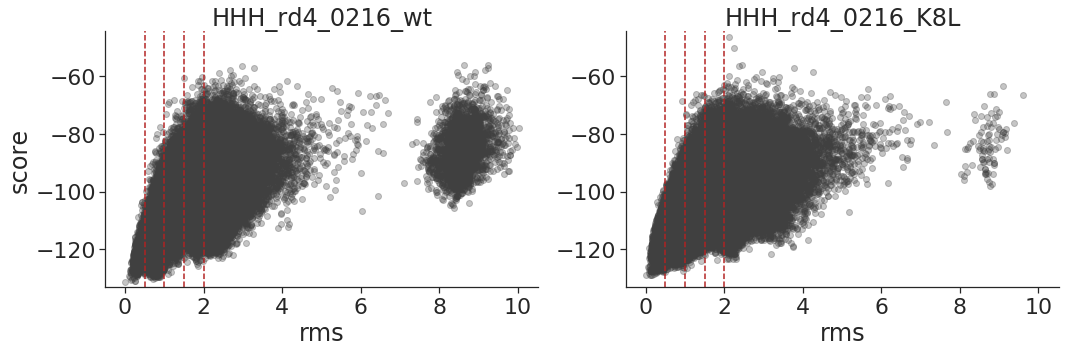

In [15]:
df = ff_df[ff_df['pdb'].str.contains('HHH_rd4_0216')]
pdbs = [
    'HHH_rd4_0216_wt', 'HHH_rd4_0216_K8L'
    #'HHH_rd4_0284_wt', 'HHH_rd4_0284_V21A', 'HHH_rd4_0284_K6L'
    #'HHH_rd4_0636_wt', 'HHH_rd4_0636_K6L'
]
#pdbs = sorted(list(set(df['pdb'])))
make_ff_plots(pdbs, df, plot_bins=True)

In [16]:
data = ff_df[ff_df['pdb'] == 'HHH_rd4_0284_wt'].copy()
print(len(data))
data.sort_values('score', ascending=True, inplace=True)
data[['score', 'rms', 'tag']].head(n=10)

0


,score,rms,tag


**Observations**:
* HHH_rd4_0628
    * V21A and K6L: differences at RMS 0-2 due to fraying of last first residues of the N-terminal helix

* kind of funneled
    * HHH_rd4_0284

* funneled landscapes:
    * EEHEE_rd4_0215

Now that I have scored and computed RMS values for all decoys and extracted PDBs for low-energy decoys, I will delete my copies of the boinc `.out` silent files since they take up a lot of space.

In [17]:
for (i, row) in seqs_for_ff_df.iterrows():    
    
    # Check if the `low_e_decoys/` directory exists. If so,
    # delete the silent file from boinc
    pdb_name = row['seq_name']
    ff_results_dir = os.path.join(
        'results/forward_folding_from_seq/',
        e_function,
        pdb_name,
        pdb_name + '_fragments/'
    )
    low_e_decoys_dir = os.path.join(ff_results_dir, 'low_e_decoys/')
    if os.path.isdir(low_e_decoys_dir):
        silent_files = glob.glob(os.path.join(
            ff_results_dir,
            '*_abinitio_*.out*'
        ))
        if len(silent_files) == 0:
            continue
        print(pdb_name)
        for file in silent_files:
            os.remove(file)

Relax low-energy structures

In [18]:
relax_space_dict = {
    'torsion' : False,
    'dualspace' : 'dualspace',
    'cartesian' : 'cartesian'
}

In [19]:
# Path to Rosetta relax app
relax_app_path = '/software/rosetta/versions/v2019.45-dev61026/bin/relax.hdf5.linuxgccrelease'

# Define input params for relax protocol
extra_args = [] # '-ex1', '-ex2', '-linmem_ig 10'
relax_space_name = 'torsion' # 'cartesian' #  'dualspace' #
relax_space = relax_space_dict[relax_space_name]

add_constraints = False
if add_constraints:
    relax_space_name = f'constrained_{relax_space_name}'
    extra_args += [
        '-constrain_relax_to_start_coords',
        '-relax:coord_constrain_sidechains'
    ]

e_function = 'HH_run17_step403'# 'HH_run17D_step36' # 'beta16.nostab-refit' #
if relax_space_name == 'torsion':
    weights_file = e_function_dict[e_function]['weights_file']
else:
    weights_file = e_function_dict[e_function]['cart_weights_file']
flags_file = e_function_dict[e_function]['flags_file']
extra_args += e_function_dict[e_function]['extra_args']

relax_script = 'MonomerDesign2019'

# Cycle through each sequence and relax each set of low-energy
# decoys for that sequence
for (i, row) in seqs_for_ff_df.iterrows():
    
    # Define path to directory with input PDBs
    pdb_name = row['seq_name']
    #if 'HHH_rd4_0628_K6L' not in pdb_name:
    #    continue
    decoys_dir = os.path.join(
        'results/forward_folding_from_seq/',
        e_function,
        pdb_name,
        pdb_name + '_fragments/',
        'low_e_decoys/'
    )

    # Make a list of PDBs to relax
    input_pdbs = glob.glob(os.path.join(decoys_dir, '*.pdb'))
    if len(input_pdbs) == 0:
        continue

    # Define the path to a directory for storing the results
    output_dir = os.path.join(
        decoys_dir,
        f'{relax_space_name}_relax',
        e_function,
        relax_script + '/'
    )
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    # Carry out the relax
    scores_file_prefix = os.path.join(output_dir, 'score')
    if not os.path.isfile(f'{scores_file_prefix}.sbatch'):
        print(pdb_name)
        design_utils.relax_design(
            relax_app_path=relax_app_path,
            input_pdbs=input_pdbs,
            weights_file=weights_file,
            results_dir=output_dir,
            scores_file_prefix=scores_file_prefix,
            relax_space=relax_space,
            relax_script=relax_script,
            extra_args=extra_args,
            flags_file=flags_file,
            submit_sbatch_job=True,
            queue_type='short',
            memory='2g'
        )

Score the relaxed low-energy structures from above

In [20]:
# Rosetta score app
score_app_path = '/software/rosetta/versions/v2019.45-dev61026/bin/score.hdf5.linuxgccrelease'

# Define relax params
relax_space_name = 'torsion' # 'cartesian' # 'dualspace' #
add_constraints = False
if add_constraints:
    relax_space_name = f'constrained_{relax_space_name}'
    
e_function = 'HH_run17_step403' # 'HH_run17D_step36' #'beta16.nostab-refit' #   
if relax_space_name == 'torsion':
    weights_file = e_function_dict[e_function]['weights_file']
else:
    weights_file = e_function_dict[e_function]['cart_weights_file']
flags_file = e_function_dict[e_function]['flags_file']
extra_args = e_function_dict[e_function]['extra_args']

relax_script = 'MonomerDesign2019'

# Cycle through each sequence and score the relaxed structures
# from above
for (i, row) in seqs_for_ff_df.iterrows():    
    pdb_name = row['seq_name']    
    pdb_dir = os.path.join(
        'results/forward_folding_from_seq/',
        e_function,
        pdb_name,
        pdb_name + '_fragments/',
        'low_e_decoys/',
        f'{relax_space_name}_relax',
        e_function,
        relax_script + '/'
    )
    if not os.path.isdir(pdb_dir):
        continue
    pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
    file_listing_pdbs = os.path.join(pdb_dir, 'pdbs_to_score.txt')
    scores_file_prefix = os.path.join(pdb_dir, 'score_app')
    if not os.path.isfile(file_listing_pdbs):
        print(pdb_name)
        with open(file_listing_pdbs, 'w') as f:
            for pdb in pdbs:
                f.write(f'{pdb}\n')
        design_utils.compute_score_using_rosettascripts(
            score_app_path=score_app_path,
            file_listing_pdbs=file_listing_pdbs,
            weights_file=weights_file,
            output_dir=pdb_dir,
            scores_file_prefix=scores_file_prefix,
            extra_args=extra_args,
            flags_file=flags_file,
            submit_sbatch_job=True,
            queue_type='short',
            memory='2g'
        )

Read in scores of the relaxed structures from above

In [24]:
dfs = []
for add_constraints in [True, False]:

    # Define params used in the relax step
    relax_space_name = 'cartesian' # 'torsion' # 'dualspace' #
    if add_constraints:
        relax_space_name = f'constrained_{relax_space_name}'
    e_function = 'HH_run17D_step36' # 'beta16.nostab-refit' #  #'HH_run15_step458' 
    relax_script = 'MonomerDesign2019'

    # Cycle through each sequence and read in scores of the relaxed
    # structures
    for (i, row) in seqs_for_ff_df.iterrows():    
        pdb_name = row['seq_name']
        print(pdb_name)
        pdb_dir = os.path.join(
            'results/forward_folding_from_seq/',
            e_function,
            pdb_name,
            pdb_name + '_fragments/',
            'low_e_decoys/',
            f'{relax_space_name}_relax',
            e_function,
            relax_script + '/'
        )
        scores_file = os.path.join(pdb_dir, 'score_app.sc')
        if not os.path.isfile(scores_file):
            continue
        df = pandas.read_csv(scores_file, sep='\s+')
        df['sequence_name'] = pdb_name
        df['e_function'] = e_function
        df['relax_space_name'] = relax_space_name
        df['relax_script'] = relax_script
        dfs.append(df)
ff_scores_df = pandas.concat(dfs, sort=False)
ff_scores_df['workflow'] = 'ff'

# Extract info on each sequence
parent_pattern = r'(?P<parent>\w+_rd\d_\d+)_'
ff_scores_df['parent'] = \
    ff_scores_df['sequence_name'].str.extract(parent_pattern)

mutation_pattern = r'\w+_rd\d_\d+_(?P<mutation>\D\d+\D)'
ff_scores_df['mutation'] = \
    ff_scores_df['sequence_name'].str.extract(mutation_pattern)

ff_scores_df['mutant_name'] = ff_scores_df.apply(
    lambda row: '{0}_{1}'.format(row['parent'], row['mutation']),
    axis=1
)

HHH_rd4_0284_wt
HHH_rd4_0284_V21A
HHH_rd4_0284_V21G
HHH_rd4_0284_K6L
HHH_rd4_0284_K6I
HHH_rd4_0284_K6W
HHH_rd4_0284_R7A
HHH_rd4_0284_E8W
HHH_rd4_0284_E8L
HHH_rd4_0626_wt
HHH_rd4_0636_wt
HHH_rd4_0636_V12A
HHH_rd4_0636_V12L
HHH_rd4_0636_V12M
HHH_rd4_0636_K6L
HHH_rd4_0636_K6M
HHH_rd4_0636_K6F
HHH_rd4_0636_E18Y
HHH_rd4_0628_wt
HHH_rd4_0628_V21A
HHH_rd4_0628_K6L
HHH_rd4_0628_K6W
HHH_rd4_0628_K6F
HHH_rd4_0628_K6M
HHH_rd4_0628_R8W
HHH_rd4_0628_R8L
HHH_rd4_0628_E18M
HHH_rd4_0628_E18L
HHH_rd4_0628_E18I
HHH_rd4_0628_E18V
HHH_rd4_0628_E18F
HHH_rd4_0628_E18Y
HHH_rd4_0628_E18W
HHH_rd2_0184_wt
HHH_rd4_0216_wt
HHH_rd4_0216_V11A
HHH_rd4_0216_V11G
HHH_rd4_0216_I21A
HHH_rd4_0216_I21G
HHH_rd4_0216_R3L
HHH_rd4_0216_K8L
HHH_rd4_0216_K8M
HHH_rd4_0216_K8V
HHH_rd4_0216_K8I
HHH_rd4_0998_wt
HHH_rd4_0998_K3W
HHH_rd4_0998_K3W
HHH_rd4_0998_R14L
HHH_rd4_0998_R14M
HHH_rd4_0998_R14W
HHH_rd4_0998_D18W
HHH_rd4_0998_E24W
HHH_rd4_0998_E24Y
HHH_rd4_0998_E24F
HHH_rd4_0998_K39I
HHH_rd4_0998_K39L
HHH_rd4_0068_wt
HHH_rd4_0068

In [25]:
ff_scores_df[
    ff_scores_df['sequence_name'].isin([
        'HHH_rd4_0216_wt', 'HHH_rd4_0216_I21A'
    ])
].sort_values('score', ascending=True)[[
    'sequence_name', 'score', 'relax_space_name',
    'mutation',
    'e_function'
]]

,sequence_name,score,relax_space_name,mutation,e_function
83,HHH_rd4_0216_wt,-204.897,cartesian,NaN,HH_run17D_step36
5,HHH_rd4_0216_wt,-203.474,cartesian,NaN,HH_run17D_step36
9,HHH_rd4_0216_wt,-203.239,cartesian,NaN,HH_run17D_step36
76,HHH_rd4_0216_wt,-203.239,cartesian,NaN,HH_run17D_step36
73,HHH_rd4_0216_wt,-203.225,cartesian,NaN,HH_run17D_step36
62,HHH_rd4_0216_wt,-203.203,cartesian,NaN,HH_run17D_step36
43,HHH_rd4_0216_wt,-203.157,cartesian,NaN,HH_run17D_step36
26,HHH_rd4_0216_wt,-202.930,cartesian,NaN,HH_run17D_step36
52,HHH_rd4_0216_wt,-202.896,cartesian,NaN,HH_run17D_step36
4,HHH_rd4_0216_wt,-202.806,cartesian,NaN,HH_run17D_step36


In [27]:
ff_scores_df['new_cart_bonded'] = ff_scores_df['cart_bonded'].apply(
    lambda x: x * (1.2/0.5)
)
ff_scores_df['new_score'] = ff_scores_df.apply(
    lambda row: \
        row['score'] - row['cart_bonded'] + row['new_cart_bonded'],
    axis=1
)
ff_scores_df[
    ff_scores_df['sequence_name'].isin([
        'HHH_rd4_0216_wt', 'HHH_rd4_0216_I21A'
    ])
].sort_values('new_score', ascending=True)[[
    'sequence_name', 'score', 'new_score', 'cart_bonded',
    'new_cart_bonded', 'relax_space_name',
    'mutation',
    'e_function'
]]

,sequence_name,score,new_score,cart_bonded,new_cart_bonded,relax_space_name,mutation,e_function
18,HHH_rd4_0216_I21A,-200.757,-173.6558,19.358,46.4592,constrained_cartesian,I21A,HH_run17D_step36
0,HHH_rd4_0216_I21A,-200.726,-173.5954,19.379,46.5096,constrained_cartesian,I21A,HH_run17D_step36
23,HHH_rd4_0216_I21A,-201.127,-173.4630,19.760,47.4240,constrained_cartesian,I21A,HH_run17D_step36
53,HHH_rd4_0216_I21A,-198.798,-173.3782,18.157,43.5768,constrained_cartesian,I21A,HH_run17D_step36
58,HHH_rd4_0216_I21A,-198.629,-173.0524,18.269,43.8456,cartesian,I21A,HH_run17D_step36
2,HHH_rd4_0216_I21A,-200.342,-173.0448,19.498,46.7952,constrained_cartesian,I21A,HH_run17D_step36
31,HHH_rd4_0216_I21A,-200.426,-172.8488,19.698,47.2752,constrained_cartesian,I21A,HH_run17D_step36
12,HHH_rd4_0216_I21A,-201.419,-172.6896,20.521,49.2504,cartesian,I21A,HH_run17D_step36
88,HHH_rd4_0216_I21A,-198.297,-172.6406,18.326,43.9824,constrained_cartesian,I21A,HH_run17D_step36
17,HHH_rd4_0216_I21A,-201.674,-172.6100,20.760,49.8240,cartesian,I21A,HH_run17D_step36


**Observations**
* Polar to hydrophobic:
    * mutation is worse:
        * HHH_rd4_0216 K8L
    * mutation is same:
        * HHH_rd4_0838_E18L
        * HHH_rd4_0636_K6L
        * HHH_rd4_0628_K6L
    * mutation is better:
        * HHH_rd4_0838_K6I
    
* Large to small
    * mutation is worse:
        * HHH_rd4_0216_V11G
        * HHH_rd4_0216_I21G
    * mutation is same:
        * HHH_rd4_0216_I21A
        * HHH_rd4_0216_V11A
        * HHH_rd4_0636_V12L
    * mutation is a little better:
        * HHH_rd4_0628_V21A

## Mutate the original designed structures, and then relax and score all structures

In [21]:
mutations_dict = {
    'HHH_rd4_0284' : [
        ('S', 2, 'W'),
        ('K' , 6, 'L'), ('K' , 6, 'I'), ('K' , 6, 'W'),
        ('R' , 7, 'A'),
        ('E', 8, 'W'), ('E', 8, 'L'),
        ('A', 9, 'I'), ('A', 9, 'L'),
        ('V', 21, 'A'), ('V', 21, 'G')
    ],
    'HHH_rd4_0636' : [
        ('K', 6, 'L'), ('K', 6, 'M'), ('K', 6, 'F'),
        ('V', 12, 'A'), ('V', 12, 'L'), ('V', 12, 'M'), ('V', 12, 'W'),
        ('V', 12, 'Y'),
        ('E', 18, 'Y')
    ],
    'HHH_rd4_0628' : [
        ('K', 2, 'E'),
        ('K', 6, 'L'), ('K', 6, 'V'), ('K', 6, 'W'), ('K', 6, 'F'),
        ('K', 6, 'M'),
        ('R', 8, 'W'), ('R', 8, 'L'),
        ('A', 9, 'L'), ('A', 9, 'V'), ('A', 9, 'I'), ('A', 9, 'M'),
        ('E', 18, 'M'), ('E', 18, 'L'), ('E', 18, 'I'), ('E', 18, 'V'),
        ('E', 18, 'F'), ('E', 18, 'Y'), ('E', 18, 'W'),
        ('V', 21, 'A'), ('V', 21, 'G'),
        ('V', 30, 'F'), ('V', 30, 'Y')
    ],
    'HHH_rd2_0184' : [
        ('A', 25, 'L')
    ],
    'HHH_rd4_0216' : [
        ('R', 3, 'L'),
        ('A', 4, 'L'), ('A', 4, 'I'), ('A', 4, 'V'),
        ('K', 8, 'L'), ('K', 8, 'M'), ('K', 8, 'V'), ('K', 8, 'I'),
        ('V', 11, 'A'), ('V', 11, 'G'),
        ('I', 21, 'A'), ('I', 21, 'G'),
        ('L', 39, 'E')
    ],
    'HHH_rd4_0998' : [
        ('K', 3, 'W'), ('K', 3, 'W'),
        ('V', 11, 'A'), ('V', 11, 'F'),
        ('R', 14, 'L'), ('R', 14, 'M'), ('R', 14, 'W'),
        ('D', 18, 'W'),
        ('E', 24, 'W'), ('E', 24, 'Y'), ('E', 24, 'F'),
        ('V', 30, 'W'), ('V', 30, 'Y'), ('V', 30, 'F'), ('V', 30, 'L'),
        ('K', 39, 'I'), ('K', 39, 'L')
    ],
    'HHH_rd4_0068' : [
        ('E', 18, 'M'), ('E', 18, 'L'), ('E', 18, 'I'), ('E', 18, 'V'),
        ('E', 18, 'F'), ('E', 18, 'Y'), ('E', 18, 'W'),
        ('V', 21, 'A'), ('V', 21, 'G'),
        ('V', 30, 'W'), ('V', 30, 'Y'), ('V', 30, 'F'), ('V', 30, 'L'),
        ('V', 42, 'W'), ('V', 42, 'Y'), ('V', 42, 'F'), ('V', 42, 'L')
    ],
    'HHH_rd4_0838' : [
        ('K', 6, 'I'), ('K', 6, 'L'), ('K', 6, 'M'), ('K', 6, 'V'),
        ('K', 6, 'W'), ('K', 6, 'F'),
        ('E', 18, 'L'), ('E', 18, 'V'), ('E', 18, 'L'), ('E', 18, 'F')
    ],
    'EEHEE_rd4_0215' : [
        ('M', 3, 'V'),
        ('A', 18, 'M'),
        ('Y', 29, 'W')
    ]
}

First, relax the starting PDBs

In [22]:
relax_space_dict = {
    'torsion' : False,
    'dualspace' : 'dualspace',
    'cartesian' : 'cartesian'
}

In [23]:
# Path to Rosetta relax app
relax_app_path = '/software/rosetta/versions/v2019.45-dev61026/bin/relax.hdf5.linuxgccrelease'

# Define input params for relax protocol
extra_args = ['-nstruct 20']
relax_space_name = 'cartesian' # 'torsion' #'dualspace' #
relax_space = relax_space_dict[relax_space_name]

add_constraints = False
if add_constraints:
    relax_space_name = f'constrained_{relax_space_name}'
    extra_args += [
        '-constrain_relax_to_start_coords',
        '-relax:coord_constrain_sidechains'
    ]

e_function = 'HH_run17_step403' # 'HH_run17D_step36'# 'beta16.nostab-refit' #  #,'HH_run15_step458' #
if relax_space_name == 'torsion':
    weights_file = e_function_dict[e_function]['weights_file']
else:
    weights_file = e_function_dict[e_function]['cart_weights_file']
flags_file = e_function_dict[e_function]['flags_file']
extra_args += e_function_dict[e_function]['extra_args']

relax_script = 'MonomerDesign2019'

# Relax original designs one at a time
pdb_dir = \
    '/home/haddox/2018/SD2_data_for_ML/Rocklin_2017_Science/pdb_files/'
for design in mutations_dict:
    input_pdbs = [os.path.join(pdb_dir, f'{design}.pdb')]
    output_dir = os.path.join(
        resultsdir,
        'starting_pdbs',
        design,
        f'{relax_space_name}_relax',
        e_function,
        relax_script + '/'
    )
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    scores_file_prefix = os.path.join(output_dir, 'score')
    if not os.path.isfile(f'{scores_file_prefix}.sbatch'):
        design_utils.relax_design(
            relax_app_path=relax_app_path,
            input_pdbs=input_pdbs,
            weights_file=weights_file,
            results_dir=output_dir,
            scores_file_prefix=scores_file_prefix,
            relax_space=relax_space,
            relax_script=relax_script,
            extra_args=extra_args,
            flags_file=flags_file,
            submit_sbatch_job=True,
            queue_type='short',
            memory='2g'
        )

Make mutations to the relaxed designs from above

In [24]:
# Define path to input PDBs
relax_space_name = 'cartesian' # 'torsion' #    'dualspace' # 
add_constraints = False
if add_constraints:
    relax_space_name = f'constrained_{relax_space_name}'
e_function = 'HH_run17_step403' # 'HH_run17D_step36'# 'beta16.nostab-refit' #   'HH_run15_step458' # 
relax_script = 'MonomerDesign2019'

# Make mutations to relaxed designs from above
for design in mutations_dict:
    
    # Make a list of all relaxed structures for a given design
    starting_designs_dir = os.path.join(
        resultsdir,
        'starting_pdbs',
        design,
        f'{relax_space_name}_relax',
        e_function,
        relax_script + '/'
    )
    design_pdbs = glob.glob(os.path.join(
        starting_designs_dir, f'{design}_*.pdb'
    ))
    
    # Cycle through each mutation and mutate all input structures
    for (wt_aa, site, mut_aa) in mutations_dict[design]:
        mutant_name = f'{design}_{wt_aa}{site}{mut_aa}'
        output_dir = os.path.join(
            resultsdir,
            'mutant_pdbs',
            mutant_name,
            f'{relax_space_name}_relax',
            e_function,
            relax_script + '/'
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
        for design_pdb in design_pdbs:
            design_pdb_basename = \
                os.path.basename(design_pdb).replace('.pdb', '')
            output_file = os.path.join(
                output_dir,
                f'{design_pdb_basename}_{wt_aa}{site}{mut_aa}.pdb'
            )
            if not os.path.isfile(output_file):
                scoring_utils.mutate_pdb(
                    design_pdb, site, mut_aa, output_file
                )

Relax mutant PDBs

In [25]:
# Path to Rosetta relax app
relax_app_path = '/software/rosetta/versions/v2019.45-dev61026/bin/relax.hdf5.linuxgccrelease'

# Define input params for relax protocol
relax_space_name = 'torsion' # 'cartesian' # 'dualspace' # 
relax_space = relax_space_dict[relax_space_name]
add_constraints = False
if add_constraints:
    relax_space_name = f'constrained_{relax_space_name}'

e_function = 'HH_run17_step403' # 'HH_run17D_step36'#  'beta16.nostab-refit' #  'HH_run15_step458' #  
if relax_space_name == 'torsion':
    weights_file = e_function_dict[e_function]['weights_file']
else:
    weights_file = e_function_dict[e_function]['cart_weights_file']
flags_file = e_function_dict[e_function]['flags_file']
extra_args = e_function_dict[e_function]['extra_args']

relax_script = 'MonomerDesign2019'

# Cycle through and relax each group of mutants
for design in mutations_dict:
    for (wt_aa, site, mut_aa) in mutations_dict[design]:
        
        # Make a list of PDBs to relax
        mutant_name = f'{design}_{wt_aa}{site}{mut_aa}'
        pdb_dir = os.path.join(
            resultsdir,
            'mutant_pdbs',
            mutant_name,
            f'{relax_space_name}_relax',
            e_function,
            relax_script + '/'
        )
        input_pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))

        # Path to output directory
        output_dir = pdb_dir.replace(
            'mutant_pdbs', 'relaxed_mutant_pdbs'
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)

        # Relax input PDBs
        scores_file_prefix = os.path.join(output_dir, 'score')
        if not os.path.isfile(f'{scores_file_prefix}.sbatch'):
            design_utils.relax_design(
                relax_app_path=relax_app_path,
                input_pdbs=input_pdbs,
                weights_file=weights_file,
                results_dir=output_dir,
                scores_file_prefix=scores_file_prefix,
                relax_space=relax_space,
                relax_script=relax_script,
                extra_args=extra_args,
                flags_file=flags_file,
                submit_sbatch_job=True,
                queue_type='short',
                memory='2g'
            )

Score the PDBs from above

In [26]:
# Rosetta score app
score_app_path = '/software/rosetta/versions/v2019.45-dev61026/bin/score.hdf5.linuxgccrelease'

# Define path to input PDBs
relax_space_name = 'torsion' # 'cartesian' #  'dualspace' #
add_constraints = False
if add_constraints:
    relax_space_name = f'constrained_{relax_space_name}'

e_function = 'HH_run17_step403' # 'HH_run17D_step36'# 'beta16.nostab-refit' # 'HH_run15_step458'  # 
if relax_space_name == 'torsion':
    weights_file = e_function_dict[e_function]['weights_file']
else:
    weights_file = e_function_dict[e_function]['cart_weights_file']
flags_file = e_function_dict[e_function]['flags_file']
extra_args = e_function_dict[e_function]['extra_args']

relax_script = 'MonomerDesign2019'

# Cycle through starting designs and mutants, scoring different
# sets of PDBs one at a time
for design in mutations_dict:

    # Score original designs relaxed from above
    pdb_dir = os.path.join(
        resultsdir,
        'starting_pdbs',
        design,
        f'{relax_space_name}_relax',
        e_function,
        relax_script + '/'
    )
    pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
    file_listing_pdbs = os.path.join(
        pdb_dir,
        'pdbs_to_score.txt'
    )
    
    scores_file_prefix = os.path.join(pdb_dir, 'score_app')
    if not os.path.isfile(file_listing_pdbs):
        with open(file_listing_pdbs, 'w') as f:
            for pdb in pdbs:
                f.write(f'{pdb}\n')
        design_utils.compute_score_using_rosettascripts(
            score_app_path=score_app_path,
            file_listing_pdbs=file_listing_pdbs,
            weights_file=weights_file,
            output_dir=pdb_dir,
            scores_file_prefix=scores_file_prefix,
            extra_args=extra_args,
            flags_file=flags_file,
            submit_sbatch_job=True,
            queue_type='short',
            memory='2g'
        )
        #print(design, pdb_dir)
        #raise ValueError('test')
        
    # Score all of the mutants from the current design
    groups = ['mutant_pdbs', 'relaxed_mutant_pdbs']
    for group in groups:
        for (wt_aa, site, mut_aa) in mutations_dict[design]:
            mutant_name = f'{design}_{wt_aa}{site}{mut_aa}'
            pdb_dir = os.path.join(
                resultsdir,
                group,
                mutant_name,
                f'{relax_space_name}_relax',
                e_function,
                relax_script + '/'
            )
            pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
            file_listing_pdbs = os.path.join(
                pdb_dir,
                'pdbs_to_score.txt'
            )
            scores_file_prefix = os.path.join(pdb_dir, 'score_app')
            if not os.path.isfile(file_listing_pdbs):
                with open(file_listing_pdbs, 'w') as f:
                    for pdb in pdbs:
                        f.write(f'{pdb}\n')
                design_utils.compute_score_using_rosettascripts(
                    score_app_path=score_app_path,
                    file_listing_pdbs=file_listing_pdbs,
                    weights_file=weights_file,
                    output_dir=pdb_dir,
                    scores_file_prefix=scores_file_prefix,
                    extra_args=extra_args,
                    flags_file=flags_file,
                    submit_sbatch_job=True,
                    queue_type='short',
                    memory='2g'
                )

## Use the `cartesian_ddg` application to predict the effects of mutations

First, I will write input files for each point mutation to test. I will make one input file per mutation, each with a single line that has the following format:

    {site number} {wildtype amino acid} {mutant amino acid}

In [23]:
# Define the path to the DDG application and database
cartesian_ddg_path = '/software/rosetta/versions/v2019.45-dev61026/bin/cartesian_ddg.hdf5.linuxgccrelease'
databasepath = '/software/rosetta/versions/v2019.45-dev61026/main/database/'

# Define inputs for ddG application
relax_space_name = 'cartesian' #'dualspace' #'torsion'

e_function = 'beta16.nostab-refit' # 'HH_run15_step458' #
if relax_space_name == 'torsion':
    weights_file = e_function_dict[e_function]['weights_file']
else:
    weights_file = e_function_dict[e_function]['cart_weights_file']
flags_file = e_function_dict[e_function]['flags_file']
extra_args = e_function_dict[e_function]['extra_args']

n_ddg_iterations = 3
dump_pdbs = True
bb_dof = 1
fa_max_dis = 9.0

# Cycle through each design and mutation and run the cartesian
# ddG application
cwd = os.getcwd().replace('/mnt/', '/')
for design in mutations_dict:
    for (wt_aa, site, mut_aa) in mutations_dict[design]:
        
        continue
        
        # Make an input file with information on a mutation
        mutant_name = f'{design}_{wt_aa}{site}{mut_aa}'
        output_dir = os.path.join(
            resultsdir,
            'ddg',
            mutant_name,
            f'{relax_space_name}_relax',
            e_function,
            relax_script + '/'
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)

        mut_file = os.path.join(output_dir, f'{mutant_name}.txt')
        if not os.path.isfile(mut_file):
            with open(mut_file, 'w') as f:
                f.write('total 1\n')
                f.write('1\n')
                f.write(f'{wt_aa} {site} {mut_aa}\n')

        # Make a list of input PDBs
        input_pdb_dir = os.path.join(
            resultsdir,
            'starting_pdbs',
            design,
            f'{relax_space_name}_relax',
            e_function,
            relax_script + '/'
        )
        input_pdbs = glob.glob(os.path.join(input_pdb_dir, '*.pdb'))
        for input_pdb in input_pdbs:
            input_pdb_basename = \
                os.path.basename(input_pdb).replace('.pdb', '')
            output_dir_i = os.path.join(
                output_dir,
                input_pdb_basename + '/'
            )
            if not os.path.isdir(output_dir_i):
                os.makedirs(output_dir_i)

            # Make the command-line argument
            scores_file_prefix = os.path.join(output_dir_i, 'score')
            cmd = ' '.join([
                cartesian_ddg_path,
                '-database {0}'.format(databasepath),
                '-s {0}'.format(os.path.join(cwd, input_pdb)),
                '-ddg:mut_file {0}'.format(os.path.join(cwd, mut_file)),
                '-ddg:iterations {0}'.format(n_ddg_iterations),
                '-ddg::cartesian',
                '-ddg::dump_pdbs {0}'.format(dump_pdbs),
                '-ddg:bbnbrs {0}'.format(bb_dof),
                '-fa_max_dis {0}'.format(fa_max_dis),
                '-out:prefix {0}'.format(
                    os.path.join(cwd, output_dir_i)
                ),
                '-out:file:scorefile {0}.sc'.format(
                    os.path.join(cwd, scores_file_prefix)
                )
            ])
            if 'scripts/' in weights_file:
                cmd += ' -score:weights {0}'.format(os.path.join(
                    cwd, weights_file
                ))
            else:
                cmd += ' -score:weights {0}'.format(weights_file)

            # Add extra aguments if appropriate
            if extra_args:
                for arg in extra_args:
                    cmd += ' {0}'.format(arg)

            # If `flags_file` is provided, add it to the command
            if flags_file:
                cmd += ' @{0}'.format(os.path.join(cwd, flags_file))

            # Write an sbatch file to carry out the command
            sbatch_file_name = os.path.join(
                cwd,
                '{0}.sbatch'.format(scores_file_prefix)
            )
            if not os.path.isfile(sbatch_file_name):
                design_utils.WriteSbatchFile(
                    sbatch_file_name,
                    command=cmd,
                    queue_type='short',
                    memory='2g'
                )
                #if submit_sbatch_job:
                if True:
                    cmd = ['sbatch', sbatch_file_name]
                    process = subprocess.Popen(
                        cmd, stdout=subprocess.PIPE,
                        cwd=output_dir_i
                    )

Read in scores from ddG estimates

In [24]:
ddg_scores_dict = {
    key : []
    for key in ['mutant_name', 'avg_wt', 'avg_mut']
}
for design in mutations_dict:
    for (wt_aa, site, mut_aa) in mutations_dict[design]:
        
        # Cycle through ddg output files and record data
        # from each
        mutant_name = f'{design}_{wt_aa}{site}{mut_aa}'
        output_dir = os.path.join(
            resultsdir,
            'ddg',
            mutant_name,
            f'{relax_space_name}_relax',
            e_function,
            relax_script + '/'
        )
        ddg_fs = glob.glob(os.path.join(output_dir, '*/*.ddg'))
        wt_scores = []
        mut_scores = []
        for ddg_f in ddg_fs:
            with open(ddg_f) as f:
                lines = f.readlines()
            for line in lines:

                # Search for a WT score
                wt_pattern = r'WT:\W+(?P<wt_score>-\d+.\d+)'
                match = re.search(wt_pattern, line)
                if match:
                    wt_scores.append(float(match.group('wt_score')))

                # Search for a mut score
                mut_pattern = r'MUT_\w+:\W+(?P<mut_score>-\d+.\d+)'
                match = re.search(mut_pattern, line)
                if match:
                    mut_scores.append(float(match.group('mut_score')))
        
        ddg_scores_dict['mutant_name'].append(mutant_name)
        ddg_scores_dict['avg_wt'].append(np.average(wt_scores))
        ddg_scores_dict['avg_mut'].append(np.average(mut_scores))
        
ddg_scores_df = pandas.DataFrame(ddg_scores_dict)

In [25]:
ddg_scores_df.sort_values('mutant_name', inplace=True)
ddg_scores_df['ddg'] = ddg_scores_df['avg_mut'] - ddg_scores_df['avg_wt']
ddg_scores_df[
    ddg_scores_df['mutant_name'].str.contains('0636')
]

,mutant_name,avg_wt,avg_mut,ddg
19,HHH_rd4_0636_E18Y,-210.151133,-208.080650,2.070483
13,HHH_rd4_0636_K6F,-210.239017,-212.917050,-2.678033
11,HHH_rd4_0636_K6L,-210.239900,-211.735500,-1.495600
12,HHH_rd4_0636_K6M,-210.239133,-210.679233,-0.440100
14,HHH_rd4_0636_V12A,-210.203650,-205.179767,5.023883
15,HHH_rd4_0636_V12L,-210.203667,-204.821717,5.381950
16,HHH_rd4_0636_V12M,-210.203667,-204.708150,5.495517
17,HHH_rd4_0636_V12W,-210.203767,-208.107300,2.096467
18,HHH_rd4_0636_V12Y,-210.203617,-208.539317,1.664300


## Compare the scores of original designs and mutant counterparts

Read in data from the relax workflow

In [27]:
# Define input params for relax protocol
relax_space_names = [
    'cartesian', 'constrained_cartesian',
    'torsion', 'constrained_torsion'
] # 'dualspace' #
e_functions = [
    'beta16.nostab-refit', 'HH_run17_step403', 'HH_run17D_step36'
]
relax_script = 'MonomerDesign2019'

# Cycle through starting designs and mutants, scoring different
# sets of PDBs one at a time
dfs = []
for e_function in e_functions:
    for relax_space_name in relax_space_names:
        for design in mutations_dict:

            # Read in scores for the original designs after being
            # relaxed
            scores_file = os.path.join(
                resultsdir,
                'starting_pdbs',
                design,
                f'{relax_space_name}_relax',
                e_function,
                relax_script,
                'score_app.sc'
            )
            df = pandas.read_csv(scores_file, sep='\s+')
            del df['SCORE:']
            df['group'] = 'starting_pdbs'
            df['relax_space_name'] = relax_space_name
            df['e_function'] = e_function
            df['parent'] = design
            df['mutation'] = 'wt'
            df['name'] = f'{design}_wt'
            if 'total_score' not in df.columns.values:
                df['total_score'] = df['score']
            dfs.append(df)

            # Read in scores for the mutants before and after being
            # relaxed
            groups = ['mutant_pdbs', 'relaxed_mutant_pdbs']
            for group in groups:
                for (wt_aa, site, mut_aa) in mutations_dict[design]:
                    mutant_name = f'{design}_{wt_aa}{site}{mut_aa}'
                    scores_file = os.path.join(
                        resultsdir,
                        group,
                        mutant_name,
                        f'{relax_space_name}_relax',
                        e_function,
                        relax_script,
                        'score_app.sc'
                    )
                    df = pandas.read_csv(scores_file, sep='\s+')
                    del df['SCORE:']
                    df['group'] = group
                    df['relax_space_name'] = relax_space_name
                    df['e_function'] = e_function
                    df['parent'] = design
                    df['mutation'] = f'{wt_aa}{site}{mut_aa}'
                    df['name'] = mutant_name
                    if 'total_score' not in df.columns.values:
                        df['total_score'] = df['score']
                    dfs.append(df)

relax_scores_df = pandas.concat(dfs, sort=False)
relax_scores_df['workflow'] = 'relax'

In [28]:
relax_scores_df[
    (relax_scores_df['name'].isin(
        ['HHH_rd4_0216_K8L']
    )) &
    (relax_scores_df['e_function'] == 'beta16.nostab-refit')
][['name', 'score', 'relax_space_name']].sort_values('score')

,name,score,relax_space_name
0,HHH_rd4_0216_K8L,-155.815,cartesian
10,HHH_rd4_0216_K8L,-155.605,cartesian
11,HHH_rd4_0216_K8L,-155.605,cartesian
14,HHH_rd4_0216_K8L,-155.591,cartesian
13,HHH_rd4_0216_K8L,-155.400,cartesian
9,HHH_rd4_0216_K8L,-155.393,cartesian
12,HHH_rd4_0216_K8L,-155.383,cartesian
15,HHH_rd4_0216_K8L,-155.217,cartesian
1,HHH_rd4_0216_K8L,-155.198,cartesian
18,HHH_rd4_0216_K8L,-155.192,cartesian


Read in data from the forward-folding workflow

In [29]:
# Cycle through each sequence and read in scores of the relaxed
# structures
dfs = []
for (i, row) in seqs_for_ff_df.iterrows():
    pdb_name = row['seq_name']
    for e_function in e_functions:
        for relax_space_name in relax_space_names:
            pdb_dir = os.path.join(
                'results/forward_folding_from_seq/',
                e_function,
                pdb_name,
                pdb_name + '_fragments/',
                'low_e_decoys/',
                f'{relax_space_name}_relax',
                e_function,
                relax_script + '/'
            )
            scores_file = os.path.join(pdb_dir, 'score_app.sc')
            if not os.path.isfile(scores_file):
                continue
            df = pandas.read_csv(scores_file, sep='\s+')
            df['name'] = pdb_name
            df['e_function'] = e_function
            df['relax_space_name'] = relax_space_name
            df['relax_script'] = relax_script
            dfs.append(df)
ff_scores_df = pandas.concat(dfs, sort=False)
ff_scores_df['workflow'] = 'ff'
ff_scores_df['group'] = 'relaxed_decoys'
ff_scores_df['total_score'] = ff_scores_df['score']

# Extract info on each sequence
parent_pattern = r'(?P<parent>\w+_rd\d_\d+)_'
ff_scores_df['parent'] = \
    ff_scores_df['name'].str.extract(parent_pattern)

#mutation_pattern = r'\w+_rd\d_\d+_(?P<mutation>\D\d+\D)'
mutation_pattern = r'\w+_rd\d_\d+_(?P<mutation>\w+)'
ff_scores_df['mutation'] = \
    ff_scores_df['name'].str.extract(mutation_pattern)

In [30]:
data = ff_scores_df[
    (ff_scores_df['name'].isin(
        ['HHH_rd4_0216_wt']
    )) &
    (ff_scores_df['e_function'].isin(['HH_run17_step403']))
].copy()
data.sort_values('score', ascending=True, inplace=True)
data[['name', 'score', 'relax_space_name', 'mutation', 'e_function', 'workflow']].head()

,name,score,relax_space_name,mutation,e_function,workflow
15,HHH_rd4_0216_wt,-208.516,cartesian,wt,HH_run17_step403,ff
16,HHH_rd4_0216_wt,-207.725,cartesian,wt,HH_run17_step403,ff
4,HHH_rd4_0216_wt,-207.696,cartesian,wt,HH_run17_step403,ff
82,HHH_rd4_0216_wt,-207.670,cartesian,wt,HH_run17_step403,ff
65,HHH_rd4_0216_wt,-207.249,cartesian,wt,HH_run17_step403,ff


In [31]:
data.iloc[0]['description']

'results/forward_folding_from_seq/HH_run17_step403/HHH_rd4_0216_wt/HHH_rd4_0216_wt_fragments/low_e_decoys/cartesian_relax/HH_run17_step403/MonomerDesign2019/S_0000011500115_0000438_0_0001_0001'

In [32]:
data = relax_scores_df[
    (relax_scores_df['name'].isin(
        ['HHH_rd4_0216_I21A']
    )) &
    (relax_scores_df['e_function'].isin(['HH_run17_step403']))
].copy()
data.sort_values('score', ascending=True, inplace=True)
data[['name', 'score', 'relax_space_name', 'mutation', 'e_function', 'workflow']].head()

,name,score,relax_space_name,mutation,e_function,workflow
7,HHH_rd4_0216_I21A,-205.534,cartesian,I21A,HH_run17_step403,relax
14,HHH_rd4_0216_I21A,-205.534,cartesian,I21A,HH_run17_step403,relax
15,HHH_rd4_0216_I21A,-205.534,cartesian,I21A,HH_run17_step403,relax
0,HHH_rd4_0216_I21A,-205.534,cartesian,I21A,HH_run17_step403,relax
12,HHH_rd4_0216_I21A,-205.534,cartesian,I21A,HH_run17_step403,relax


Make a single dataframe with all scores

In [33]:
scores_df = pandas.concat([relax_scores_df, ff_scores_df], sort=False)
scores_df['full_fa_rep'] = scores_df['fa_rep'].apply(
    lambda x: x / 0.55
)
scores_df['full_rep_total_score'] = scores_df.apply(
    lambda row: row['total_score'] - row['fa_rep'] + row['full_fa_rep'],
    axis=1
)

In [34]:
(parent, mutation) = ('HHH_rd4_0636', 'K6L')
(parent, mutation) = ('HHH_rd4_0216', 'K8L')
cols = [
    'name', 'mutation', 'group', 'total_score', 'workflow',
    'relax_space_name', 'e_function'
]
e_function = 'beta16.nostab-refit' # 'HH_run17D_step36' #  'HH_run17_step403' #  # 'HH_run15_step458', , 
data = scores_df[
    (scores_df['parent'] == parent) &
    (scores_df['mutation'].isin(['wt', mutation])) &
    (scores_df['e_function'] == e_function) &
    (scores_df['workflow'] == 'ff')
]
data.sort_values('total_score')[cols]

,name,mutation,group,total_score,workflow,relax_space_name,e_function
1,HHH_rd4_0216_wt,wt,relaxed_decoys,-161.263,ff,cartesian,beta16.nostab-refit
70,HHH_rd4_0216_wt,wt,relaxed_decoys,-160.931,ff,cartesian,beta16.nostab-refit
89,HHH_rd4_0216_wt,wt,relaxed_decoys,-160.887,ff,cartesian,beta16.nostab-refit
22,HHH_rd4_0216_wt,wt,relaxed_decoys,-160.635,ff,constrained_cartesian,beta16.nostab-refit
3,HHH_rd4_0216_wt,wt,relaxed_decoys,-160.518,ff,cartesian,beta16.nostab-refit
5,HHH_rd4_0216_wt,wt,relaxed_decoys,-160.516,ff,cartesian,beta16.nostab-refit
50,HHH_rd4_0216_wt,wt,relaxed_decoys,-160.490,ff,cartesian,beta16.nostab-refit
11,HHH_rd4_0216_wt,wt,relaxed_decoys,-160.233,ff,cartesian,beta16.nostab-refit
26,HHH_rd4_0216_wt,wt,relaxed_decoys,-160.204,ff,cartesian,beta16.nostab-refit
21,HHH_rd4_0216_wt,wt,relaxed_decoys,-160.163,ff,cartesian,beta16.nostab-refit


In [35]:
e_function = 'beta16.nostab-refit'
data = scores_df[
    (scores_df['name'] == 'HHH_rd4_0216_K8L') &
    (scores_df['e_function'] == e_function)
].copy()
data.sort_values('score', ascending=True, inplace=True)
data[[
    'name', 'score', 'total_score', 'group', 'e_function', 'workflow'
]]

,name,score,total_score,group,e_function,workflow
39,HHH_rd4_0216_K8L,-158.470,-158.470,relaxed_decoys,beta16.nostab-refit,ff
13,HHH_rd4_0216_K8L,-158.363,-158.363,relaxed_decoys,beta16.nostab-refit,ff
4,HHH_rd4_0216_K8L,-158.356,-158.356,relaxed_decoys,beta16.nostab-refit,ff
53,HHH_rd4_0216_K8L,-158.150,-158.150,relaxed_decoys,beta16.nostab-refit,ff
83,HHH_rd4_0216_K8L,-158.126,-158.126,relaxed_decoys,beta16.nostab-refit,ff
14,HHH_rd4_0216_K8L,-158.114,-158.114,relaxed_decoys,beta16.nostab-refit,ff
93,HHH_rd4_0216_K8L,-158.034,-158.034,relaxed_decoys,beta16.nostab-refit,ff
88,HHH_rd4_0216_K8L,-157.587,-157.587,relaxed_decoys,beta16.nostab-refit,ff
0,HHH_rd4_0216_K8L,-157.415,-157.415,relaxed_decoys,beta16.nostab-refit,ff
69,HHH_rd4_0216_K8L,-157.329,-157.329,relaxed_decoys,beta16.nostab-refit,ff


Copy lowest-energy decoys into a folder

In [36]:
names = [
    'HHH_rd4_0216_wt',
    'HHH_rd4_0284_wt',
    'HHH_rd4_0636_wt',
    'HHH_rd4_0628_wt',
    'HHH_rd4_0068_wt',
    'EEHEE_rd4_0215_wt',
    'HHH_rd4_0216_I21A',
    'HHH_rd4_0284_V21A',
    'HHH_rd4_0636_V12L',
    'HHH_rd4_0628_V21A',
    'HHH_rd4_0068_V21A',
    'EEHEE_rd4_0215_M3V'
]
for name in names:
    df = ff_scores_df[ff_scores_df['name'] == name]
    assert len(set(df['relax_space_name'])) == 4, name

AssertionError: EEHEE_rd4_0215_wt

In [37]:
designs = [
    'HHH_rd4_0216_wt',
    'HHH_rd4_0284_wt',
    'HHH_rd4_0636_wt',
    'HHH_rd4_0628_wt',
    'HHH_rd4_0068_wt',
    'EEHEE_rd4_0215_wt',
    'HHH_rd4_0216_I21A',
    'HHH_rd4_0284_V21A',
    'HHH_rd4_0636_V12L',
    'HHH_rd4_0628_V21A',
    'HHH_rd4_0068_V21A',
    'EEHEE_rd4_0215_M3V'
]
e_function = 'beta16.nostab-refit' # 'HH_run17D_step36' #
relax_space_str = 'torsion'
for name in designs:
    data = scores_df[
        (scores_df['name'] == name) &
        (scores_df['e_function'] == e_function) &
        (scores_df['relax_space_name'].str.contains(relax_space_str))
    ].copy()
    data.sort_values('total_score', ascending=True, inplace=True)
    pdbs = [
        data.iloc[0]['description'][:-5] + '.pdb'
    ]
    new_pdb_dir = os.path.join(
        resultsdir,
        'lowest_energy_decoys',
        e_function,
        relax_space_str,
        name
    )
    if not os.path.isdir(new_pdb_dir):
        design_utils.copy_pdbs(pdbs=pdbs, new_pdb_dir=new_pdb_dir)

Make a dataframe with the average of the lowest X number of decoys per sequence

In [38]:
def compute_delta_total_score(parent, total_score_metric, total_score):

    # Get the total score of the parent design
    parent_val = list(avg_scores_df[
        (avg_scores_df['parent'] == parent) &
        (avg_scores_df['mutation'] == 'wt')
    ][total_score_metric])
    assert len(parent_val) == 1
    parent_val = parent_val[0]
    
    # Compute the change in total score
    return total_score - parent_val

In [39]:
metadata_cols = [
    'name', 'parent', 'mutation', 'e_function'#, 'group', 'workflow',
    #'relax_space_name'
]
energy_cols = ['total_score', 'full_rep_total_score', 'ref']
avg_top_x = 3
scores_df.sort_values('total_score', ascending=True, inplace=True)

e_functions = list(set(scores_df['e_function']))
dfs = []
relax_space_names = [
    'cartesian', 'constrained_cartesian',
    'torsion', 'constrained_torsion'
]
for e_function in e_functions:
    avg_scores_dict = {
        key : []
        for key in metadata_cols + energy_cols
    }
    for name in list(set(scores_df['name'])):
        data = scores_df[
            (scores_df['name'] == name) &
            #(scores_df['relax_space_name'].isin(relax_space_names)) &
            (scores_df['e_function'] == e_function)
            
        ].copy()
        if len(data) == 0:
            continue
        avg_scores_dict['total_score'].append(
            data['total_score'].head(avg_top_x).mean()
        )
        avg_scores_dict['full_rep_total_score'].append(
            data['full_rep_total_score'].head(avg_top_x).mean()
        )
        avg_scores_dict['ref'].append(
            data['ref'].head(avg_top_x).mean()
        )
        for col in metadata_cols:
            col_val = list(set(data[col]))
            assert len(col_val) == 1
            avg_scores_dict[col].append(col_val[0])
    avg_scores_df = pandas.DataFrame(avg_scores_dict)
    
    # For each protein, compute the difference in total score
    # relative to its parent design
    avg_scores_df['delta_total_score'] = avg_scores_df.apply(
        lambda row: compute_delta_total_score(
            row['parent'],
            'total_score',
            row['total_score']
        ), axis=1
    )

    avg_scores_df['delta_ref'] = avg_scores_df.apply(
        lambda row: compute_delta_total_score(
            row['parent'],
            'ref',
            row['ref']
        ), axis=1
    )

    avg_scores_df['delta_full_rep_total_score'] = avg_scores_df.apply(
        lambda row: compute_delta_total_score(
            row['parent'],
            'full_rep_total_score',
            row['full_rep_total_score']
        ), axis=1
    )
    
    dfs.append(avg_scores_df)

avg_scores_df = pandas.concat(dfs, sort=False)

In [40]:
(parent, mutation) = ('HHH_rd4_0636', 'K6L')
#(parent, mutation) = ('HHH_rd4_0216', 'I21A')
#(parent, mutation) = ('HHH_rd4_0216', 'V11A')
cols = [
    'name', 'mutation', 'delta_total_score', 'delta_ref',
    'e_function'
]
data = avg_scores_df[
    (avg_scores_df['parent'] == parent) &
    (avg_scores_df['mutation'].isin(['wt', mutation]))
][cols]
data.set_index('e_function', inplace=True)
data.sort_index()
#data.sort_values('delta_total_score')

,name,mutation,delta_total_score,delta_ref
e_function,,,,
HH_run17D_step36,HHH_rd4_0636_K6L,K6L,-1.509333,2.713
HH_run17D_step36,HHH_rd4_0636_wt,wt,0.000000,0.000
HH_run17_step403,HHH_rd4_0636_K6L,K6L,-1.946333,3.658
HH_run17_step403,HHH_rd4_0636_wt,wt,0.000000,0.000
beta16.nostab-refit,HHH_rd4_0636_K6L,K6L,-1.805000,2.429
beta16.nostab-refit,HHH_rd4_0636_wt,wt,0.000000,0.000


Examine the effects of mutations that change a polar residue at the boundary to a hydrophobic residue

Analyzing 29 mutants
beta16.nostab-refit 29 -0.3270459770114871 -0.3233333333333803
HH_run17_step403 29 -1.463103448275878 -1.8656666666666695
HH_run17D_step36 29 -1.3809080459770087 -1.509333333333302


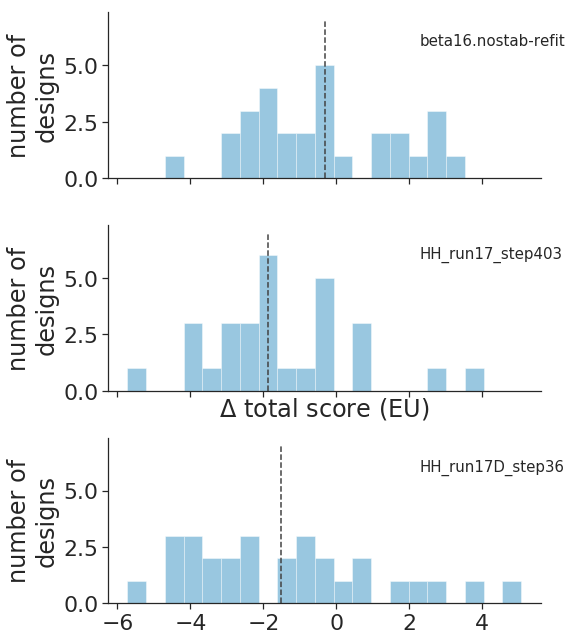

In [41]:
group_mutations_dict = {
    'HHH_rd4_0284' : [
        ('K' , 6, 'L'), ('K' , 6, 'I'), ('K' , 6, 'W'),
        ('R' , 7, 'A'),
        ('E', 8, 'W'), ('E', 8, 'L')
    ],
    'HHH_rd4_0636' : [
        ('K', 6, 'L'), ('K', 6, 'M'), ('K', 6, 'F'),
        ('E', 18, 'Y')
    ],
    'HHH_rd4_0628' : [
        ('K', 6, 'L'), ('K', 6, 'W'), ('K', 6, 'F'),
        ('K', 6, 'M'),
        ('R', 8, 'W'), ('R', 8, 'L'),
        ('E', 18, 'M'), ('E', 18, 'L'), ('E', 18, 'I'), ('E', 18, 'V'),
        ('E', 18, 'F'), ('E', 18, 'Y'), ('E', 18, 'W')
    ],
    'HHH_rd4_0216' : [
        ('R', 3, 'L'),
        ('K', 8, 'L'), ('K', 8, 'M'), ('K', 8, 'V'), ('K', 8, 'I')
    ],
    'HHH_rd4_0998' : [
        ('K', 3, 'W'), ('K', 3, 'W'),
        ('R', 14, 'L'), ('R', 14, 'M'), ('R', 14, 'W'),
        ('D', 18, 'W'),
        ('E', 24, 'W'), ('E', 24, 'Y'), ('E', 24, 'F'),
        ('K', 39, 'I'), ('K', 39, 'L')
    ],
    'HHH_rd4_0068' : [
        ('E', 18, 'M'), ('E', 18, 'L'), ('E', 18, 'I'), ('E', 18, 'V'),
        ('E', 18, 'F'), ('E', 18, 'Y'), ('E', 18, 'W')
    ],
    'HHH_rd4_0838' : [
        ('K', 6, 'I'), ('K', 6, 'L'), ('K', 6, 'M'), ('K', 6, 'V'),
        ('K', 6, 'W'), ('K', 6, 'F'),
        ('E', 18, 'L'), ('E', 18, 'V'), ('E', 18, 'L'), ('E', 18, 'F')
    ]
}

group_mutations_dict = {
    'HHH_rd4_0284' : [
        ('K' , 6, 'L'), ('K' , 6, 'I'), ('K' , 6, 'W'),
        ('R' , 7, 'A'),
        ('E', 8, 'W'), ('E', 8, 'L')
    ],
    'HHH_rd4_0636' : [
        ('K', 6, 'L'), ('K', 6, 'M'), ('K', 6, 'F'),
        ('E', 18, 'Y')
    ],
    'HHH_rd4_0628' : [
        ('K', 6, 'L'), ('K', 6, 'W'), #('K', 6, 'F'),
        #('K', 6, 'M'),
        ('R', 8, 'W'), ('R', 8, 'L'),
        ('E', 18, 'M'), ('E', 18, 'L'), ('E', 18, 'I'), #('E', 18, 'V'),
        ('E', 18, 'F'), ('E', 18, 'Y'), ('E', 18, 'W')
    ],
    'HHH_rd4_0216' : [
        #('R', 3, 'L'),
        ('K', 8, 'L'), ('K', 8, 'M')#, ('K', 8, 'V'), ('K', 8, 'I')
    ],
    'HHH_rd4_0998' : [
        ('K', 3, 'W'),
        #('R', 14, 'L'), ('R', 14, 'M'), ('R', 14, 'W'),
        #('D', 18, 'W'),
        #('E', 24, 'W'), ('E', 24, 'Y'), ('E', 24, 'F'),
        #('K', 39, 'I'), ('K', 39, 'L')
    ],
    'HHH_rd4_0068' : [
        ('E', 18, 'L'), ('E', 18, 'I'), #('E', 18, 'M'), ('E', 18, 'V'),
        ('E', 18, 'F'), #('E', 18, 'Y'), ('E', 18, 'W')
    ],
    'HHH_rd4_0838' : [
        ('K', 6, 'I'), #('K', 6, 'L'), ('K', 6, 'M'), ('K', 6, 'V'),
        ('K', 6, 'W'), #('K', 6, 'F'),
        ('E', 18, 'L')#, ('E', 18, 'V'), ('E', 18, 'L'), ('E', 18, 'F')
    ]
}

mutant_names = []
for design in group_mutations_dict:
    for (wt_aa, site, mut_aa) in group_mutations_dict[design]:
        mutant_names.append(f'{design}_{wt_aa}{site}{mut_aa}')
print(f"Analyzing {len(mutant_names)} mutants")
        
e_functions = [
    'beta16.nostab-refit',
    'HH_run17_step403',
    'HH_run17D_step36'
]
(fig, axs) = plt.subplots(
    nrows=len(e_functions), sharex=True, sharey=True,
    figsize=[8,3*len(e_functions)]
)
data = avg_scores_df[
    (avg_scores_df['name'].isin(mutant_names)) &
    (avg_scores_df['e_function'].isin(e_functions))
]
min_val = data['delta_total_score'].min()
max_val = data['delta_total_score'].max()
nbins = 20
binsize = (max_val - min_val) / nbins
bins = np.arange(min_val, max_val+2*binsize, binsize)
muts = {}
for (i, e_function) in enumerate(e_functions):
    data_i = data[data['e_function'] == e_function]
    muts[e_function] = set(data_i['name'])
    sns.distplot(
        data_i['delta_total_score'], kde=False, bins=bins, ax=axs[i]
    )
    median = data_i['delta_total_score'].median()
    mean = data_i['delta_total_score'].mean()
    print(e_function, len(data_i), mean, median)
    axs[i].plot([median, median], [0,7], ls='--', c='0.25')
    axs[i].set(xlabel='', ylabel='number of\ndesigns')
    #display(data.sort_values('delta_total_score')[cols].head(n=5))
    
    axs[i].text(
        0.72, 0.8, e_function,
        transform=axs[i].transAxes,
        fontsize=15
    )
    
axs[1].set(xlabel='$\Delta$ total score (EU)')
sns.despine()
plt.tight_layout()
plt.show()

In [42]:
e_function = 'beta16.nostab-refit' # 'HH_run17D_step36' # #'HH_run17_step403', 
data_i = data[data['e_function'] == e_function]
data_i.sort_values('delta_total_score', ascending=False)[[
    'name', 'mutation', 'delta_total_score', 'e_function'
]]

,name,mutation,delta_total_score,e_function
78,HHH_rd4_0216_K8M,K8M,3.336333,beta16.nostab-refit
36,HHH_rd4_0838_K6W,K6W,2.776667,beta16.nostab-refit
76,HHH_rd4_0628_R8W,R8W,2.727333,beta16.nostab-refit
64,HHH_rd4_0216_K8L,K8L,2.630667,beta16.nostab-refit
110,HHH_rd4_0284_E8W,E8W,2.492333,beta16.nostab-refit
57,HHH_rd4_0284_R7A,R7A,1.772667,beta16.nostab-refit
59,HHH_rd4_0628_R8L,R8L,1.545333,beta16.nostab-refit
96,HHH_rd4_0284_K6W,K6W,1.437333,beta16.nostab-refit
79,HHH_rd4_0284_E8L,E8L,1.363333,beta16.nostab-refit
67,HHH_rd4_0636_K6M,K6M,0.085667,beta16.nostab-refit


Examine the effects of mutations that change a bulky hydrophobic to a smaller side chain, or in some cases just a different hydrophobic with a different structure.

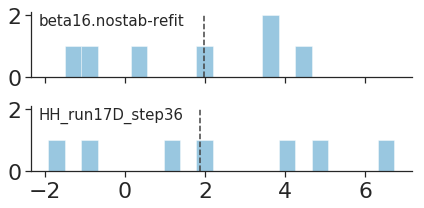

In [43]:
group_mutations_dict = {
    'HHH_rd4_0284' : [
        ('V', 21, 'A')
    ],
    'HHH_rd4_0636' : [
        ('V', 12, 'A')
    ],
    'HHH_rd4_0628' : [
        ('V', 21, 'A')
    ],
    'HHH_rd4_0216' : [
        ('V', 11, 'A'),
        ('I', 21, 'A')
    ],
    'HHH_rd4_0998' : [
        ('V', 11, 'A')
    ],
    'HHH_rd4_0068' : [
        ('V', 21, 'A')
    ],
    #'EEHEE_rd4_0215' : [
    #    ('M', 3, 'V')
    #]
}

mutant_names = []
for design in group_mutations_dict:
    for (wt_aa, site, mut_aa) in group_mutations_dict[design]:
        mutant_names.append(f'{design}_{wt_aa}{site}{mut_aa}')

e_functions = [
    'beta16.nostab-refit',
    #'HH_run17_step403',
    'HH_run17D_step36'
]
(fig, axs) = plt.subplots(
    nrows=len(e_functions), sharex=True, sharey=True,
    figsize=[6,1.5*len(e_functions)]
)
data = avg_scores_df[
    (avg_scores_df['name'].isin(mutant_names)) &
    (avg_scores_df['e_function'].isin(e_functions))
]
min_val = data['delta_total_score'].min()
max_val = data['delta_total_score'].max()
nbins = 20
binsize = (max_val - min_val) / nbins
bins = np.arange(min_val, max_val+2*binsize, binsize)
for (i, e_function) in enumerate(e_functions):
    data_i = data[data['e_function'] == e_function]
    sns.distplot(
        data_i['delta_total_score'], kde=False, bins=bins, ax=axs[i]
    )
    median = data_i['delta_total_score'].median()
    axs[i].plot([median, median], [0,2], ls='--', c='0.25')
    axs[i].set(xlabel='')
    #display(data.sort_values('delta_total_score')[cols].head(n=5))
    
    axs[i].text(
        0.02, 0.8, e_function,
        transform=axs[i].transAxes,
        fontsize=15
    )
    
sns.despine()
plt.tight_layout()
plt.show()

Analyzing 7 mutations
beta16.nostab-refit 3.576999999999998 2.495190476190487 7
HH_run17D_step36 4.609333333333353 3.6089523809523802 7


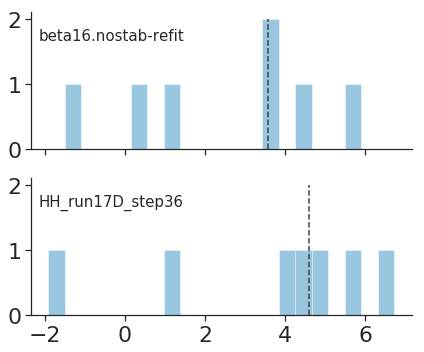

In [44]:
group_mutations_dict = {
    'HHH_rd4_0284' : [
        ('V', 21, 'A'), ('V', 21, 'G')
    ],
    'HHH_rd4_0636' : [
        ('V', 12, 'A') #, ('V', 12, 'L')#, ('V', 12, 'M'), ('V', 12, 'W'),
        #('V', 12, 'Y')
    ],
    'HHH_rd4_0628' : [
        ('V', 21, 'A')
    ],
    'HHH_rd4_0216' : [
        ('V', 11, 'G'), #('V', 11, 'A'),
        ('I', 21, 'A'), #('I', 21, 'G')
    ],
    #'HHH_rd4_0998' : [
    #    ('V', 11, 'A')#, ('V', 11, 'F')
    #],
    'HHH_rd4_0068' : [
        ('V', 21, 'A')#, ('V', 21, 'G'),
    ],
    #'EEHEE_rd4_0215' : [
    #    ('M', 3, 'V')
    #]
}

mutant_names = []
for design in group_mutations_dict:
    for (wt_aa, site, mut_aa) in group_mutations_dict[design]:
        mutant_names.append(f'{design}_{wt_aa}{site}{mut_aa}')
print(f"Analyzing {len(mutant_names)} mutations")
        
e_functions = [
    'beta16.nostab-refit',
    #'HH_run17_step403',
    'HH_run17D_step36'
]
(fig, axs) = plt.subplots(
    nrows=len(e_functions), sharex=True, sharey=True,
    figsize=[6,2.5*len(e_functions)]
)
data = avg_scores_df[
    (avg_scores_df['name'].isin(mutant_names)) &
    (avg_scores_df['e_function'].isin(e_functions))
]
min_val = data['delta_total_score'].min()
max_val = data['delta_total_score'].max()
nbins = 20
binsize = (max_val - min_val) / nbins
bins = np.arange(min_val, max_val+2*binsize, binsize)
for (i, e_function) in enumerate(e_functions):
    data_i = data[data['e_function'] == e_function]
    sns.distplot(
        data_i['delta_total_score'], kde=False, bins=bins, ax=axs[i]
    )
    median = data_i['delta_total_score'].median()
    mean = data_i['delta_total_score'].mean()
    print(e_function, median, mean, len(data_i))
    axs[i].plot([median, median], [0,2], ls='--', c='0.25')
    #axs[i].plot([mean, mean], [0,4], ls='--', c='0.25')
    axs[i].set(xlabel='')
    #display(data.sort_values('delta_total_score')[cols].head(n=5))
    
    axs[i].text(
        0.02, 0.8, e_function,
        transform=axs[i].transAxes,
        fontsize=15
    )
    
sns.despine()
plt.tight_layout()
plt.show()

In [45]:
e_function = 'beta16.nostab-refit' # 'HH_run17D_step36' # #'HH_run17_step403', 
data_i = data[data['e_function'] == e_function]
data_i.sort_values('delta_total_score', ascending=False)[[
    'name', 'mutation', 'delta_total_score', 'e_function'
]]

,name,mutation,delta_total_score,e_function
28,HHH_rd4_0216_V11G,V11G,5.603000,beta16.nostab-refit
69,HHH_rd4_0628_V21A,V21A,4.395667,beta16.nostab-refit
68,HHH_rd4_0636_V12A,V12A,3.795333,beta16.nostab-refit
106,HHH_rd4_0216_I21A,I21A,3.577000,beta16.nostab-refit
29,HHH_rd4_0284_V21G,V21G,1.133000,beta16.nostab-refit
0,HHH_rd4_0284_V21A,V21A,0.239000,beta16.nostab-refit
17,HHH_rd4_0068_V21A,V21A,-1.276667,beta16.nostab-refit


Examine the effects of mutations from a smaller hydrophobic to a larger one.

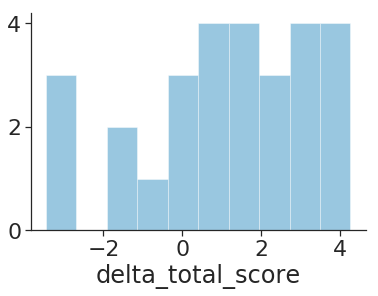

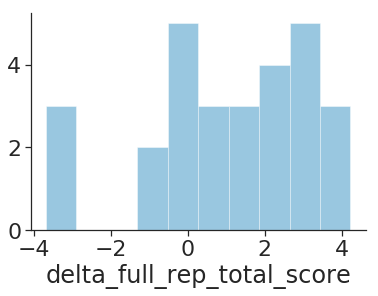

,name,mutation,delta_total_score,delta_ref
16,HHH_rd4_0998_V30F,V30F,-3.455333,-0.656
104,HHH_rd4_0998_V11F,V11F,-3.415000,-0.656
39,HHH_rd4_0998_V30Y,V30Y,-2.824000,-1.111
18,HHH_rd4_0216_A4I,A4I,-1.439000,-1.301
76,HHH_rd2_0184_A25L,A25L,-1.327000,-1.609
51,HHH_rd4_0998_V30W,V30W,-0.564000,1.224
29,HHH_rd4_0628_V30F,V30F,0.015667,-0.656
107,EEHEE_rd4_0215_A18M,A18M,0.085000,-1.053
32,HHH_rd4_0216_A4L,A4L,0.159000,-1.608
25,HHH_rd4_0216_A4V,A4V,0.502333,-0.240


In [37]:
group_mutations_dict = {
    'HHH_rd4_0284' : [
        ('A', 9, 'I'), ('A', 9, 'L')
    ],
    'HHH_rd4_0636' : [
        ('V', 12, 'W'), ('V', 12, 'Y')
    ],
    'HHH_rd4_0628' : [
        ('A', 9, 'L'), ('A', 9, 'V'), ('A', 9, 'I'), ('A', 9, 'M'),
        ('V', 30, 'F'), ('V', 30, 'Y')
    ],
    'HHH_rd2_0184' : [
        ('A', 25, 'L')
    ],
    'HHH_rd4_0216' : [
        ('A', 4, 'L'), ('A', 4, 'I'), ('A', 4, 'V')
    ],
    'HHH_rd4_0998' : [
        ('V', 11, 'F'),
        ('V', 30, 'W'), ('V', 30, 'Y'), ('V', 30, 'F'), ('V', 30, 'L')
    ],
    'HHH_rd4_0068' : [
        ('V', 30, 'W'), ('V', 30, 'Y'), ('V', 30, 'F'), ('V', 30, 'L'),
        ('V', 42, 'W'), ('V', 42, 'Y'), ('V', 42, 'F'), ('V', 42, 'L')
    ],
    'EEHEE_rd4_0215' : [
        ('A', 18, 'M')
    ]
}
mutant_names = []
for design in group_mutations_dict:
    for (wt_aa, site, mut_aa) in group_mutations_dict[design]:
        mutant_names.append(f'{design}_{wt_aa}{site}{mut_aa}')
data = avg_scores_df[
    (avg_scores_df['name'].isin(mutant_names))
]

sns.distplot(data['delta_total_score'], kde=False, bins=10)
sns.despine()
plt.show()

sns.distplot(data['delta_full_rep_total_score'], kde=False, bins=10)
sns.despine()
plt.show()

display(data.sort_values('delta_total_score')[cols])

Examine the energetics at the level of individual resdiues and atoms

In [2]:
sf = pyrosetta.get_fa_scorefxn()
def fix_scorefxn(sfxn, allow_double_bb=False):
    opts = sfxn.energy_method_options()
    opts.hbond_options().decompose_bb_hb_into_pair_energies(True)
    opts.hbond_options().bb_donor_acceptor_check(not allow_double_bb)
    sfxn.set_energy_method_options(opts)
fix_scorefxn(sf)

In [3]:
design = 'HHH_rd4_0216_wt'
pdb = glob.glob(os.path.join(
    'results/lowest_energy_decoys/beta16.nostab-refit/',
    design,
    '*.pdb'
))
assert len(pdb) == 1
pdb = pdb[0]

pose = pyrosetta.pose_from_pdb(pdb)
DSSP = pyrosetta.rosetta.protocols.moves.DsspMover()
DSSP.apply(pose)
ss = pose.secstruct()
print(pose.sequence(), sf(pose) / len(pose.sequence()))
print(ss)

LERAERIKREVERKQLSEKQIEDLLRRAGVDERIIEKILRELS -4.1955558620081845
LHHHHHHHHHHHHHLLLHHHHHHHHHHLLLLHHHHHHHHHHHL


In [4]:
def compute_lj_energy(e, o, d):
    energy = e * (math.pow((o/d), 12) - 2 * math.pow((o/d), 6))
    return energy

def compute_rosetta_lj_energy(e, o, d, rep_weight=1.0):
    if d < 0.6*o:
        return np.nan
    elif 0.6*o < d <= o:
        atr = -e
        rep = e * (math.pow((o/d), 12) - 2 * math.pow((o/d), 6) + 1)
    elif d < 4.5:
        atr = e * (math.pow((o/d), 12) - 2 * math.pow((o/d), 6))
        rep = 0
    else:
        return np.nan
    
    energy = atr + (rep * rep_weight)
    return energy

def compute_pairwise_energies(
    pose, res_i_n, atom_i_n, sf, ij_and_ji=False
):
    """
    Compute pairwise energies between an input atom and all others
    
    Args:
        *pose*: a PyRosetta pose
        *res_i_n*: the number of the input residue
        *atom_i_n*: the number of the input atom on the input residue
        *sf*: the score function used to compute energies
        *ij_and_ji*: a boolean specifying whether to compute all ij and
            ji interactions. If False (default), then only return
            interactions when the residue number of i is less than j 
        
    Returns:
        A dataframe where rows are pairwise interactions, and columns
            give metadata on the pair of atoms involved and their
            energies
    """
    
    # Initiate a dictionary to record data
    energies_dict = {
        key : []
        for key in [
            'res_j_n', 'res_j_pdb_n', 'res_j_name', 'res_j_ss',
            'atom_j_n', 'atom_j_name', 'atom_j_type_name',
            'lj_atr', 'lj_rep', 'fa_solv', 'fa_elec',
            'atom_j_lj_radius', 'atom_j_lj_wdepth',
            'd'
        ]
    }
    
    # Get the SS of each site in the protein
    DSSP = pyrosetta.rosetta.protocols.moves.DsspMover()
    DSSP.apply(pose)
    ss = pose.secstruct()
    
    # Make an object corresponding to the input residue and get
    # the XYZ coordinates of the input atom
    res_i = pose.residue(res_i_n)
    atom_i_xyz = res_i.xyz(atom_i_n)
    
    # Record pairwise energies between the input atom and all other
    # atoms in the structure
    etable_atom_pair_energies = \
        pyrosetta.toolbox.atom_pair_energy.etable_atom_pair_energies
    for res_j_n in list(range(1, pose.size()+1)):
        if not ij_and_ji:
            if res_j_n < res_i_n:
                continue
        res_j = pose.residue(res_j_n)
        for atom_j_n in list(range(1, res_j.natoms()+1)):
            
            # Skip res_j and atom_j if they are the same as the
            # input residue and atom
            if (res_j_n == res_i_n) and (atom_j_n == atom_i_n):
                continue

            # Compute pairwise energies between atoms i and j
            (lj_atr, lj_rep, fa_solv, fa_elec) = \
                etable_atom_pair_energies(
                    res1=res_i,
                    atom_index_1=atom_i_n,
                    res2=res_j,
                    atom_index_2=atom_j_n,
                    sfxn=sf
                )
            
            # Record data in dictionary
            atom_type_j = res_j.atom_type(atom_j_n)
            atom_j_xyz = res_j.xyz(atom_j_n)
            energies_dict['res_j_n'].append(res_j_n)
            energies_dict['res_j_pdb_n'].append(
                pose.pdb_info().number(res_j_n)
            )
            energies_dict['res_j_name'].append(res_j.name3())
            energies_dict['res_j_ss'].append(ss[res_j_n-1])
            energies_dict['atom_j_n'].append(atom_j_n)
            energies_dict['atom_j_name'].append(
                res_j.atom_name(atom_j_n).strip()
            )
            energies_dict['atom_j_type_name'].append(
                atom_type_j.name().strip()
            )
            energies_dict['lj_atr'].append(lj_atr)
            energies_dict['lj_rep'].append(lj_rep)
            energies_dict['fa_solv'].append(fa_solv)
            energies_dict['fa_elec'].append(fa_elec)
            energies_dict['atom_j_lj_radius'].append(
                atom_type_j.lj_radius()
            )
            energies_dict['atom_j_lj_wdepth'].append(
                atom_type_j.lj_wdepth()
            )
            energies_dict['d'].append(
                (atom_i_xyz - atom_j_xyz).norm()
            )
           
    # Convert the above dictionary into a dataframe
    energies_df = pandas.DataFrame(energies_dict)
    
    # Add information on the input residue and atom
    energies_df['res_i_n'] = res_i_n
    energies_df['res_i_pdb_n'] = pose.pdb_info().number(res_i_n)
    energies_df['res_i_name'] = res_i.name3()
    energies_df['res_i_ss'] = ss[res_i_n-1]
    energies_df['atom_i_n'] = atom_i_n
    energies_df['atom_i_name'] = res_i.atom_name(atom_i_n).strip()
    atom_type_i = res_i.atom_type(atom_i_n)
    energies_df['atom_i_type_name'] = atom_type_i.name().strip()
    energies_df['atom_i_lj_radius'] = atom_type_i.lj_radius()
    energies_df['atom_i_lj_wdepth'] = atom_type_i.lj_wdepth()

    # Compute values that characterize VdW interactions, including
    # the sum of atomic radii of atoms i and j (o)...
    energies_df['o'] = energies_df.apply(
        lambda row: row['atom_i_lj_radius'] + row['atom_j_lj_radius'],
        axis=1
    )
    
    #... the well depth, computed as the geometric mean of the wdepth
    # values for atoms i and j...
    energies_df['e'] = energies_df.apply(
        lambda row: math.sqrt(
            row['atom_i_lj_wdepth'] * row['atom_j_lj_wdepth']
        ),
        axis=1
    )
    
    # ... the LJ potential for atoms i and j...
    energies_df['lj_energy'] = energies_df.apply(
        lambda row: compute_lj_energy(row['e'], row['o'], row['d']),
        axis=1
    )
    
    # ... the LJ potential computed using Rosetta...
    energies_df['rosetta_lj_energy'] = energies_df.apply(
        lambda row: compute_rosetta_lj_energy(
            row['e'], row['o'], row['d'], rep_weight=1.0
        ),
        axis=1
    )
    
    # ... the LJ potential computed using Rosetta with a weight of
    # 0.55 on the repulsive term
    energies_df['weighted_rosetta_lj_energy'] = energies_df.apply(
        lambda row: compute_rosetta_lj_energy(
            row['e'], row['o'], row['d'], rep_weight=0.55
        ),
        axis=1
    )
    
    # Return the dataframe
    return energies_df

For each input structure, compute energies between pairs of atoms.

In [6]:
pdbs = [
    'HHH_rd4_0216_wt' ,
    'HHH_rd4_0216_I21A',
    'HHH_rd4_0216_V11A',
    'HHH_rd4_0216_V11G'
    #'HHH_rd4_0636_wt'
]
pdbs = [
    'HHH_rd4_0216_wt'
]
df_exists = False
pdb_dir = 'results/lowest_energy_decoys/beta16.nostab-refit/'
#pdb_dir = 'results/abinitio_minima/'
#pdb_dir = 'results/abinitio_minima/HH_run17D_step36'
for pdb in pdbs:
    print(pdb)
    pdb_files = glob.glob(os.path.join(
        pdb_dir,
        pdb,
        '*.pdb'
    ))
    #assert len(pdb_files) == 1, len(pdb_files)
    pdb_file = pdb_files[0]
    pose = pyrosetta.pose_from_pdb(pdb_file)
    for res_i_n in range(1, pose.size()+1):
        res_i = pose.residue(res_i_n)
        res_i_name = res_i.name3()
        if res_i_name not in ['VAL', 'LEU', 'ILE', 'ALA', 'MET']:
            continue
        for atom_i_n in list(range(1, res_i.natoms()+1)):
            atom_i_name = res_i.atom_name(atom_i_n)
            #if atom_i_name.strip() in ['N', 'C', 'CA', 'H', 'HA', 'O']:
            #    continue
            df = compute_pairwise_energies(pose, res_i_n, atom_i_n, sf)
            df['pdb'] = pdb
            if not df_exists:
                energies_df = df.copy()
                df_exists = True
            else:
                energies_df = \
                    pandas.concat([energies_df, df], sort=False)

# Remove duplicate entries in the dataframe where atom i == atom j
energies_df['pair_id'] = energies_df.apply(
    lambda row: '_'.join(sorted([
        row['pdb'],
        "{0}_{1}".format(row['res_i_n'], row['atom_i_n']),
        "{0}_{1}".format(row['res_j_n'], row['atom_j_n']),
    ])),
    axis=1
)
energies_df.sort_values('res_i_n', ascending=True, inplace=True)
#energies_df.drop_duplicates('pair_id', inplace=True, keep='first')

HHH_rd4_0216_wt


Analyze repulsive energies between clashing atoms

In [8]:
pdb = 'HHH_rd4_0216_wt'
#pdb = 'HHH_rd4_0216_I21A'
#pdb = 'HHH_rd4_0284_wt'
res_n = 21
df = energies_df[
    (energies_df['pdb']==pdb) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    ~(
        (energies_df['atom_i_name'].isin(
            ['N', 'C', 'CA', 'H', 'HA', 'O']
        )) &
        (energies_df['atom_j_name'].isin(
            ['N', 'C', 'CA', 'H', 'HA', 'O']
        ))
    ) &
    #(
    #    (energies_df['res_i_n'] == res_n) |
    #    (energies_df['res_j_n'] == res_n)
    #) &
    (energies_df['lj_rep'] > 0)
].copy()
df.drop_duplicates('pair_id', inplace=True, keep='first')
cols = [
    'pdb',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'lj_rep', 'lj_atr', 'lj_energy', 'd', 'o',
    'res_i_ss', 'res_j_ss'
]
df.sort_values('lj_rep', ascending=False, inplace=True)
df[cols].head(n=10)

,pdb,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,lj_rep,lj_atr,lj_energy,d,o,res_i_ss,res_j_ss
18,HHH_rd4_0216_wt,21,ILE,CB,22,GLU,N,0.930380,-0.100652,0.829729,3.022286,3.814212,H,H
15,HHH_rd4_0216_wt,11,VAL,CB,12,GLU,N,0.631767,-0.100652,0.531115,3.094684,3.814212,H,H
188,HHH_rd4_0216_wt,11,VAL,CG2,21,ILE,1HG1,0.547600,-0.036961,0.510639,2.638765,3.433032,H,H
15,HHH_rd4_0216_wt,28,ALA,C,29,GLY,2HA,0.536005,-0.055609,0.480397,2.637940,3.337933,L,L
18,HHH_rd4_0216_wt,35,ILE,CB,36,GLU,N,0.490451,-0.100652,0.389799,3.140836,3.814212,H,H
94,HHH_rd4_0216_wt,7,ILE,O,11,VAL,3HG2,0.480617,-0.055730,0.424887,2.357085,2.961852,H,H
18,HHH_rd4_0216_wt,24,LEU,CB,25,LEU,N,0.470705,-0.100652,0.370053,3.148223,3.814212,H,H
18,HHH_rd4_0216_wt,39,LEU,CB,40,ARG,N,0.468554,-0.100652,0.367902,3.149045,3.814212,H,H
97,HHH_rd4_0216_wt,30,VAL,2HG1,35,ILE,2HG1,0.444764,-0.021808,0.422956,2.138468,2.842544,L,H
68,HHH_rd4_0216_wt,1,LEU,2HB,4,ALA,3HB,0.424291,-0.021808,0.402483,2.145340,2.842544,L,H


In [93]:
(res_i_n, atom_i_name) = (9, '1HB')
(res_j_n, atom_j_name) = (21, 'CG1')
cols = [
    'pdb',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'lj_rep', 'lj_atr', 'lj_energy', 'fa_solv', 'd'
]
energies_df[
    (energies_df['pdb']==pdb) &
    #(energies_df['res_i_n'] == res_i_n) &
    #(energies_df['res_j_n'] == res_j_n) &
    #(energies_df['atom_i_name'] == atom_i_name) &
    (energies_df['atom_j_name'] == atom_j_name) &
    #(energies_df['lj_rep'] <= 0) &
    (
        (energies_df['res_i_n'] == res_j_n) |
        (energies_df['res_j_n'] == res_j_n)
    ) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['fa_solv'] > 0)
    #(energies_df['atom_i_type_name'].str.contains('CH3')) &
    #(energies_df['atom_j_type_name'].str.contains('CH3'))
    
].sort_values('d')[cols]

,pdb,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,lj_rep,lj_atr,lj_energy,fa_solv,d
88,HHH_rd4_0216_wt,16,LEU,CB,21,ILE,CG1,0.0,-0.061279,-0.061279,0.091367,4.131979
182,HHH_rd4_0216_wt,11,VAL,CB,21,ILE,CG1,0.0,-0.053912,-0.053912,0.126985,4.349427
88,HHH_rd4_0216_wt,16,LEU,CG,21,ILE,CG1,0.0,-0.014609,-0.021952,0.034733,5.287993


In [44]:
e = 0.021808
o_i = 1.421272
o_j = 1.421272
o_ij = o_i + o_j
new_o_ij = o_i + o_j + (2*0.20)
d = 2.117999 #o_ij
print(compute_lj_energy(e, o_ij, d))
print(compute_lj_energy(e, new_o_ij, d))

0.4898410155082605
3.053668443762306


## Relax designs before computing inter-atomic distances

First, copy a random 50 designs into a new directory

In [2]:
# Copy a random 50 PDBs from Brian's HHH set
pdbs_f = os.path.join(
    '/home/bcov/sc/helical_bundles/attempt2/',
    'finished/scaffolds_b1_b2.list'
)
with open(pdbs_f) as f:
    lines = f.readlines()
pdbs = [line.strip() for line in lines]
random.seed(a=5)
pdbs = random.sample(pdbs, 50)
new_pdb_dir = 'results/designs_from_lab/HHH_BC/'
design_utils.copy_pdbs(pdbs=pdbs, new_pdb_dir=new_pdb_dir)

# Copy PDBs from other sets
pdb_dirs = {
    'ferr_BH' : \
        '/home/bhuang4/_scaffold_design/scaffolds/ferr_buw_lddt0.9/pdbs',
    'NTF2s_CN' : \
        '/home/norn/NTF2/200409_generate_native_constained_idealized_NTF2/good_fix'
}

# Loop over each group and copy 50 random PDBs
for pdb_group in pdb_dirs:
    pdb_dir = pdb_dirs[pdb_group]
    new_pdb_dir = f'results/designs_from_lab/{pdb_group}/'
    pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
    random.seed(a=5)
    pdbs = random.sample(pdbs, 50)
    design_utils.copy_pdbs(pdbs=pdbs, new_pdb_dir=new_pdb_dir)

Next, relax each group of PDBs from above, as well as additional groups of PDBs that I define below

In [2]:
# Define energy functions
e_function_dict = {
    'talaris2013' : {
        'weights_file' : 'talaris2013',
        'cart_weights_file' : 'talaris2013_cart',
        'flags_file' : None, 
        'extra_args' : ['-restore_talaris_behavior 1']
    },
    'talaris2014' : {
        'weights_file' : 'talaris2014',
        'cart_weights_file' : 'talaris2014_cart',
        'flags_file' : None, 
        'extra_args' : ['-restore_talaris_behavior 1']
    },
    'ref2015' : {
        'weights_file' : 'ref2015',
        'cart_weights_file' : 'ref2015_cart',
        'flags_file' : None, 
        'extra_args' : []
    },
    'beta_nov16' : {
        'weights_file' : 'beta_nov16',
        'cart_weights_file' : 'beta_nov16_cart',
        'flags_file' : None, 
        'extra_args' : [
            '-beta_nov16',
            '-corrections:beta_nov16'
        ]
    },
    'beta16.nostab-refit' : {
        'weights_file' : \
            'scripts/weights_and_flags/beta16.nostab-refit.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/beta16.nostab-refit_cart.wts',
        'flags_file' : None, 
        'extra_args' : [
            '-beta_nov16',
            '-corrections:beta_nov16'
        ]
    },
    'beta16.nostab-refit_revert_charges_charged_sc' : {
        'weights_file' : \
            'scripts/weights_and_flags/beta16.nostab-refit.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/beta16.nostab-refit_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/flags_beta16_revert_charges_charged_sc',
        'extra_args' : [
        ]
    },
    'beta16.nostab-refit_dist_indep_elec' : {
        'weights_file' : \
            'scripts/weights_and_flags/beta16.nostab-refit.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/beta16.nostab-refit_cart.wts',
        'flags_file' : None, 
        'extra_args' : [
            '-beta_nov16',
            '-corrections:beta_nov16',
            '-elec_r_option True',
        ]
    },
    
    'HH_run9_step282' : {
        'weights_file' : \
            'scripts/weights_and_flags/HH_run9_weights_282.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run9_weights_282_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/HH_run9_flags_282',
        'extra_args' : []
    },
    'HH_run17_step403' : {
        'weights_file' : \
            'scripts/weights_and_flags/HH_run17_weights_403.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run17_weights_403_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/HH_run17_flags_403', 
        'extra_args' : []
    },
    'HH_run17D_step36' : {
        'weights_file' : \
            'scripts/weights_and_flags/HH_run17D_weights_36.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run17D_weights_36_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/HH_run17D_flags_36', 
        'extra_args' : []
    },
    'HH_run18C_step286' : {
        'weights_file' : \
            'scripts/weights_and_flags/HH_run18C_weights_286.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run18C_weights_286_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/HH_run18C_flags_286', 
        'extra_args' : []
    },
    'HH_run18E_step147' : {
        'weights_file' : \
            'scripts/weights_and_flags/HH_run18E_weights_147.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run18E_weights_147_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/HH_run18E_flags_147', 
        'extra_args' : []
    },
    'HH_run18D_step886_modified6f' : {
        'weights_file' : \
            'scripts/weights_and_flags/HH_run18D_weights_886_modified.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run18D_weights_886_modified_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/HH_run18D_flags_886_modified6f',
        'extra_args' : []
    },
    'HH_run18F_step434_mod2g' : {
        'weights_file' : \
            'scripts/weights_and_flags/HH_run18F_weights_434.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run18F_weights_434_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/HH_run18F_flags_434_mod2g',
        'extra_args' : []
    },
    'HH_run19A_step266' : {
        'weights_file' : \
            'scripts/weights_and_flags/HH_run19A_weights_266.wts',
        'cart_weights_file' : \
            'scripts/weights_and_flags/HH_run19A_weights_266_cart.wts',
        'flags_file' : 'scripts/weights_and_flags/HH_run19A_flags_266',
        'extra_args' : []
    },
}

Relax miniprotein designs made with MonomerDesign protocol

In [5]:
# Path to Rosetta relax app
relax_app_path = '/software/rosetta/versions/v2019.45-dev61026/bin/relax.hdf5.linuxgccrelease'

# Define input params for relax protocol
relax_script = 'MonomerDesign2019'
relax_space_name = 'cartesian' # 'torsion' # 'dualspace' #
relax_space_dict = {
    'torsion' : False,
    'dualspace' : 'dualspace',
    'cartesian' : 'cartesian'
}
relax_space = relax_space_dict[relax_space_name]

add_constraints = True
if add_constraints:
    relax_space_name = f'constrained_{relax_space_name}'

# Loop over each group of PDB files and energy functions
# and relax with the appropriate energy function
topologies = [
    'HHH_43aa', '3h_1018', 'EEHEE_43aa', 'EEHEE_57aa', 'EHEE_40aa',
    'EHEE_65aa', 'HEEHE_65aa', '4h'
]
e_functions = [
    #'talaris2014',
    #'ref2015',
    'beta16.nostab-refit',
    'HH_run18D_step886_modified6f',
    #'HH_run9_step282',
    #'HH_run17_step403',
    #'HH_run17D_step36',
    #'HH_run18C_step286',
    #'HH_run18E_step147'
]
for topology in topologies:
    
    if topology == '4h':
        base_pdb_dir = os.path.join(
            '/home/haddox/2019/',
            'compare_design_protocols/results/standard_with_extra_rotamers/from_Brian/'
        )
    else:
        base_pdb_dir = os.path.join(
            '/home/haddox/2019/',
            'compare_design_protocols/results/standard_with_extra_rotamers/new/'
        )
    
    for e_function in e_functions:
        
        # Make a list of PDBs to relax
        pdb_group = f'{topology}_{e_function}'
        pdb_dir = os.path.join(
            base_pdb_dir,
            topology,
            'MonomerDesign2019',
            e_function
        )
        input_pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
        
        # Get flags, weights, and extra args for the energy
        # function to be used in the relax step
        relax_e_function = e_function
        if relax_space_name == 'torsion':
            weights_file = \
                e_function_dict[relax_e_function]['weights_file']
        else:
            weights_file = \
                e_function_dict[relax_e_function]['cart_weights_file']
        flags_file = e_function_dict[relax_e_function]['flags_file']
        extra_args = ['-ex1', '-ex2', '-linmem_ig 10']
        if add_constraints:
            extra_args += [
                '-constrain_relax_to_start_coords',
                '-relax:coord_constrain_sidechains'
            ]
        extra_args += e_function_dict[relax_e_function]['extra_args']

        # Define the path to a directory for storing the results
        output_dir = os.path.join(
            pdb_dir,
            'cart_relax',
            relax_e_function + '/'
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)

        # Carry out the relax
        scores_file_prefix = os.path.join(output_dir, 'score')
        if not os.path.isfile(f'{scores_file_prefix}.sbatch'):
            print(pdb_dir)
            design_utils.relax_design(
                relax_app_path=relax_app_path,
                input_pdbs=input_pdbs,
                weights_file=weights_file,
                results_dir=output_dir,
                scores_file_prefix=scores_file_prefix,
                relax_space=relax_space,
                relax_script=relax_script,
                extra_args=extra_args,
                flags_file=flags_file,
                submit_sbatch_job=True,
                queue_type='short',
                memory='2g'
            )

/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/new/HHH_43aa/MonomerDesign2019/beta16.nostab-refit
/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/new/HHH_43aa/MonomerDesign2019/HH_run18D_step886_modified6f
/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/new/3h_1018/MonomerDesign2019/beta16.nostab-refit
/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/new/3h_1018/MonomerDesign2019/HH_run18D_step886_modified6f
/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/new/EEHEE_43aa/MonomerDesign2019/beta16.nostab-refit
/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/new/EEHEE_43aa/MonomerDesign2019/HH_run18D_step886_modified6f
/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/new/EEHEE_57aa/MonomerDesign2019/beta16.nostab-refit
/home/haddox/2019/compare_design_protocols/results/s

Relax miniprotein designs made with the Legacy relax protocol

In [8]:
# Path to Rosetta relax app
relax_app_path = '/software/rosetta/versions/v2019.45-dev61026/bin/relax.hdf5.linuxgccrelease'

# Define input params for relax protocol
relax_script = 'legacy'
relax_space_name = 'cartesian' # 'torsion' # 'dualspace' #
relax_space_dict = {
    'torsion' : False,
    'dualspace' : 'dualspace',
    'cartesian' : 'cartesian'
}
relax_space = relax_space_dict[relax_space_name]

add_constraints = True
if add_constraints:
    relax_space_name = f'constrained_{relax_space_name}'

# Loop over each group of PDB files and energy functions
# and relax with the appropriate energy function
topologies = [
    'HHH_43aa', '3h_1018', 'EEHEE_43aa', 'EEHEE_57aa', 'EHEE_40aa',
    'EHEE_65aa', 'HEEHE_65aa', '4h'
]
e_functions = [
    'beta16.nostab-refit',
    #'HH_run18D_step886_modified6f',
]
for topology in topologies:
    
    if topology == '4h':
        base_pdb_dir = os.path.join(
            '/home/haddox/2019/',
            'compare_design_protocols/results/standard_with_extra_rotamers/from_Brian/'
        )
    else:
        base_pdb_dir = os.path.join(
            '/home/haddox/2019/',
            'compare_design_protocols/results/standard_with_extra_rotamers/new/'
        )
    
    for e_function in e_functions:
        
        # Make a list of PDBs to relax
        pdb_group = f'{topology}_{e_function}'
        pdb_dir = os.path.join(
            base_pdb_dir,
            topology,
            'custom_default',
            e_function
        )
        input_pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
        
        # Get flags, weights, and extra args for the energy
        # function to be used in the relax step
        relax_e_function = e_function
        if relax_space_name == 'torsion':
            weights_file = \
                e_function_dict[relax_e_function]['weights_file']
        else:
            weights_file = \
                e_function_dict[relax_e_function]['cart_weights_file']
        flags_file = e_function_dict[relax_e_function]['flags_file']
        extra_args = ['-ex1', '-ex2', '-linmem_ig 10']
        if add_constraints:
            extra_args += [
                '-constrain_relax_to_start_coords',
                '-relax:coord_constrain_sidechains'
            ]
        extra_args += e_function_dict[relax_e_function]['extra_args']

        # Define the path to a directory for storing the results
        output_dir = os.path.join(
            pdb_dir,
            'cart_relax',
            relax_e_function + '/'
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)

        # Carry out the relax
        scores_file_prefix = os.path.join(output_dir, 'score')
        if not os.path.isfile(f'{scores_file_prefix}.sbatch'):
            print(pdb_dir)
            design_utils.relax_design(
                relax_app_path=relax_app_path,
                input_pdbs=input_pdbs,
                weights_file=weights_file,
                results_dir=output_dir,
                scores_file_prefix=scores_file_prefix,
                relax_space=relax_space,
                relax_script=relax_script,
                extra_args=extra_args,
                flags_file=flags_file,
                submit_sbatch_job=True,
                queue_type='short',
                memory='2g'
            )

/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/new/3h_1018/custom_default/beta16.nostab-refit
/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/new/EEHEE_43aa/custom_default/beta16.nostab-refit
/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/new/EEHEE_57aa/custom_default/beta16.nostab-refit
/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/new/EHEE_40aa/custom_default/beta16.nostab-refit
/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/new/EHEE_65aa/custom_default/beta16.nostab-refit
/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/new/HEEHE_65aa/custom_default/beta16.nostab-refit
/home/haddox/2019/compare_design_protocols/results/standard_with_extra_rotamers/from_Brian/4h/custom_default/beta16.nostab-refit


Also relax pairs of designs and corresponding xtal structures

In [3]:
# Path to Rosetta relax app
relax_app_path = '/home/haddox/Rosetta/main/source/bin/relax.default.linuxgccrelease'

# Define input params for relax protocol
relax_script = 'MonomerDesign2019'
relax_space_name = 'cartesian' # 'dualspace' # 'torsion' #
relax_space_dict = {
    'torsion' : False,
    'dualspace' : 'dualspace',
    'cartesian' : 'cartesian'
}
relax_space = relax_space_dict[relax_space_name]

add_constraints = False
if add_constraints:
    relax_space_name = f'constrained_{relax_space_name}'

# List of energy functions to use in relaxing designs
e_functions = [
    #'talaris2014',
    #'ref2015',
    'beta16.nostab-refit',
    #'beta16.nostab-refit_revert_charges_charged_sc',
    #'beta16.nostab-refit_dist_indep_elec',
    #'HH_run9_step282',
    #'HH_run17_step403',
    #'HH_run17D_step36',
    #'HH_run18C_step286',
    #'HH_run18E_step147'
    #'HH_run18F_step434_mod2g',
    'HH_run19A_step266',
]
pdb_dirs = {
    'NTF2_designs' : 'data/designs_and_xtals/NTF2_designs/',
    'NTF2_xtals' : 'data/designs_and_xtals/NTF2_xtals/',
    'beta_barrel_designs' : 'data/designs_and_xtals/beta_barrel_designs/',
    'beta_barrel_xtals' : 'data/designs_and_xtals/beta_barrel_xtals/',
    'zibo_heterodimers_designs' : 'data/designs_and_xtals/zibo_heterodimers_designs/',
    'zibo_heterodimers_xtals' : 'data/designs_and_xtals/zibo_heterodimers_xtals/',
    'heterodimer_designs' : 'data/designs_and_xtals/heterodimer_designs/',
    'heterodimer_xtals' : 'data/designs_and_xtals/heterodimer_xtals/',
    'derroids_designs' : 'data/designs_and_xtals/derroids_designs/',
    'derroids_xtals' : 'data/designs_and_xtals/derroids_xtals/',
    'derroids_xtals_refined' : 'data/designs_and_xtals/derroids_xtals_refined/',
    'DHR_designs' : 'data/designs_and_xtals/DHR_designs/',
    'DHR_xtals' : 'data/designs_and_xtals/DHR_xtals/',
    'helical_repeats_designs' : 'data/designs_and_xtals/helical_repeats_designs/',
    'helical_repeats_xtals' : 'data/designs_and_xtals/helical_repeats_xtals/',
    'repeat_peptide_binder_designs' : 'data/designs_and_xtals/repeat_peptide_binder_designs/',
    'repeat_peptide_binder_xtals' : 'data/designs_and_xtals/repeat_peptide_binder_xtals/',
    'LOCKR_designs' : 'data/designs_and_xtals/LOCKR_designs/',
    'LOCKR_xtals' : 'data/designs_and_xtals/LOCKR_xtals/',
    'small_molecule_binders_designs' : 'data/designs_and_xtals/small_molecule_binders_designs/',
    'small_molecule_binders_xtals' : 'data/designs_and_xtals/small_molecule_binders_xtals/',
    'transmembrane_pores_designs' : 'data/designs_and_xtals/transmembrane_pores_designs/',
    'transmembrane_pores_xtals' : 'data/designs_and_xtals/transmembrane_pores_xtals/',
    'hfuse_jl_designs' : 'data/designs_and_xtals/hfuse_jl_designs/',
    'hfuse_jl_xtals' : 'data/designs_and_xtals/hfuse_jl_xtals/',
}

# Loop over each group of PDB files and energy functions
# and relax with each combo
for (pdb_group, pdb_dir) in pdb_dirs.items():
    
    #if 'zibo' in pdb_group:
    #    continue
    
    # Make a list of PDBs to relax
    input_pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
    for relax_e_function in e_functions:
    
        # Get flags, weights, and extra args for the energy
        # function to be used in the relax step
        if relax_space_name == 'torsion':
            weights_file = \
                e_function_dict[relax_e_function]['weights_file']
        else:
            weights_file = \
                e_function_dict[relax_e_function]['cart_weights_file']
        flags_file = e_function_dict[relax_e_function]['flags_file']
        extra_args = ['-ex1', '-ex2', '-linmem_ig 10']
        if add_constraints:
            extra_args += [
                '-constrain_relax_to_start_coords',
                '-relax:coord_constrain_sidechains'
            ]
        extra_args += e_function_dict[relax_e_function]['extra_args']

        # Define the path to a directory for storing the results
        output_dir = os.path.join(
            resultsdir,
            'xtals_and_designs',
            pdb_group,
            relax_e_function,
            relax_space_name + '/'
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)

        # Carry out the relax
        scores_file_prefix = os.path.join(output_dir, 'relax')
        if not os.path.isfile(f'{scores_file_prefix}.sbatch'):
            print(pdb_dir)
            design_utils.relax_design(
                relax_app_path=relax_app_path,
                input_pdbs=input_pdbs,
                weights_file=weights_file,
                results_dir=output_dir,
                scores_file_prefix=scores_file_prefix,
                relax_space=relax_space,
                relax_script=relax_script,
                extra_args=extra_args,
                flags_file=flags_file,
                submit_sbatch_job=True,
                queue_type='medium',
                memory='2g'
            )

data/designs_from_lab/NTF2s_SP/
data/designs_from_lab/NTF2s_SP/


Same as above but without ramping constraints, a higher constraint weight, and fewer relax rounds in Cartesian space

In [4]:
# Path to Rosetta relax app
relax_app_path = '/home/haddox/Rosetta/main/source/bin/relax.default.linuxgccrelease'

# Define input params for relax protocol
relax_script = False
relax_space_name = 'cartesian' # 'dualspace' # 'torsion' #
relax_space_dict = {
    'torsion' : False,
    'dualspace' : 'dualspace',
    'cartesian' : 'cartesian'
}
relax_space = relax_space_dict[relax_space_name]

add_constraints = True
if add_constraints:
    relax_space_name = f'constrained_{relax_space_name}_1_repeat'

# List of energy functions to use in relaxing designs
e_functions = [
    #'talaris2014',
    #'ref2015',
    'beta16.nostab-refit',
    'HH_run19A_step266',
]
pdb_dirs = {
    'NTF2_xtals' : 'data/designs_and_xtals/NTF2_xtals/',
    'beta_barrel_xtals' : 'data/designs_and_xtals/beta_barrel_xtals/',
    'zibo_heterodimers_xtals' : 'data/designs_and_xtals/zibo_heterodimers_xtals/',
    'heterodimer_xtals' : 'data/designs_and_xtals/heterodimer_xtals/',
    'derroids_xtals' : 'data/designs_and_xtals/derroids_xtals/',
    'derroids_xtals_refined' : 'data/designs_and_xtals/derroids_xtals_refined/',
    'DHR_xtals' : 'data/designs_and_xtals/DHR_xtals/',
    'helical_repeats_xtals' : 'data/designs_and_xtals/helical_repeats_xtals/',
    'repeat_peptide_binder_xtals' : 'data/designs_and_xtals/repeat_peptide_binder_xtals/',
    'LOCKR_xtals' : 'data/designs_and_xtals/LOCKR_xtals/',
    'small_molecule_binders_xtals' : 'data/designs_and_xtals/small_molecule_binders_xtals/',
    'transmembrane_pores_xtals' : 'data/designs_and_xtals/transmembrane_pores_xtals/',
    'hfuse_jl_xtals' : 'data/designs_and_xtals/hfuse_jl_xtals/',
}

# Loop over each group of PDB files and energy functions
# and relax with each combo
for (pdb_group, pdb_dir) in pdb_dirs.items():
    
    # Make a list of PDBs to relax
    input_pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
    for relax_e_function in e_functions:
    
        # Get flags, weights, and extra args for the energy
        # function to be used in the relax step
        if relax_space_name == 'torsion':
            weights_file = \
                e_function_dict[relax_e_function]['weights_file']
        else:
            weights_file = \
                e_function_dict[relax_e_function]['cart_weights_file']
        flags_file = e_function_dict[relax_e_function]['flags_file']
        extra_args = ['-ex1', '-ex2', '-linmem_ig 10']
        if add_constraints:
            extra_args += [
                '-relax:constrain_relax_to_start_coords',
                '-relax:coord_constrain_sidechains',
                '-relax:ramp_constraints false',
                '-set_weights coordinate_constraint 5.0',
                '-relax:default_repeats 1',
            ]
        extra_args += e_function_dict[relax_e_function]['extra_args']

        # Define the path to a directory for storing the results
        output_dir = os.path.join(
            resultsdir,
            'xtals_and_designs',
            pdb_group,
            relax_e_function,
            relax_space_name + '/'
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)

        # Carry out the relax
        scores_file_prefix = os.path.join(output_dir, 'relax')
        if not os.path.isfile(f'{scores_file_prefix}.sbatch'):
            print(pdb_dir)
            design_utils.relax_design(
                relax_app_path=relax_app_path,
                input_pdbs=input_pdbs,
                weights_file=weights_file,
                results_dir=output_dir,
                scores_file_prefix=scores_file_prefix,
                relax_space=relax_space,
                relax_script=relax_script,
                extra_args=extra_args,
                flags_file=flags_file,
                submit_sbatch_job=True,
                queue_type='medium',
                memory='2g'
            )

data/designs_from_lab/NTF2s_SP/
data/designs_from_lab/NTF2s_SP/


Same above but with more rounds and a normal constraint weight

In [5]:
# Path to Rosetta relax app
relax_app_path = '/home/haddox/Rosetta/main/source/bin/relax.default.linuxgccrelease'

# Define input params for relax protocol
relax_script = False
relax_space_name = 'cartesian' # 'dualspace' # 'torsion' #
relax_space_dict = {
    'torsion' : False,
    'dualspace' : 'dualspace',
    'cartesian' : 'cartesian'
}
relax_space = relax_space_dict[relax_space_name]

add_constraints = True
if add_constraints:
    relax_space_name = f'constrained_{relax_space_name}'

# List of energy functions to use in relaxing designs
e_functions = [
    'beta16.nostab-refit',
    'HH_run19A_step266',
]
pdb_dirs = {
    'DHR_xtals' : 'data/designs_and_xtals/DHR_xtals/',
}

# Loop over each group of PDB files and energy functions
# and relax with each combo
for (pdb_group, pdb_dir) in pdb_dirs.items():
    
    # Make a list of PDBs to relax
    input_pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
    for relax_e_function in e_functions:
    
        # Get flags, weights, and extra args for the energy
        # function to be used in the relax step
        if relax_space_name == 'torsion':
            weights_file = \
                e_function_dict[relax_e_function]['weights_file']
        else:
            weights_file = \
                e_function_dict[relax_e_function]['cart_weights_file']
        flags_file = e_function_dict[relax_e_function]['flags_file']
        extra_args = ['-ex1', '-ex2', '-linmem_ig 10']
        if add_constraints:
            extra_args += [
                '-relax:constrain_relax_to_start_coords',
                '-relax:coord_constrain_sidechains',
                '-relax:ramp_constraints false',
            ]
        extra_args += e_function_dict[relax_e_function]['extra_args']

        # Define the path to a directory for storing the results
        output_dir = os.path.join(
            resultsdir,
            'xtals_and_designs',
            pdb_group,
            relax_e_function,
            relax_space_name + '/'
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)

        # Carry out the relax
        scores_file_prefix = os.path.join(output_dir, 'relax')
        if not os.path.isfile(f'{scores_file_prefix}.sbatch'):
            print(pdb_dir)
            design_utils.relax_design(
                relax_app_path=relax_app_path,
                input_pdbs=input_pdbs,
                weights_file=weights_file,
                results_dir=output_dir,
                scores_file_prefix=scores_file_prefix,
                relax_space=relax_space,
                relax_script=relax_script,
                extra_args=extra_args,
                flags_file=flags_file,
                submit_sbatch_job=True,
                queue_type='short',
                memory='2g'
            )

data/designs_and_xtals/DHR_xtals/
data/designs_and_xtals/DHR_xtals/


## Compare distances between atoms in designs vs. native structures

Compute data for unstable designs, using a variety of PDBs as inputs

In [3]:
# Define input variables
pdb_dirs = {
    'lowest_energy_decoys' : \
        'results/lowest_energy_decoys/beta16.nostab-refit/',
    'lowest_energy_decoys_cart' : \
        'results/lowest_energy_decoys/beta16.nostab-refit/cartesian/',
    'lowest_energy_decoys_torsion' : \
        'results/lowest_energy_decoys/beta16.nostab-refit/torsion/',
    'abinitio_minima' : \
        'results/abinitio_minima/beta16.nostab-refit/'
}
for pdb_group in pdb_dirs:
    pdb_dir = pdb_dirs[pdb_group]
    output_dir = os.path.join(
        resultsdir,
        'atom_pair_energies',
        pdb_group
    )
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    # Assemble command and compute data for each design
    designs = [
        'HHH_rd4_0216_wt',
        'HHH_rd4_0284_wt',
        'HHH_rd4_0636_wt',
        'HHH_rd4_0628_wt',
        'HHH_rd4_0068_wt',
        'EEHEE_rd4_0215_wt'
    ]
    for design in designs:

        # Get the input PDB file
        pdb_file = glob.glob(os.path.join(
            pdb_dir,
            design,
            '*.pdb'
        ))
        #assert len(pdb_file) == 1, pdb_file
        pdb_file = pdb_file[0]

        # Assemble the command
        output_file = os.path.join(output_dir, f'{design}.csv')
        cmd = [
            'python',
            'scripts/compute_energies_between_atom_pairs.py',
            f'--pdb_file {pdb_file}',
            f'--output_file {output_file}'
        ]
        cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
            + ' '.join(cmd)    

        # Submit the command
        sbatch_file = os.path.join(output_dir,f'{design}.sbatch')
        if not os.path.isfile(sbatch_file):
            design_utils.WriteSbatchFile(
                sbatch_file,
                command=cmd,
                queue_type='short',
                memory='2g'
            )
            ! sbatch {sbatch_file}

Submitted batch job 10663784
Submitted batch job 10663785
Submitted batch job 10663793
Submitted batch job 10663794
Submitted batch job 10663795
Submitted batch job 10663796
Submitted batch job 10663797
Submitted batch job 10663798
Submitted batch job 10663799
Submitted batch job 10663800
Submitted batch job 10663801
Submitted batch job 10663802
Submitted batch job 10663803
Submitted batch job 10663804
Submitted batch job 10663805
Submitted batch job 10663806
Submitted batch job 10663807
Submitted batch job 10663808
Submitted batch job 10663809
Submitted batch job 10663810
Submitted batch job 10663811
Submitted batch job 10663812
Submitted batch job 10663813
Submitted batch job 10663814


Compute for stable designs

In [4]:
# Read in stability scores, randomly choose 50 stable HHHs
# to analyze, and then get paths for PDB files for each
# generated after a Cartesian relax
stability_scores_df = pandas.read_csv(os.path.join(
    '~/2018/analyze_calibrated_stability_data/',
    'data/experimental_stability_scores',
    'Rocklin.v4.experimental_stability_scores.csv'
), comment='#')
topologies = [
    'HHH', #'EHEE', 'EEHEE', 'HEEH'
]
flags_f = 'scripts/weights_and_flags/flags_beta16_pyrosetta'
weights_f = 'scripts/weights_and_flags/beta16.nostab-refit_cart.wts'
for topology in topologies:
    data = stability_scores_df[
        (stability_scores_df['name'].str.startswith(f'{topology}_')) &
        (stability_scores_df['stabilityscore'] > 1)
    ]
    random.seed(a=5)
    designs = random.sample(
        list(data['name']),
        50
    )
    pdb_dir = os.path.join(
        '/home/haddox/2018/analyze_calibrated_stability_data/',
        'results/constrained_relax/beta_nov16/Rocklin_2017_Science'
    )
    pdb_files = [
        os.path.join(pdb_dir, f'{design}_0001.pdb')
        for design in designs
    ]
    for pdb_file in pdb_files:
        assert os.path.isfile(pdb_file), pdb_file

    # Compute data for the above designs
    pdb_group = f'Gabe_{topology}_stable'
    output_dir = os.path.join(
        resultsdir,
        'atom_pair_energies',
        pdb_group
    )
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    for pdb_file in pdb_files:
        pdb_basename = os.path.basename(pdb_file).replace('.pdb', '')
        output_file = os.path.join(output_dir, f'{pdb_basename}.csv')
        cmd = [
            'python',
            'scripts/compute_energies_between_atom_pairs.py',
            f'--pdb_file {pdb_file}',
            f'--flags_f {flags_f}',
            f'--weights_f {weights_f}',
            f'--output_file {output_file}'
        ]
        cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
            + ' '.join(cmd)
        sbatch_file = os.path.join(output_dir,f'{pdb_basename}.sbatch')
        if not os.path.isfile(sbatch_file):
            design_utils.WriteSbatchFile(
                sbatch_file,
                command=cmd,
                queue_type='short',
                memory='2g'
            )
            ! sbatch {sbatch_file}

Compute for unstable designs

In [4]:
# Read in stability scores, randomly choose 50 stable HHHs
# to analyze, and then get paths for PDB files for each
# generated after a Cartesian relax
stability_scores_df = pandas.read_csv(os.path.join(
    '~/2018/analyze_calibrated_stability_data/',
    'data/experimental_stability_scores',
    'Rocklin.v4.experimental_stability_scores.csv'
), comment='#')
topologies = ['HHH', 'EHEE', 'EEHEE', 'HEEH']
for topology in topologies:
    data = stability_scores_df[
        (stability_scores_df['name'].str.startswith(f'{topology}_')) &
        (stability_scores_df['stabilityscore'] < 0.1)
    ]
    random.seed(a=5)
    designs = random.sample(
        list(data['name']),
        50
    )
    pdb_dir = os.path.join(
        '/home/haddox/2018/analyze_calibrated_stability_data/',
        'results/constrained_relax/beta_nov16/Rocklin_2017_Science'
    )
    pdb_files = [
        os.path.join(pdb_dir, f'{design}_0001.pdb')
        for design in designs
    ]
    for pdb_file in pdb_files:
        assert os.path.isfile(pdb_file), pdb_file

    # Compute data for the above designs
    pdb_group = f'Gabe_{topology}_unstable'
    output_dir = os.path.join(
        resultsdir,
        'atom_pair_energies',
        pdb_group
    )
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    for pdb_file in pdb_files:
        pdb_basename = os.path.basename(pdb_file).replace('.pdb', '')
        output_file = os.path.join(output_dir, f'{pdb_basename}.csv')
        cmd = [
            'python',
            'scripts/compute_energies_between_atom_pairs.py',
            f'--pdb_file {pdb_file}',
            f'--flags_f {flags_f}',
            f'--weights_f {weights_f}',
            f'--output_file {output_file}'
        ]
        cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
            + ' '.join(cmd)
        sbatch_file = os.path.join(output_dir,f'{pdb_basename}.sbatch')
        if not os.path.isfile(sbatch_file):
            design_utils.WriteSbatchFile(
                sbatch_file,
                command=cmd,
                queue_type='short',
                memory='2g'
            )
            ! sbatch {sbatch_file}

Compute for designs from others

In [5]:
# Copy a random 50 PDBs from Brian's HHH set
pdbs_f = os.path.join(
    '/home/bcov/sc/helical_bundles/attempt2/',
    'finished/scaffolds_b1_b2.list'
)
with open(pdbs_f) as f:
    lines = f.readlines()
pdbs = [line.strip() for line in lines]
random.seed(a=5)
pdbs = random.sample(pdbs, 50)
new_pdb_dir = 'data/designs_from_lab/HHH_BC/'
design_utils.copy_pdbs(pdbs=pdbs, new_pdb_dir=new_pdb_dir)

In [3]:
# Define locations of different sets of PDB files
relax_space = 'cartesian'
groups = [
    'NTF2', #'beta_barrel', 'small_molecule_binders',
    #'zibo_heterodimers', #'heterodimer', 'LOCKR',
    'DHR', 'helical_repeats', 'derroids',
    #'transmembrane_pores',
    'repeat_peptide_binder',
    'hfuse_jl',
]
pdb_dirs = {}
for group in groups:
    pdb_dirs.update({
        f'{group}_designs_relaxed_beta16' : f'results/xtals_and_designs/{group}_designs/beta16.nostab-refit/{relax_space}/',
        f'{group}_designs_relaxed_19A' : f'results/xtals_and_designs/{group}_designs/HH_run19A_step266/{relax_space}/',
        f'{group}_xtals_relaxed' : f'results/xtals_and_designs/{group}_xtals/beta16.nostab-refit/constrained_cartesian_1_repeat/',
        f'{group}_xtals_relaxed_beta16' : f'results/xtals_and_designs/{group}_xtals/beta16.nostab-refit/{relax_space}/',
        f'{group}_xtals_relaxed_19A' : f'results/xtals_and_designs/{group}_xtals/HH_run19A_step266/{relax_space}/',
    })

# Add other design pools
pdb_dirs.update({
    'lockr_SL' : 'data/designs_from_lab/lockr_SL',
    'lockr_JB' : 'data/designs_from_lab/lockr_JB',
    'helical_oligomer_NE' : '/home/haddox/2019/optE_eval_dist/data/designs_from_others/helical_oligomer_designs/',
    'NTF2_SP' : 'data/designs_from_lab/NTF2s_SP/',
    'cage_JL' : 'data/designs_from_lab/cage_JL/',
})
    
# Loop over each group in PDB files and compute inter-atomic
# distances
flags_f = 'scripts/weights_and_flags/HH_run18F_flags_434_mod2o'
weights_f = 'scripts/weights_and_flags/HH_run18F_weights_434.wts'
for pdb_group in pdb_dirs:
    
    # Define an output directory
    pdb_dir = pdb_dirs[pdb_group]
    output_dir = os.path.join(
        resultsdir,
        'atom_pair_energies',
        pdb_group
    )
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    # Assemble command and compute data for each design
    pdb_files = glob.glob(os.path.join(pdb_dir, '*.pdb'))
    if len(pdb_files) > 50:
        random.seed(a=5)
        pdb_files = random.sample(pdb_files, 50)
    for pdb_file in pdb_files:

        # Assemble the command
        design = os.path.basename(pdb_file).replace('.pdb', '')
        output_file = os.path.join(output_dir, f'{design}.csv')
        cmd = [
            'python',
            'scripts/compute_energies_between_atom_pairs.py',
            f'--pdb_file {pdb_file}',
            f'--flags_f {flags_f}',
            f'--weights_f {weights_f}',
            f'--output_file {output_file}',
        ]
        cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
            + ' '.join(cmd)    

        # Submit the command
        sbatch_file = os.path.join(output_dir,f'{design}.sbatch')
        if not os.path.isfile(sbatch_file):
            design_utils.WriteSbatchFile(
                sbatch_file,
                command=cmd,
                queue_type='old',
                memory='10g'
            )
            ! sbatch {sbatch_file}
            print(pdb_group, sbatch_file)

Submitted batch job 31950738
lockr_JB results/atom_pair_energies/lockr_JB/SL5_3hk_extd3_wcage_0001.sbatch
Submitted batch job 31950739
lockr_JB results/atom_pair_energies/lockr_JB/SL5_3hk_0001.sbatch
Submitted batch job 31950740
lockr_JB results/atom_pair_energies/lockr_JB/SL5_3hk_extall_wcage_1_0001.sbatch
Submitted batch job 31950741
lockr_JB results/atom_pair_energies/lockr_JB/SL5_3hk_extall_wcage_3.sbatch
Submitted batch job 31950742
lockr_JB results/atom_pair_energies/lockr_JB/SL5_3hk_extd1_wcage_0001.sbatch
Submitted batch job 31950743
lockr_JB results/atom_pair_energies/lockr_JB/SL5_3hk_extall_wcage_2.sbatch
Submitted batch job 31950780
lockr_JB results/atom_pair_energies/lockr_JB/SL5_3hk.sbatch
Submitted batch job 31950781
lockr_JB results/atom_pair_energies/lockr_JB/SL5_3hk_extall_wcage_1.sbatch
Submitted batch job 31950782
lockr_JB results/atom_pair_energies/lockr_JB/SL5_3hk_extall_wcage_3_0001.sbatch
Submitted batch job 31950783
lockr_JB results/atom_pair_energies/lockr_JB/S

Same as above, but with an expanded distance cutoff

In [27]:
# Define locations of different sets of PDB files
relax_space = 'cartesian'
groups = [
    'NTF2', #'beta_barrel', 'small_molecule_binders',
    'zibo_heterodimers', # 'heterodimer', 'LOCKR',
    'DHR', # 'helical_repeats', 'derroids',
    #'transmembrane_pores',
]
e_function = 'beta16.nostab-refit' # 'beta_nov16' # 'HH_run19A_step266' # 
pdb_dirs = {}
for group in groups:
    pdb_dirs.update({
        f'{group}_designs_relaxed_{e_function}' : f'results/xtals_and_designs/{group}_designs/{e_function}/{relax_space}/',
        f'{group}_xtals_relaxed_{e_function}' : f'results/xtals_and_designs/{group}_xtals/{e_function}/{relax_space}/',
    })
    
# Loop over each group in PDB files and compute inter-atomic
# distances

#flags_f = 'scripts/weights_and_flags/flags_beta16_pyrosetta'
#weights_f = 'scripts/weights_and_flags/beta16.nostab-refit_cart.wts'
weights_f = \
        e_function_dict[e_function]['cart_weights_file']
flags_f = e_function_dict[e_function]['flags_file']
for pdb_group in pdb_dirs:
    
    # Define an output directory
    pdb_dir = pdb_dirs[pdb_group]
    output_dir = os.path.join(
        resultsdir,
        'atom_pair_energies_expanded_dist_cutoff',
        e_function,
        pdb_group
    )
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    # Assemble command and compute data for each design
    pdb_files = glob.glob(os.path.join(pdb_dir, '*.pdb'))
    if len(pdb_files) > 50:
        random.seed(a=5)
        pdb_files = random.sample(pdb_files, 50)
    for pdb_file in pdb_files:

        # Assemble the command
        design = os.path.basename(pdb_file).replace('.pdb', '')
        output_file = os.path.join(output_dir, f'{design}.csv')
        cmd = [
            'python',
            'scripts/compute_energies_between_atom_pairs.py',
            f'--pdb_file {pdb_file}',
            f'--flags_f {flags_f}',
            f'--weights_f {weights_f}',
            f'--output_file {output_file}',
            '--expanded_dist_cutoff',
        ]
        cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
            + ' '.join(cmd)    

        # Submit the command
        sbatch_file = os.path.join(output_dir,f'{design}.sbatch')
        if not os.path.isfile(sbatch_file):
            design_utils.WriteSbatchFile(
                sbatch_file,
                command=cmd,
                queue_type='old',
                memory='10g'
            )
            ! sbatch {sbatch_file}
            print(pdb_group, sbatch_file)

Submitted batch job 32074651
NTF2_designs_relaxed_beta16.nostab-refit results/atom_pair_energies_expanded_dist_cutoff/beta16.nostab-refit/NTF2_designs_relaxed_beta16.nostab-refit/BBM2nHm0589_MODEL_0001.sbatch
Submitted batch job 32074652
NTF2_designs_relaxed_beta16.nostab-refit results/atom_pair_energies_expanded_dist_cutoff/beta16.nostab-refit/NTF2_designs_relaxed_beta16.nostab-refit/CAV1_model_0001.sbatch
Submitted batch job 32074653
NTF2_designs_relaxed_beta16.nostab-refit results/atom_pair_energies_expanded_dist_cutoff/beta16.nostab-refit/NTF2_designs_relaxed_beta16.nostab-refit/MC2_7_model_0001.sbatch
Submitted batch job 32074654
NTF2_designs_relaxed_beta16.nostab-refit results/atom_pair_energies_expanded_dist_cutoff/beta16.nostab-refit/NTF2_designs_relaxed_beta16.nostab-refit/BBM2nHm0481_MODEL_0001.sbatch
Submitted batch job 32074655
NTF2_xtals_relaxed_beta16.nostab-refit results/atom_pair_energies_expanded_dist_cutoff/beta16.nostab-refit/NTF2_xtals_relaxed_beta16.nostab-refit/CA

Compare for designs made with new variants of the energy function

In [10]:
# Define locations of different sets of PDB files
base_pdb_dir = os.path.join(
    '/home/haddox/2019/',
    'compare_design_protocols/results/standard_with_extra_rotamers/new/'
)
topologies = [
    'HHH_43aa', '3h_1018', 'EEHEE_43aa', 'EEHEE_57aa', 'EHEE_40aa',
    'EHEE_65aa', 'HEEHE_65aa'
]
e_functions = [
    'beta16.nostab-refit',
    'HH_run17_step403',
    'HH_run17D_step36'
]

# Loop over each group in PDB files and compute inter-atomic
# distances
flags_f = 'scripts/weights_and_flags/flags_beta16_pyrosetta'
weights_f = 'scripts/weights_and_flags/beta16.nostab-refit_cart.wts'
for topology in topologies:
    for e_function in e_functions:
        pdb_group = f'{topology}_{e_function}'
        pdb_dir = os.path.join(
            base_pdb_dir,
            topology,
            'MonomerDesign2019',
            e_function
        )
        output_dir = os.path.join(
            resultsdir,
            'atom_pair_energies',
            pdb_group
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)

        # Assemble command and compute data for each design
        pdb_files = glob.glob(os.path.join(pdb_dir, '*.pdb'))
        for pdb_file in pdb_files:

            # Assemble the command
            design = os.path.basename(pdb_file).replace('.pdb', '')
            output_file = os.path.join(output_dir, f'{design}.csv')
            cmd = [
                'python',
                'scripts/compute_energies_between_atom_pairs.py',
                f'--pdb_file {pdb_file}',
                f'--flags_f {flags_f}',
                f'--weights_f {weights_f}',
                f'--output_file {output_file}'
            ]
            cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
                + ' '.join(cmd)    

            # Submit the command
            sbatch_file = os.path.join(output_dir,f'{design}.sbatch')
            if not os.path.isfile(sbatch_file):
                design_utils.WriteSbatchFile(
                    sbatch_file,
                    command=cmd,
                    queue_type='short',
                    memory='10g'
                )
                ! sbatch {sbatch_file}
                print(sbatch_file)

Submitted batch job 13729092
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_16_start_0259_0001.sbatch
Submitted batch job 13729093
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_10_start_0002_0001.sbatch
Submitted batch job 13729094
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_11_start_0280_0001.sbatch
Submitted batch job 13729095
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_8_start_0330_0001.sbatch
Submitted batch job 13729096
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_18_start_0475_0001.sbatch
Submitted batch job 13729097
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_2_start_0168_0001.sbatch


Exception ignored in: <function _releaseLock at 0x7ffff68c5d08>
Traceback (most recent call last):
  File "/home/haddox/.conda/envs/high_throughput_design_for_E_function_opt/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


Submitted batch job 13729098
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_27_start_0079_0001.sbatch
Submitted batch job 13729100
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_4_start_0183_0001.sbatch
Submitted batch job 13729101
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_1_start_0156_0001.sbatch
Submitted batch job 13729102
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_17_start_0212_0001.sbatch
Submitted batch job 13729103
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_26_start_0042_0001.sbatch
Submitted batch job 13729104
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_21_start_0139_0001.sbatch
Submitted batch job 13729105
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_11_start_0248_0001.sbatch
Submitted batch job 13729106
results/atom_pair_energies/HHH_43aa_beta16.nostab-refit/run_10_start_0429_0001.sbatch
Submitted batch job 13729107
results/atom_pair_energies/HHH_43aa_beta16.nostab-ref

In [8]:
# Define locations of different sets of PDB files
base_pdb_dir = os.path.join(
    '/home/haddox/2019/',
    'compare_design_protocols/results/standard_with_extra_rotamers/new/'
)
topologies = [
    'HHH_43aa', '3h_1018', 'EEHEE_43aa', 'EEHEE_57aa', 'EHEE_40aa',
    'EHEE_65aa', 'HEEHE_65aa'
]
e_functions = [
    'talaris2014',
    'ref2015',
    'beta16.nostab-refit',
    'HH_run17_step403',
    'HH_run17D_step36',
    'HH_run18C_step286'
]

# Loop over each group in PDB files and compute inter-atomic
# distances
flags_f = 'scripts/weights_and_flags/flags_beta16_pyrosetta'
weights_f = 'scripts/weights_and_flags/beta16.nostab-refit_cart.wts'
for topology in topologies:
    for e_function in e_functions:
        pdb_group = f'{topology}_{e_function}_cart'
        pdb_dir = os.path.join(
            base_pdb_dir,
            topology,
            'MonomerDesign2019',
            e_function,
            'cart_relax/',
            e_function
        )
        output_dir = os.path.join(
            resultsdir,
            'atom_pair_energies',
            pdb_group
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)

        # Assemble command and compute data for each design
        pdb_files = glob.glob(os.path.join(pdb_dir, '*.pdb'))
        assert len(pdb_files) > 0, pdb_dir
        for pdb_file in pdb_files:

            # Assemble the command
            design = os.path.basename(pdb_file).replace('.pdb', '')
            output_file = os.path.join(output_dir, f'{design}.csv')
            cmd = [
                'python',
                'scripts/compute_energies_between_atom_pairs.py',
                f'--pdb_file {pdb_file}',
                f'--flags_f {flags_f}',
                f'--weights_f {weights_f}',
                f'--output_file {output_file}'
            ]
            cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
                + ' '.join(cmd)    

            # Submit the command
            sbatch_file = os.path.join(output_dir, f'{design}.sbatch')
            if not os.path.isfile(sbatch_file):
                design_utils.WriteSbatchFile(
                    sbatch_file,
                    command=cmd,
                    queue_type='short',
                    memory='10g'
                )
                ! sbatch {sbatch_file}
                print(sbatch_file)

Submitted batch job 15189425
results/atom_pair_energies/HHH_43aa_talaris2014_cart/run_9_start_0391_0001_0001.sbatch
Submitted batch job 15189426
results/atom_pair_energies/HHH_43aa_talaris2014_cart/run_6_start_0123_0001_0001.sbatch
Submitted batch job 15189427
results/atom_pair_energies/HHH_43aa_talaris2014_cart/run_26_start_0086_0001_0001.sbatch
Submitted batch job 15189428
results/atom_pair_energies/HHH_43aa_talaris2014_cart/run_29_start_0143_0001_0001.sbatch
Submitted batch job 15189434
results/atom_pair_energies/HHH_43aa_talaris2014_cart/run_10_start_0002_0001_0001.sbatch
Submitted batch job 15189435
results/atom_pair_energies/HHH_43aa_talaris2014_cart/run_10_start_0314_0001_0001.sbatch
Submitted batch job 15189436
results/atom_pair_energies/HHH_43aa_talaris2014_cart/run_29_start_0011_0001_0001.sbatch
Submitted batch job 15189437
results/atom_pair_energies/HHH_43aa_talaris2014_cart/run_10_start_0233_0001_0001.sbatch
Submitted batch job 15189438
results/atom_pair_energies/HHH_43aa_t

Compute for designs made with new and old relax protocols

In [10]:
# Select the HHH designs made with beta.nostab-refit w/ the old
# and new protocols
all_designs_df = pandas.read_csv(os.path.join(
    '/home/haddox/2019/compare_design_protocols/',
    'supplemental_material_for_paper/pdbs_of_designs/metadata.csv'
))
pdb_groups = ['MonomerDesign2019', 'Legacy']
for pdb_group in pdb_groups:
    df = all_designs_df[
        #(all_designs_df['structure_type'] == 'HHH (43 aa)') &
        (all_designs_df['e_function'] == 'beta16.nostab-refit') &
        (all_designs_df['relax_protocol'] == pdb_group)
    ]
    designs = list(df['name'])
    assert len(designs) == 800

    # Make a list of PDB files for each design, made by putting
    # those designs through a Cartesian relax
    pdb_dir = os.path.join(
        '/home/haddox/2019/compare_design_protocols/',
        'results/ordered_designs_constrained_cart_relax_beta_nov16'
    )
    pdb_files = [
        os.path.join(pdb_dir, f'{design}_0001.pdb')
        for design in designs
    ]
    for pdb_file in pdb_files:
        assert os.path.isfile(pdb_file), pdb_file

    # Compute data for the above designs
    output_dir = os.path.join(
        resultsdir,
        'atom_pair_energies',
        pdb_group
    )
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    for pdb_file in pdb_files:
        pdb_basename = os.path.basename(pdb_file).replace('.pdb', '')
        output_file = os.path.join(output_dir, f'{pdb_basename}.csv')
        cmd = [
            'python',
            'scripts/compute_energies_between_atom_pairs.py',
            f'--pdb_file {pdb_file}',
            f'--output_file {output_file}'
        ]
        cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
            + ' '.join(cmd)
        sbatch_file = os.path.join(output_dir,f'{pdb_basename}.sbatch')
        if not os.path.isfile(sbatch_file):
            design_utils.WriteSbatchFile(
                sbatch_file,
                command=cmd,
                queue_type='old',
                memory='2g'
            )
            ! sbatch {sbatch_file}

Submitted batch job 9385164
Submitted batch job 9385165
Submitted batch job 9385166
Submitted batch job 9385167
Submitted batch job 9385168
Submitted batch job 9385169
Submitted batch job 9385170
Submitted batch job 9385171
Submitted batch job 9385172
Submitted batch job 9385173
Submitted batch job 9385174
Submitted batch job 9385175
Submitted batch job 9385176
Submitted batch job 9385177
Submitted batch job 9385178
Submitted batch job 9385179
Submitted batch job 9385180
Submitted batch job 9385181
Submitted batch job 9385182
Submitted batch job 9385183
Submitted batch job 9385184
Submitted batch job 9385185
Submitted batch job 9385186
Submitted batch job 9385187
Submitted batch job 9385188
Submitted batch job 9385189
Submitted batch job 9385190
Submitted batch job 9385191
Submitted batch job 9385192
Submitted batch job 9385193
Submitted batch job 9385194
Submitted batch job 9385195
Submitted batch job 9385196
Submitted batch job 9385206
Submitted batch job 9385207
Submitted batch job 

Compute data for native proteins

In [50]:
pdb_dirs = {
    'beta_nov16_natives': \
        '/home/dimaio/optE2/dualoptE/decoys/xtal_refine_beta16/',
    
    'beta_nov16_natives_talaris2014': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/talaris2014/relax_w_out_symm/'
    ),
    'beta_nov16_natives_talaris2014_designs': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/talaris2014/design/'
    ),
    
    'beta_nov16_natives_ref2015': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/ref2015/relax_w_out_symm/'
    ),
    'beta_nov16_natives_ref2015_designs': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/ref2015/design/'
    ),
    
    'beta_nov16_natives_beta_nov16': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/beta_nov16/relax_w_out_symm/'
    ),
    'beta_nov16_natives_beta_nov16_cart': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/beta16.nostab-refit/relax_w_out_symm_cartesian/'
    ),
    'beta_nov16_natives_beta_nov16_fixed_bb_cart': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/beta16.nostab-refit/relax_w_out_symm_fixed_bb_cartesian/'
    ),
    
    'beta_nov16_natives_HH_run18F_step434_cart': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/HH_run18F_step434/relax_w_out_symm_cartesian/'
    ),
    'beta_nov16_natives_HH_run18F_step434_mod2h_cart': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/HH_run18F_step434_mod2h/relax_w_out_symm_cartesian/'
    ),
    
    'beta_nov16_natives_beta_nov16_designs': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/beta_nov16/design/'
    ),
    'beta_nov16_natives_beta16.nostab-refit_designs': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/beta16.nostab-refit/design_MonomerDesign2019/'
    ),
    
    'beta_nov16_natives_HH_run9_step282': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/HH_run9_step282/relax_w_out_symm/'
    ),
    
}
#flags_f = 'scripts/weights_and_flags/flags_beta16_pyrosetta'
#weights_f = 'scripts/weights_and_flags/beta16.nostab-refit_cart.wts'
flags_f = 'scripts/weights_and_flags/HH_run18F_flags_434_mod2o'
weights_f = 'scripts/weights_and_flags/HH_run18F_weights_434.wts'
for (pdb_group, pdb_dir) in pdb_dirs.items():
    
    if pdb_group not in [
        'beta_nov16_natives',
        'beta_nov16_natives_beta_nov16_cart',
        'beta_nov16_natives_beta_nov16_fixed_bb_cart',
        #'beta_nov16_natives_HH_run18F_step434_mod2h_cart',
        #'beta_nov16_natives_HH_run18F_step434_designs',
        #'beta_nov16_natives_HH_run18F_step434_mod2h_designs',
        #'beta_nov16_natives_HH_run18F_step434_mod2j_designs',
    ]:
        continue
    
    pdb_files = glob.glob(os.path.join(pdb_dir, '*.pdb'))
    output_dir = os.path.join(
        resultsdir,
        'atom_pair_energies',
        pdb_group
    )
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    for pdb_file in pdb_files:
        pdb_basename = os.path.basename(pdb_file).replace('.pdb', '')
        output_file = os.path.join(output_dir, f'{pdb_basename}.csv')
        cmd = [
            'python',
            'scripts/compute_energies_between_atom_pairs.py',
            f'--pdb_file {pdb_file}',
            f'--flags_f {flags_f}',
            f'--weights_f {weights_f}',
            f'--output_file {output_file}'
        ]
        cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
            + ' '.join(cmd)
        sbatch_file = os.path.join(output_dir,f'{pdb_basename}.sbatch')
        if not os.path.isfile(sbatch_file):
            design_utils.WriteSbatchFile(
                sbatch_file,
                command=cmd,
                queue_type='old',
                memory='10g'
            )
            ! sbatch {sbatch_file}

Submitted batch job 29352554
Submitted batch job 29352555
Submitted batch job 29352556
Submitted batch job 29352557
Submitted batch job 29352558
Submitted batch job 29352559
Submitted batch job 29352560
Submitted batch job 29352561
Submitted batch job 29352562
Submitted batch job 29352563
Submitted batch job 29352564
Submitted batch job 29352565
Submitted batch job 29352566
Submitted batch job 29352567
Submitted batch job 29352568
Submitted batch job 29352569
Submitted batch job 29352570
Submitted batch job 29352571
Submitted batch job 29352572
Submitted batch job 29352573
Submitted batch job 29352574
Submitted batch job 29352575
Submitted batch job 29352576
Submitted batch job 29352577
Submitted batch job 29352578
Submitted batch job 29352579
Submitted batch job 29352580
Submitted batch job 29352590
Submitted batch job 29352591
Submitted batch job 29352592
Submitted batch job 29352593
Submitted batch job 29352594
Submitted batch job 29352595
Submitted batch job 29352596
Submitted batc

Same as above, but with an expanded distance cutoff

In [3]:
pdb_dirs = {
    'beta_nov16_natives': \
        '/home/dimaio/optE2/dualoptE/decoys/xtal_refine_beta16/',
    'beta_nov16_natives_beta_nov16_cart': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/beta16.nostab-refit/relax_w_out_symm_cartesian/'
    ),
    'beta_nov16_natives_beta_nov16_fixed_bb_cart': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/beta16.nostab-refit/relax_w_out_symm_fixed_bb_cartesian/'
    ),
}
flags_f = 'scripts/weights_and_flags/HH_run19A_flags_266'
weights_f = 'scripts/weights_and_flags/HH_run19A_weights_266_cart.wts'
for (pdb_group, pdb_dir) in pdb_dirs.items():
    
    pdb_files = glob.glob(os.path.join(pdb_dir, '*.pdb'))
    output_dir = os.path.join(
        resultsdir,
        'atom_pair_energies_expanded_dist_cutoff',
        pdb_group
    )
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    for pdb_file in pdb_files:
        pdb_basename = os.path.basename(pdb_file).replace('.pdb', '')
        output_file = os.path.join(output_dir, f'{pdb_basename}.csv')
        cmd = [
            'python',
            'scripts/compute_energies_between_atom_pairs.py',
            f'--pdb_file {pdb_file}',
            f'--flags_f {flags_f}',
            f'--weights_f {weights_f}',
            f'--output_file {output_file}',
            '--expanded_dist_cutoff',
        ]
        cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
            + ' '.join(cmd)
        sbatch_file = os.path.join(output_dir,f'{pdb_basename}.sbatch')
        if not os.path.isfile(sbatch_file):
            design_utils.WriteSbatchFile(
                sbatch_file,
                command=cmd,
                queue_type='old',
                memory='10g'
            )
            ! sbatch {sbatch_file}

Submitted batch job 30231032
Submitted batch job 30231033
Submitted batch job 30231034
Submitted batch job 30231035
Submitted batch job 30231036
Submitted batch job 30231037
Submitted batch job 30231038
Submitted batch job 30231039
Submitted batch job 30231040
Submitted batch job 30231041
Submitted batch job 30231042
Submitted batch job 30231044
Submitted batch job 30231045
Submitted batch job 30231047
Submitted batch job 30231048
Submitted batch job 30231053
Submitted batch job 30231054
Submitted batch job 30231055
Submitted batch job 30231056
Submitted batch job 30231057
Submitted batch job 30231058
Submitted batch job 30231059
Submitted batch job 30231060
Submitted batch job 30231061
Submitted batch job 30231062
Submitted batch job 30231063
Submitted batch job 30231064
Submitted batch job 30231065
Submitted batch job 30231069
Submitted batch job 30231070
Submitted batch job 30231071
Submitted batch job 30231072
Submitted batch job 30231073
Submitted batch job 30231074
Submitted batc

Read in data from above

In [3]:
pdb_groups = [
    'beta_nov16_natives',
    #'beta_nov16_natives_talaris2014',
    #'beta_nov16_natives_ref2015',
    'beta_nov16_natives_beta_nov16_cart',
    #'beta_nov16_natives_HH_run18F_step434_cart',
    #'beta_nov16_natives_HH_run18F_step434_designs',
    #'beta_nov16_natives_beta_nov16_designs',
    #'beta_nov16_natives_beta16.nostab-refit_designs',
    #'beta_nov16_natives_HH_run9_step282',

    'helical_oligomer_NE',
    'cage_JL',
    #'lockr_SL',
    #'NTF2_designs',
    #'NTF2_xtals',
    #'zibo_heterodimers_designs',
    #'zibo_heterodimers_xtals',
    #'derroids_designs',
    #'derroids_xtals',
    #'derroids_xtals_refined',
    #'DHR_designs',
    #'DHR_xtals',
    #'helical_repeats_designs',
    #'helical_repeats_xtals',
    
    #'lowest_energy_decoys_cart',
    #'lowest_energy_decoys_torsion',
    #'Gabe_HHH_stable', #'Gabe_EHEE_stable', 'Gabe_EEHEE_stable',
    #'Gabe_HEEH_stable',
    #'HHH_BC', 'ferr_BH', 'NTF2s_CN',
    #'HHH_BC_cart', 'ferr_BH_cart', 'NTF2s_CN_cart'
    #'MonomerDesign2019', 'Legacy'
]
new_groups = [
    'HHH_43aa_beta16.nostab-refit', #'HHH_43aa_HH_run17D_step36',
    '3h_1018_beta16.nostab-refit', #'3h_1018_HH_run17D_step36',
    'EEHEE_43aa_beta16.nostab-refit', #'EEHEE_43aa_HH_run17D_step36',
    'EEHEE_57aa_beta16.nostab-refit', #'EEHEE_57aa_HH_run17D_step36',
    'EHEE_40aa_beta16.nostab-refit', #'EHEE_40aa_HH_run17D_step36',
    'EHEE_65aa_beta16.nostab-refit', #'EHEE_65aa_HH_run17D_step36',
    'HEEHE_65aa_beta16.nostab-refit', #'HEEHE_65aa_HH_run17D_step36'
]
if False:
    new_groups_cart = [f'{group}_cart' for group in new_groups]
    if False:
        new_groups_cart = [
            group.replace('beta16.nostab-refit', 'HH_run18C_step286')
            for group in new_groups_cart
        ]
    pdb_groups += new_groups_cart

dfs = []
for pdb_group in pdb_groups:
    
    # Read in a set of curated data from a file if it is present,
    # otherwise, creat the file and then read in the data
    all_energies_file = os.path.join(
        resultsdir,
        'atom_pair_energies',
        pdb_group,
        'all_energies.csv'
    )
    if not os.path.isfile(all_energies_file):
    
        # Otherwise, create the file with curated data
        energies_files = glob.glob(os.path.join(
            resultsdir,
            'atom_pair_energies',
            pdb_group,
            '*.csv'
        ))
        print(pdb_group, len(energies_files))
        pdb_group_dfs = []
        for energies_file in energies_files:
            df = pandas.read_csv(energies_file)
            df = df[
                (df['d-o'] < 0.5)
            ]
            df['pdb_group'] = pdb_group
            energies_file_basename = \
                os.path.basename(energies_file).replace('.csv', '')
            df['pdb_name'] = energies_file_basename
            df.to_csv(all_energies_file, index=False)
            pdb_group_dfs.append(df)
        df = pandas.concat(pdb_group_dfs)
        dfs.append(df)
        df.to_csv(all_energies_file, index=False)
        
    else:
        df = pandas.read_csv(all_energies_file)
        dfs.append(df)
        continue

# Concatenate dataframes
energies_df = pandas.concat(dfs, sort=False)

cage_JL 1


In [4]:
# Add columns indicating rows with certain combinations
# of hydrophobic atoms
hydrophobic_carbons = ['CH1', 'CH2', 'CH3', 'CH0', 'aroC']
hydrophobic_hydrogens = ['Hapo', 'Haro']
for x in ['i', 'j']:
    energies_df[f'hydrophobic_carbon_{x}'] = \
        energies_df[f'atom_{x}_type_name'].isin(hydrophobic_carbons)
    energies_df[f'hydrophobic_hydrogen_{x}'] = \
        energies_df[f'atom_{x}_type_name'].isin(hydrophobic_hydrogens)

energies_df['hydrophobic_C_C'] = \
    (energies_df['hydrophobic_carbon_i'] &
    energies_df['hydrophobic_carbon_j'])
energies_df['hydrophobic_C_H'] = (
    (
        energies_df['hydrophobic_carbon_i'] &
        energies_df['hydrophobic_hydrogen_j']
    ) |
    (
        energies_df['hydrophobic_carbon_j'] &
        energies_df['hydrophobic_hydrogen_i']
    ))
energies_df['hydrophobic_H_H'] = \
    ((energies_df['hydrophobic_hydrogen_i']) &
    (energies_df['hydrophobic_hydrogen_j']))

energies_df['C_Obb'] = energies_df['atom_pair'].isin([
    'CH3:OCbb', 'OCbb:aroC', 'OCbb:CH2', 'OCbb:CH1'
])

In [5]:
# Make a column that has the PDB name with '_0001' removed
energies_df['base_pdb_name'] = energies_df['pdb_name'].apply(
    lambda x: x.replace('_0001', '')
)

Plot the distribution of atom-atom distances, comparing distribution of designs vs. natives for several groups of designs.

hydrophobic_C_C beta_nov16_natives
['beta_nov16_natives', 'helical_oligomer_NE', 'cage_JL']
min_seq_dist 9


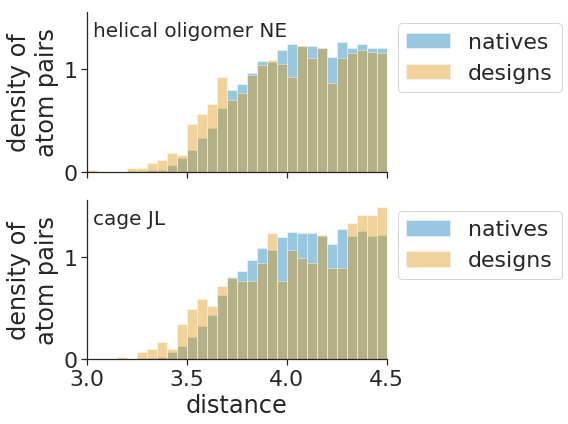

In [24]:
if True:
    pdb_groups = [
        'beta_nov16_natives',
        #'beta_nov16_natives_talaris2014',
        #'beta_nov16_natives_ref2015',
        #'beta_nov16_natives_beta_nov16_cart',
        #'beta_nov16_natives_HH_run18F_step434_cart',
        #'beta_nov16_natives_HH_run18F_step434_designs',
        #'beta_nov16_natives_beta16.nostab-refit_designs',
        #'beta_nov16_natives_beta_nov16_designs',
        #'beta_nov16_natives_HH_run17_step403',
        #'beta_nov16_natives_HH_run17D_step36',
        #'beta_nov16_natives_HH_run18C_step286',
        #'HHH_43aa_beta16.nostab-refit',
        #'3h_1018_beta16.nostab-refit',
        #'EEHEE_43aa_beta16.nostab-refit',
        #'EEHEE_57aa_beta16.nostab-refit',
        #'EHEE_40aa_beta16.nostab-refit',
        #'EHEE_65aa_beta16.nostab-refit',
        #'HEEHE_65aa_beta16.nostab-refit',
        #'HHH_BC', 'ferr_BH', 'NTF2s_CN',
        
        'helical_oligomer_NE', # 'lockr_SL',
        'cage_JL',
        #'NTF2_designs',
        #'NTF2_xtals',
        #'zibo_heterodimers_designs',
        #'zibo_heterodimers_xtals',
        #'derroids_designs',
        #'derroids_xtals',
        #'derroids_xtals_refined',
        #'helical_repeats_designs',
        #'helical_repeats_xtals',
        #'DHR_designs',
        #'DHR_xtals',
    ]
        
natives = pdb_groups[0] #'HH_run17D_natives'
assert 'natives' in natives
if True:
    atom_group = 'hydrophobic_C_C'
    print(atom_group, natives)
else:
    atom_pair = 'Hapo:Hapo' # 'CH3:CH3' # 'CH2:SH1' #
    print(atom_pair, natives)
min_seq_dist = 9
print(pdb_groups)
print("min_seq_dist", min_seq_dist)
data = energies_df[
    #(energies_df['base_pdb_name'].isin(common_pdb_names)) &
    (energies_df['pdb_group'].isin(pdb_groups)) &
    (energies_df['d-o'] < 0.5) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['seq_dist'] >= min_seq_dist) &
    (energies_df[atom_group] == True)
    #(energies_df['atom_pair'] == atom_pair)
].copy()
metric = 'd' # 'd-o'

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'pdb_group', 'cd']
}
min_range = 3.0 #data[metric].min()
max_range = 4.5 #data[metric].max()
nbins = 30
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
for bin_min in bins:
    for pdb_group in pdb_groups:
        if sum(data['pdb_group'] == pdb_group) == 0:
            continue
        cd_dict[metric].append(bin_min)
        cd_dict['pdb_group'].append(pdb_group)
        cd = sum(
            (data['pdb_group'] == pdb_group) &
            (data[metric] <= bin_min)
        ) / sum(data['pdb_group'] == pdb_group)
        cd_dict['cd'].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot data
nrows = len(pdb_groups[1:])
(fig, axs) = plt.subplots(
    ncols=1, nrows=nrows, sharey=True, sharex=True,
    figsize=[8,3*nrows]
)
xlim = [min_range, max_range]
for (i, pdb_group) in enumerate(pdb_groups[1:]):
    
    # Plot data for natives
    data_i = data[data['pdb_group'] == natives]
    kde = True
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label='natives', bins=bins, ax=axs[i]
    )
    
    # Plot data for the group of designs
    data_i = data[data['pdb_group'] == pdb_group]
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label='designs', bins=bins, ax=axs[i]
    )
    if True: #i == 0:
        axs[i].legend(bbox_to_anchor=(1,1))
    axs[i].plot([0, 0], [0, 1.4], ls='--', c='0.25')
    if True:
        if False: # i == 0:
            pdb_group = 'relaxed natives'
        #elif i == 1:
        #    pdb_group = 're-designed natives'
        axs[i].text(
            0.02, 0.85,
            pdb_group.replace(
                '_beta16.nostab-refit', ''
            ).replace(
                '_cart', ''
            ).replace(
                '3h_1018', 'HHH_65aa'
            ).replace(
                'beta_nov16_natives_', ''
            ).replace(
                '_HH_run17_step403', ''
            ).replace(
                'HH_run17_step403', 'run17'
            ).replace(
                '_HH_run18C_step286', ''
            ).replace(
                'HH_run18C_step286', 'run18'
            ).replace(
                '_', ' '
            ),
            transform=axs[i].transAxes, fontsize=20
        )
    if i == nrows - 1:
        axs[i].set(
            ylabel='density of\natom pairs',
            xlabel='distance', # '$d-\sigma$',
            xlim=xlim
        )
    else:
        axs[i].set(
            ylabel='density of\natom pairs',
            xlabel='', xlim=xlim
        )

plt.tight_layout(h_pad=1.0)
sns.despine()
plt.show()

In [21]:
data.sort_values('d-o', ascending=True, inplace=True)
cols = [
    'pdb_name', 'd-o', 'd', 
    'res_i_n', 'res_i_ss', 'res_i_name', 'atom_i_name', 'atom_i_type_name',
    'res_j_n', 'res_j_ss', 'res_j_name', 'atom_j_name', 'atom_j_type_name',
    'lj', 'lj_rep', 'lj_atr', 'fa_solv',
    'pdb_group', 'pdb_name',
    'res_i_pdb_n', 'res_j_pdb_n'
]
data[
    (data['pdb_group'].str.contains('JL'))
][cols].head(n=15)

,pdb_name,d-o,d,res_i_n,res_i_ss,res_i_name,atom_i_name,atom_i_type_name,res_j_n,res_j_ss,...,atom_j_name,atom_j_type_name,lj,lj_rep,lj_atr,fa_solv,pdb_group,pdb_name,res_i_pdb_n,res_j_pdb_n
36472,worms_I53-037_ASU,-0.978345,3.181655,481,H,ILE,CD1,CH3,522,H,...,CD1,CH3,0.958067,1.022067,-0.06400,-0.352953,cage_JL,worms_I53-037_ASU,481,522
39448,worms_I53-037_ASU,-0.899520,3.260480,522,H,LEU,CD2,CH3,577,H,...,CD2,CH3,0.638847,0.702847,-0.06400,-0.352953,cage_JL,worms_I53-037_ASU,522,577
35754,worms_I53-037_ASU,-0.898951,3.261049,474,H,ILE,CD1,CH3,529,H,...,CD1,CH3,0.636934,0.700934,-0.06400,-0.352953,cage_JL,worms_I53-037_ASU,474,529
14402,worms_I53-037_ASU,-0.867686,3.292314,170,H,LEU,CD1,CH3,232,H,...,CD2,CH3,0.539040,0.603040,-0.06400,-0.352953,cage_JL,worms_I53-037_ASU,170,232
10995,worms_I53-037_ASU,-0.857008,3.302992,127,H,LEU,CD1,CH3,229,H,...,CD2,CH3,0.508667,0.572667,-0.06400,-0.352953,cage_JL,worms_I53-037_ASU,127,229
28942,worms_I53-037_ASU,-0.854328,3.305672,369,H,ALA,CB,CH3,414,H,...,CG1,CH3,0.501271,0.565271,-0.06400,-0.352953,cage_JL,worms_I53-037_ASU,369,414
25145,worms_I53-037_ASU,-0.818965,3.341035,319,H,ALA,CB,CH3,364,H,...,CG1,CH3,0.411682,0.475682,-0.06400,-0.352953,cage_JL,worms_I53-037_ASU,319,364
21400,worms_I53-037_ASU,-0.818438,3.341562,269,H,ALA,CB,CH3,314,H,...,CG1,CH3,0.410452,0.474452,-0.06400,-0.352953,cage_JL,worms_I53-037_ASU,269,314
11717,worms_I53-037_ASU,-0.797848,3.362152,134,H,LEU,CD2,CH3,156,H,...,CB,CH3,0.364665,0.428665,-0.06400,-0.352953,cage_JL,worms_I53-037_ASU,134,156
36460,worms_I53-037_ASU,-0.785750,3.374250,481,H,ILE,CG2,CH3,519,H,...,CD2,CH3,0.339698,0.403698,-0.06400,-0.352953,cage_JL,worms_I53-037_ASU,481,519


In [13]:
data[
    #(data['pdb_group'] == 'beta_nov16_natives') &
    (data['pdb_name'].str.contains('1b9o_clean_0001')) &
    (data['res_i_n'] == 27) &
    (data['atom_i_name'] == 'OG1') &
    (data['res_j_n'] == 36) &
    (data['atom_j_name'] == 'CE2')
][cols].head(n=10)

,pdb_name,res_i_n,res_i_ss,res_i_name,atom_i_name,atom_i_type_name,res_j_n,res_j_ss,res_j_name,atom_j_name,atom_j_type_name,d-o,d,lj,lj_rep,lj_atr,fa_solv,pdb_group,pdb_name
287915,1jf8_clean_0001_0001,105,L,THR,OG1,OH,113,H,PHE,CE2,aroC,-0.573712,2.985472,0.263886,0.369422,-0.105536,0.133015,beta_nov16_natives_beta16.nostab-refit_designs,1jf8_clean_0001_0001


In [8]:
data.sort_values('d-o', ascending=True, inplace=True)
cols = [
    'pdb_name',
    'res_i_n', 'res_i_ss', 'res_i_name', 'atom_i_name', 'atom_i_type_name',
    'res_j_n', 'res_j_ss', 'res_j_name', 'atom_j_name', 'atom_j_type_name',
    'd-o', 'd', 'lj', 'lj_rep', 'lj_atr', 'fa_solv',
    'pdb_group', 'pdb_name',
    'res_i_pdb_n', 'res_j_pdb_n'
]
data[
    (data['pdb_group'].str.contains('zibo'))
][cols].head(n=15)

,pdb_name,res_i_n,res_i_ss,res_i_name,atom_i_name,atom_i_type_name,res_j_n,res_j_ss,res_j_name,atom_j_name,...,d-o,d,lj,lj_rep,lj_atr,fa_solv,pdb_group,pdb_name,res_i_pdb_n,res_j_pdb_n
13561,DHD_127,16,H,LEU,1HB,Hapo,61,H,VAL,1HG2,...,-0.796265,2.046279,0.812560,0.834368,-0.021808,0.0,zibo_heterodimers_designs,DHD_127,16,61
5327,DHD_131_xtal_6DKM,70,H,LEU,2HB,Hapo,87,H,LEU,1HD2,...,-0.761783,2.080761,0.637872,0.659680,-0.021808,0.0,zibo_heterodimers_xtals,DHD_131_xtal_6DKM,69,87
1979,DHD_131,23,H,LEU,2HB,Hapo,54,H,ILE,3HG2,...,-0.749752,2.092792,0.585921,0.607729,-0.021808,0.0,zibo_heterodimers_designs,DHD_131,23,54
2793,DHD_131,31,H,ILE,3HG2,Hapo,125,H,LEU,2HB,...,-0.742051,2.100493,0.554820,0.576628,-0.021808,0.0,zibo_heterodimers_designs,DHD_131,31,125
2603,DHD_131,30,H,LEU,1HB,Hapo,51,H,LEU,1HD2,...,-0.737384,2.105160,0.536740,0.558548,-0.021808,0.0,zibo_heterodimers_designs,DHD_131,30,51
4757,DHD_131,55,H,LEU,2HB,Hapo,101,H,LEU,3HD1,...,-0.736660,2.105884,0.533987,0.555795,-0.021808,0.0,zibo_heterodimers_designs,DHD_131,55,101
15327,DHD_127,33,H,VAL,2HG1,Hapo,39,L,VAL,3HG2,...,-0.734812,2.107732,0.527016,0.548824,-0.021808,0.0,zibo_heterodimers_designs,DHD_127,33,39
8019,DHD_131,93,H,VAL,HB,Hapo,138,H,LEU,3HD1,...,-0.732635,2.109909,0.518918,0.540726,-0.021808,0.0,zibo_heterodimers_designs,DHD_131,93,138
927,DHD_131,10,H,VAL,1HG2,Hapo,150,H,LEU,1HB,...,-0.713143,2.129401,0.451455,0.473263,-0.021808,0.0,zibo_heterodimers_designs,DHD_131,10,150
12623,DHD_127,6,H,LEU,2HD2,Hapo,142,H,LEU,2HD2,...,-0.700984,2.141560,0.413628,0.435436,-0.021808,0.0,zibo_heterodimers_designs,DHD_127,6,142


**Observations**
* What accounts for large differences in H packing in Zibo's designs?
    * rotamer change; atom pair may no longer be coutned
    * large shift of ~0.7 A

Analyze clashes across chains

In [10]:
atom_group = 'hydrophobic_C_C' # 'C_Obb' # 
data = energies_df[
    (energies_df['pdb_group'] == 'helical_oligomer_NE') &
    (energies_df['pdb_name'] == 'C8-79-10-5') &
    (energies_df['res_i_chain'] != energies_df['res_j_chain']) &
    (energies_df['res_i_chain'].isin(['A', 'B',])) &
    (energies_df['res_j_chain'].isin(['A', 'B',])) &
    (energies_df[atom_group])
].copy()

In [11]:
data.sort_values('d-o', ascending=True, inplace=True)
cols = [
    'pdb_name', 'd-o', 'd',
    'res_i_chain', 'res_i_pdb_n', 'res_i_name', 'atom_i_name', 
    'res_j_chain', 'res_j_pdb_n', 'res_j_name', 'atom_j_name',
    #'lj', 'lj_rep', 'lj_atr', 'fa_solv',
    #'pdb_group', 'pdb_name',
]
print(atom_group)
data[cols].head(n=10)

hydrophobic_C_C


,pdb_name,d-o,d,res_i_chain,res_i_pdb_n,res_i_name,atom_i_name,res_j_chain,res_j_pdb_n,res_j_name,atom_j_name
145446,C8-79-10-5,-0.848248,3.311752,A,192,LEU,CD1,B,41,VAL,CG1
144635,C8-79-10-5,-0.807178,3.317822,A,185,PHE,CD1,B,45,ILE,CG2
144680,C8-79-10-5,-0.735298,3.282572,A,185,PHE,CE1,B,46,TRP,CE2
144644,C8-79-10-5,-0.678750,3.339120,A,185,PHE,CD1,B,46,TRP,CE2
144491,C8-79-10-5,-0.636230,3.488770,A,184,LEU,CD1,B,52,TRP,CE3
144642,C8-79-10-5,-0.582297,3.435573,A,185,PHE,CD1,B,46,TRP,CD2
144492,C8-79-10-5,-0.573233,3.551767,A,184,LEU,CD1,B,52,TRP,CZ3
144498,C8-79-10-5,-0.552138,3.607862,A,184,LEU,CD1,B,53,LEU,CD2
144646,C8-79-10-5,-0.519590,3.570410,A,185,PHE,CD1,B,46,TRP,CZ2
146089,C8-79-10-5,-0.498970,3.553900,A,201,TRP,CE2,B,22,ILE,CG2


In [11]:
pdbs = list(data['pdb_file'][:10])
new_pdb_dir = 'results/pdbs_with_clashes/'
design_utils.copy_pdbs(pdbs=pdbs, new_pdb_dir=new_pdb_dir)

**Observations**:
* CH3:OCbb
    * O in loop, CH3 in H or S close in 3D space, but not immediately adjacent in primary sequence (0437, 0150, 0063)
    * O in strand, CH3 in H (0301)

Plot data for subgroups

In [ ]:
data = energies_df[
    energies_df['pdb_group'].str.contains('zibo')
].copy()
data['design_or_xtal'] = data['pdb'].apply(
    lambda x: 'xtal' if 'xtal' in x else 'design'
)
data = data[data['design_or_xtal'] == 'xtal']

In [4]:
data = energies_df[
    energies_df['pdb_group'].str.contains('zibo')
].copy()

In [5]:
data['design_or_xtal'] = data['pdb'].apply(
    lambda x: 'xtal' if 'xtal' in x else 'design'
)

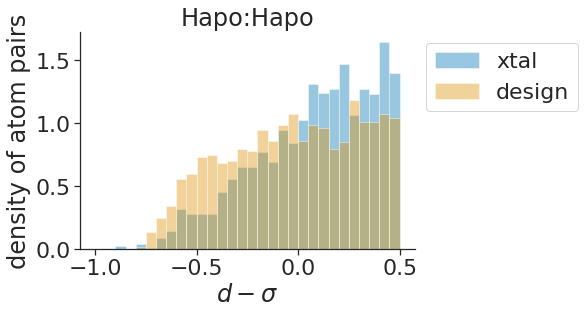

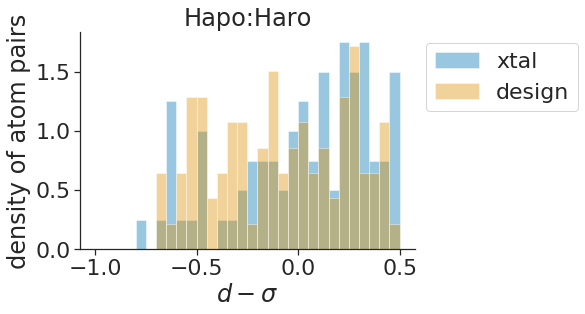

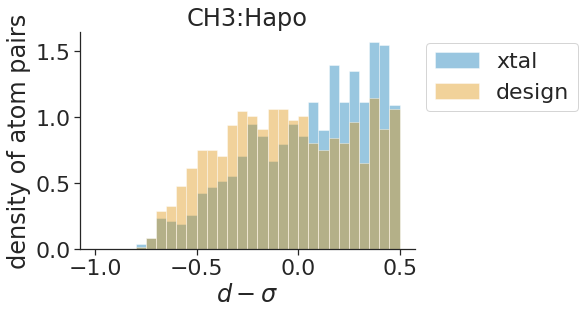

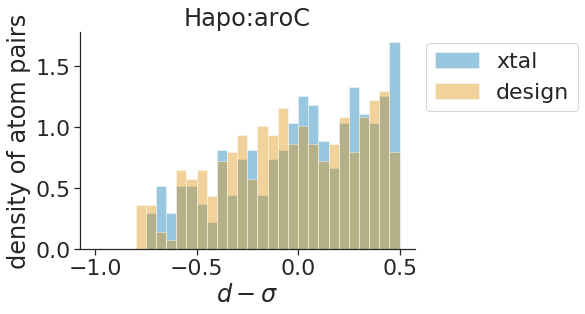

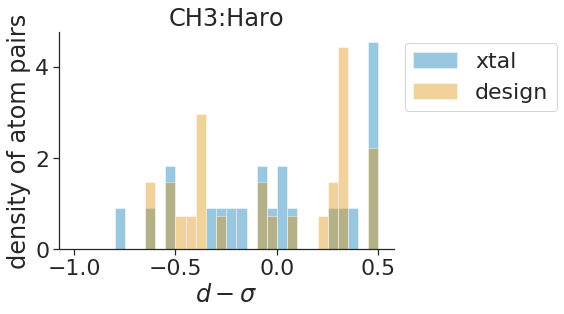

/home/haddox/.conda/envs/high_throughput_design_for_E_function_opt/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/haddox/.conda/envs/high_throughput_design_for_E_function_opt/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/haddox/.conda/envs/high_throughput_design_for_E_function_opt/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


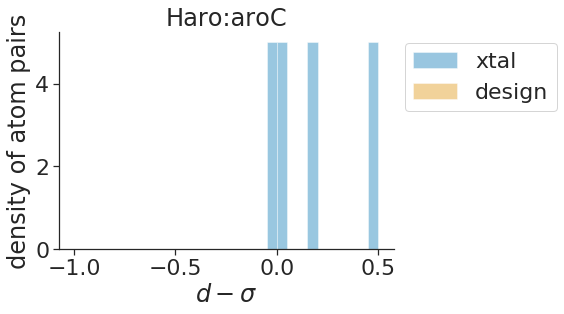

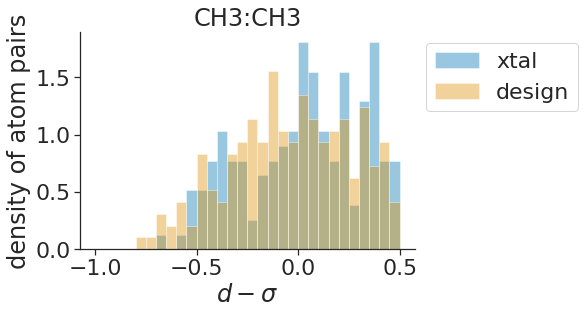

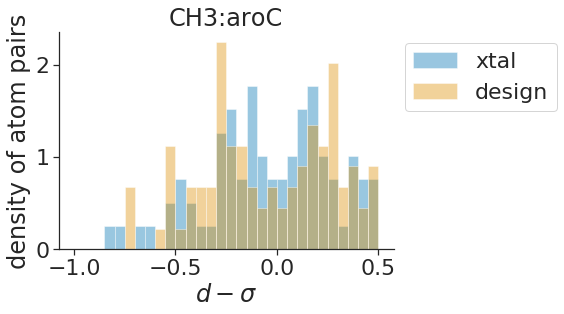

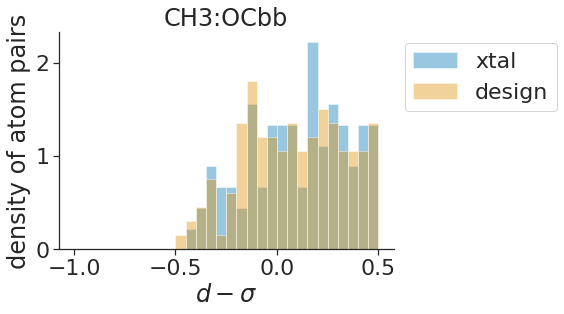

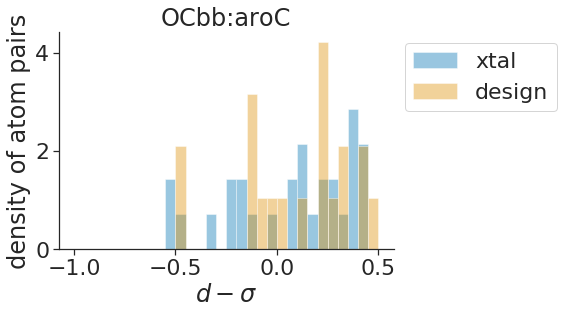

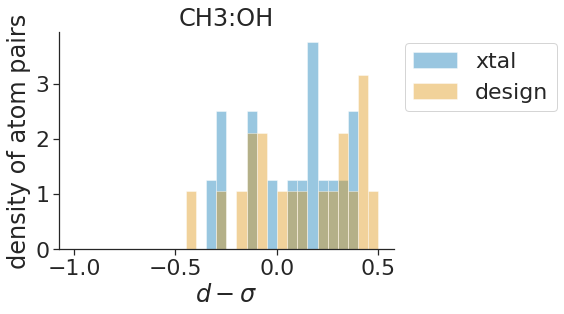

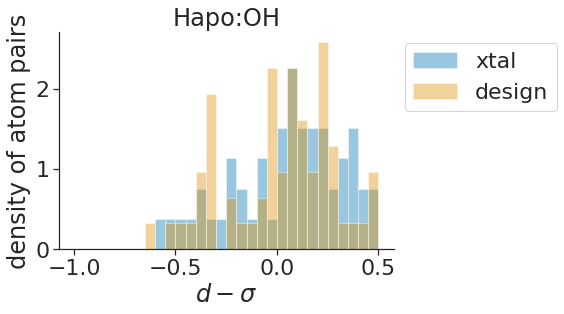

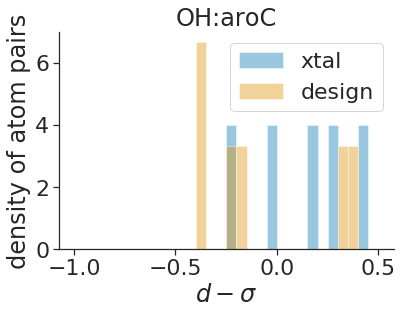

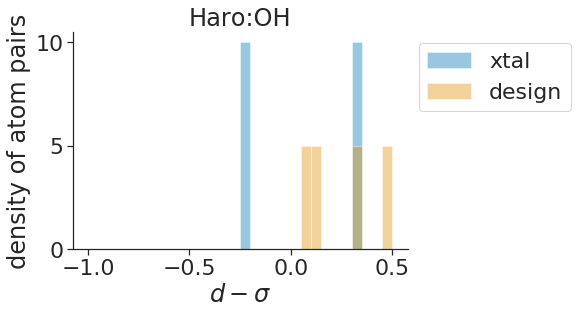

In [6]:
min_range = -1.0 #data[metric].min()
max_range = 0.5 #data[metric].max()
nbins = 30
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
atom_pairs = [
    'Hapo:Hapo', 'Hapo:Haro',
    'CH3:Hapo', 'Hapo:aroC',
    'CH3:Haro', 'Haro:aroC',
    'CH3:CH3', 'CH3:aroC',
    'CH3:OCbb', 'OCbb:aroC',
    'CH3:OH', 'Hapo:OH',
    'OH:aroC', 'Haro:OH'
]
for atom_pair in atom_pairs:
    for design_or_xtal in ['xtal', 'design']:
        data_i = data[
            (data['atom_pair'] == atom_pair) &
            (data['design_or_xtal'] == design_or_xtal)
        ]
        sns.distplot(
            data_i['d-o'], bins=bins, kde=False, norm_hist=True,
            label=design_or_xtal
        )

    plt.title(atom_pair)
    plt.ylabel('density of atom pairs')
    plt.xlabel('$d - \sigma$')
    plt.legend(bbox_to_anchor=(1,1))
    sns.despine()
    plt.show()

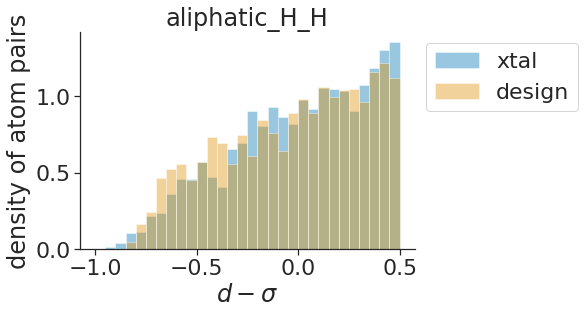

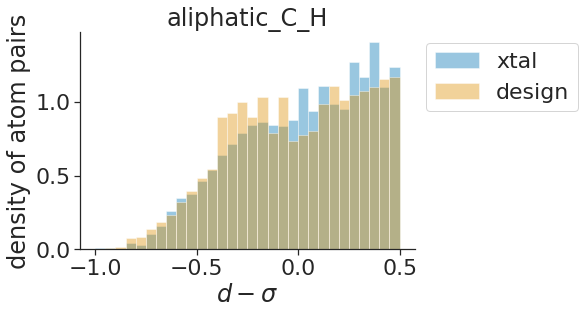

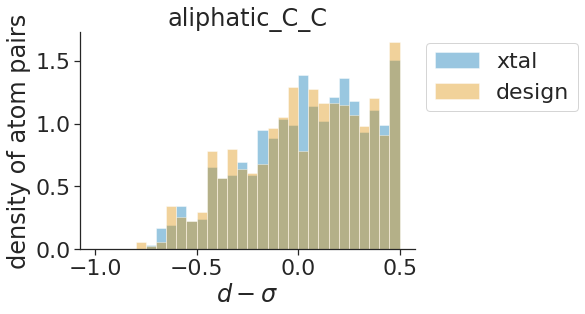

In [11]:
min_range = -1.0 #data[metric].min()
max_range = 0.5 #data[metric].max()
nbins = 30
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
cols = ['aliphatic_H_H', 'aliphatic_C_H', 'aliphatic_C_C']
for col in cols:
    for design_or_xtal in ['xtal', 'design']:
        data_i = data[
            (data[col] == True) &
            (data['design_or_xtal'] == design_or_xtal)
        ]
        sns.distplot(
            data_i['d-o'], bins=bins, kde=False, norm_hist=True,
            label=design_or_xtal
        )

    plt.title(col)
    plt.ylabel('density of atom pairs')
    plt.xlabel('$d - \sigma$')
    plt.legend(bbox_to_anchor=(1,1))
    sns.despine()
    plt.show()

In [10]:
data.head()

,res_j_n,res_j_pdb_n,res_j_name,res_j_ss,atom_j_n,atom_j_name,atom_j_type_name,atom_j_bb,lj_atr,lj_rep,...,aliphatic_C_C,aliphatic_H_H,aliphatic_C_H,pdb_file,pdb,pair_id,pdb_group,pdb_name,base_pdb_name,design_or_xtal
0,2,1,PRO,H,1,N,Npro,True,-0.161725,4.682456,...,False,False,False,data/zibo_heterodimers/DHD_127_xtal_6DLM.pdb,DHD_127_xtal_6DLM.pdb,1_1_2_1_DHD_127_xtal_6DLM.pdb,zibo_heterodimers,DHD_127_xtal_6DLM,DHD_127_xtal_6DLM,xtal
1,2,1,PRO,H,2,CA,CAbb,True,-0.087951,0.000000,...,False,False,False,data/zibo_heterodimers/DHD_127_xtal_6DLM.pdb,DHD_127_xtal_6DLM.pdb,1_1_2_2_DHD_127_xtal_6DLM.pdb,zibo_heterodimers,DHD_127_xtal_6DLM,DHD_127_xtal_6DLM,xtal
2,2,1,PRO,H,6,CG,CH2,False,-0.091857,0.000000,...,False,False,False,data/zibo_heterodimers/DHD_127_xtal_6DLM.pdb,DHD_127_xtal_6DLM.pdb,1_1_2_6_DHD_127_xtal_6DLM.pdb,zibo_heterodimers,DHD_127_xtal_6DLM,DHD_127_xtal_6DLM,xtal
3,2,1,PRO,H,7,CD,CH2,False,-0.100652,10.924601,...,False,False,False,data/zibo_heterodimers/DHD_127_xtal_6DLM.pdb,DHD_127_xtal_6DLM.pdb,1_1_2_7_DHD_127_xtal_6DLM.pdb,zibo_heterodimers,DHD_127_xtal_6DLM,DHD_127_xtal_6DLM,xtal
4,2,1,PRO,H,14,1HD,Hapo,False,-0.059388,1.582730,...,False,False,False,data/zibo_heterodimers/DHD_127_xtal_6DLM.pdb,DHD_127_xtal_6DLM.pdb,1_1_2_14_DHD_127_xtal_6DLM.pdb,zibo_heterodimers,DHD_127_xtal_6DLM,DHD_127_xtal_6DLM,xtal


In [7]:
clashes_dict = {
    key : []
    for key in ['pdb_group', 'pdb', 'n_clashes']
}

for pdb_group in pdb_groups:
    data_i = data[data['pdb_group'] == pdb_group].copy()
    pdbs = set(data_i['pdb'])
    for pdb in pdbs:
        clashes_dict['pdb_group'].append(pdb_group)
        clashes_dict['pdb'].append(pdb)
        clashes_dict['n_clashes'].append(sum(data_i[
            data_i['pdb'] == pdb
        ]['d-o'] < -0.5))
    
clashes_df = pandas.DataFrame(clashes_dict)
clashes_df.head()

,pdb_group,pdb,n_clashes
0,beta_nov16_natives,1w0n_clean_0001.pdb,0
1,beta_nov16_natives,1d4t_clean_0001.pdb,0
2,beta_nov16_natives,1mc2_clean_0001.pdb,0
3,beta_nov16_natives,1zuu_clean_0001.pdb,0
4,beta_nov16_natives,1zlm_clean_0001.pdb,0


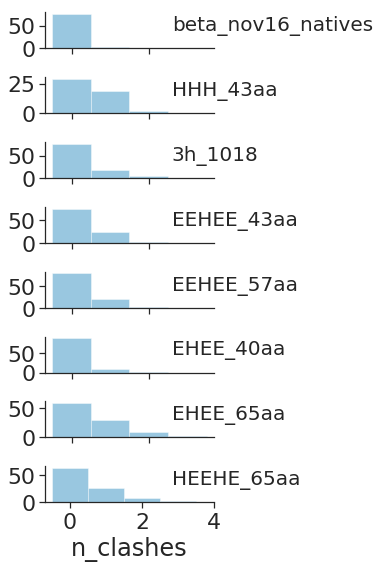

In [8]:
min_range = clashes_df['n_clashes'].min()
max_range = clashes_df['n_clashes'].max()
bins = np.arange(min_range-0.5, max_range+0.5, 1)
nrows = len(pdb_groups)
(fig, axs) = plt.subplots(
    ncols=1, nrows=nrows, figsize=[5,1*nrows],
    sharex=True
)
xticks = np.arange(0, max_range+2, 2)
for (i, pdb_group) in enumerate(pdb_groups):
    data_i = clashes_df[clashes_df['pdb_group'] == pdb_group].copy()
    sns.distplot(
        data_i['n_clashes'], label=pdb_group, kde=False,
        bins=bins, ax=axs[i]
    )
    axs[i].text(
        0.75, 0.5,
        pdb_group.replace(
            '_beta16.nostab-refit', ''
        ).replace('_HH_run17D_step36', ''),
        transform=axs[i].transAxes, fontsize=20
    )
    axs[i].set(xticks=xticks)
    if i != len(pdb_groups) - 1:
        axs[i].set(xlabel='')

plt.tight_layout()
sns.despine()
plt.show()

In [41]:
import importlib
pyrosetta = importlib.reload(pyrosetta)

In [42]:
pyrosetta.init()

In [47]:
pyrosetta.init('@../optE_eval/data/HH_run18C_flags_286')

In [46]:
sf = pyrosetta.create_score_function(
    '../optE_eval/data/HH_run18C_weights_286.wts'
)

Compute for natives, with an expanded range of distances

In [2]:
pdb_dirs = {
    'beta_nov16_natives': \
        '/home/dimaio/optE2/dualoptE/decoys/xtal_refine_beta16/',
    'beta_nov16_natives_HH_run17_step403': os.path.join(
        '/home/haddox/2019/optE_eval_dist/results/',
        'beta_nov16_natives/HH_run17_step403/relax_w_out_symm/'
    )
}
for (pdb_group, pdb_dir) in pdb_dirs.items():
    pdb_files = glob.glob(os.path.join(pdb_dir, '*.pdb'))
    output_dir = os.path.join(
        resultsdir,
        'atom_pair_energies_expanded',
        pdb_group
    )
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    for pdb_file in pdb_files:
        pdb_basename = os.path.basename(pdb_file).replace('.pdb', '')
        output_file = os.path.join(output_dir, f'{pdb_basename}.csv')
        cmd = [
            'python',
            'scripts/compute_energies_between_atom_pairs.py',
            f'--pdb_file {pdb_file}',
            f'--output_file {output_file}',
            '--expanded_dist_cutoff'
        ]
        cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
            + ' '.join(cmd)
        sbatch_file = os.path.join(output_dir,f'{pdb_basename}.sbatch')
        if not os.path.isfile(sbatch_file):
            design_utils.WriteSbatchFile(
                sbatch_file,
                command=cmd,
                queue_type='short',
                memory='10g'
            )
            ! sbatch {sbatch_file}

Read in data involving all atom-atom interactions within 6A

In [2]:
pdb_groups = [
    #'beta_nov16_natives',
    'beta_nov16_natives_HH_run17_step403'
]
dfs = []
for pdb_group in pdb_groups:
    
    # Read in a set of curated data from a file if it is present,
    # otherwise, creat the file and then read in the data
    all_energies_file = os.path.join(
        resultsdir,
        'atom_pair_energies_expanded',
        pdb_group,
        'all_energies.csv'
    )
    if not os.path.isfile(all_energies_file):
    
        # Otherwise, create the file with curated data
        energies_files = glob.glob(os.path.join(
            resultsdir,
            'atom_pair_energies_expanded',
            pdb_group,
            '*.csv'
        ))
        pdb_group_dfs = []
        for energies_file in energies_files:
            df = pandas.read_csv(energies_file)
            df['pdb_group'] = pdb_group
            energies_file_basename = \
                os.path.basename(energies_file).replace('.csv', '')
            df['pdb_name'] = energies_file_basename
            df.to_csv(all_energies_file, index=False)
            pdb_group_dfs.append(df)
        df = pandas.concat(pdb_group_dfs)
        dfs.append(df)
        df.to_csv(all_energies_file, index=False)
        
    else:
        df = pandas.read_csv(all_energies_file)
        dfs.append(df)
        
exp_es_df = pandas.concat(dfs)
exp_es_df['atom_pair'] = exp_es_df.apply(
    lambda row: ':'.join(sorted([
        row['atom_i_type_name'], row['atom_j_type_name']
    ])),
    axis=1
)

In [3]:
exp_es_df['atom_i_bb'] = (exp_es_df['atom_i_name'].isin([
    'N', 'C', 'CA', 'H', 'HA', 'O'
]))
exp_es_df['atom_j_bb'] = (exp_es_df['atom_j_name'].isin([
    'N', 'C', 'CA', 'H', 'HA', 'O'
]))

In [8]:
e_terms = ['fa_solv', 'fa_elec', 'lj_energy', 'rosetta_lj_energy']
e_dict = {
    key : []
    for key in [
        'd-o', 'atom_pair'
    ] + e_terms
}
d_os = np.arange(-0.8, 2, 0.01)
atom_pairs = [
    #'CH3:CH3', 'CH2:CH3', 'CH1:CH3', 'CAbb:CH3'
    #'CH3:Hapo', 'CH3:CH3', 'CH2:CH3'
    #'CH3:OCbb', 'CH3:CObb'
    #'CH1:Hapo', 'CH1:CH2'
    
]
dist_corr_dict = {
    #'CH3:OCbb' : 0,
    #'CH3:CObb' : 1.2,
    #'Hapo:OCbb' : 0,
    'CH3:Hapo' : 0,
    'CH3:CH3' : 1.1
    #'CH2:Hapo' : 0,
    #'CH3:CH3' : 0,
    #'CH2:CH3' : 1.5,
    #'CH2:CH2' : 1.1,
    #'CH1:CH2' : 1.1,
    #'CH1:CH3' : 1.5,
    #'CAbb:CH3' : 1.5
}
aas = ['ALA', 'VAL', 'ILE', 'LEU']
for atom_pair in dist_corr_dict.keys():
    data = exp_es_df[
        (exp_es_df['res_i_n'] != exp_es_df['res_j_n']) &
        (exp_es_df['res_i_name'].isin(aas)) &
        (exp_es_df['res_j_name'].isin(aas)) &
        (exp_es_df['atom_pair'] == atom_pair) &
        (exp_es_df['d'] <= 6)
    ].copy()
    o = list(set(data['o']))
    assert len(o) == 1, o
    o = o[0]
    for d_o in d_os:
        d_o_corrected = d_o + dist_corr_dict[atom_pair]
        data['delta_d'] = data['d-o'] - d_o_corrected
        data['delta_d'] = data['delta_d'].abs()
        data.sort_values('delta_d', inplace=True, ascending=True)
        e_dict['d-o'].append(d_o)
        e_dict['atom_pair'].append(atom_pair)
        for e_term in e_terms:
            e_dict[e_term].append(data[e_term].iloc[0])
    
e_df = pandas.DataFrame(e_dict)
e_df['lj'] = e_df['lj_energy']
e_df['total_e'] = e_df['fa_solv'] + e_df['lj']# + e_df['fa_elec']

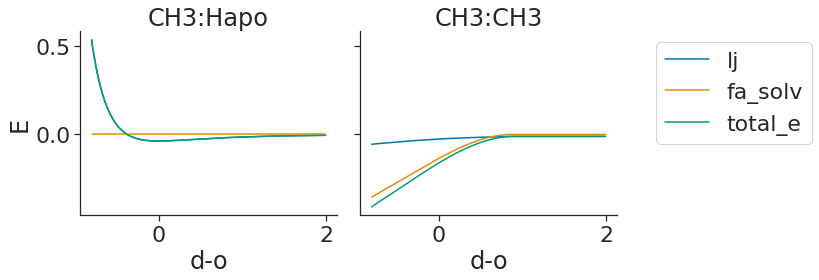

In [9]:
es_to_plot = ['lj', 'fa_solv', 'fa_elec', 'total_e']
es_to_plot = ['lj', 'fa_solv', 'total_e']
atom_pairs = [
    #'CH3:OCbb', 'Hapo:OCbb'
    #'CH3:OCbb', 'CH3:CObb'
    'CH3:Hapo', 'CH3:CH3'
]
(fig, axs) = plt.subplots(ncols=2, sharey=True, figsize=[12,4])
for (i, atom_pair) in enumerate(atom_pairs):
    for e in es_to_plot:
        data = e_df[e_df['atom_pair'] == atom_pair]
        sns.lineplot(
            x='d-o', y=e, data=data, label=e, ax=axs[i]
        )
    axs[i].set(title=atom_pair)
    if i == 0:
        axs[i].get_legend().remove()

axs[0].set(ylabel='E')
plt.legend(bbox_to_anchor=(1.8,1))
plt.tight_layout()
sns.despine()
plt.show()

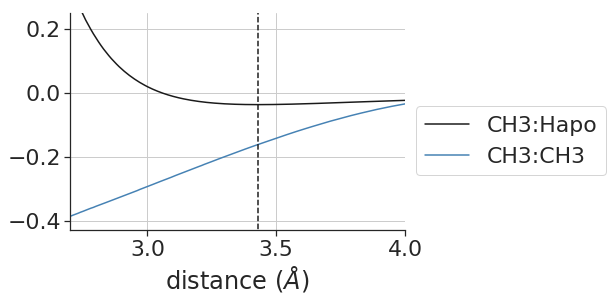

In [47]:
atom_pairs = [
    #'CH3:OCbb', 'Hapo:OCbb'#'CH3:CObb'
    'CH3:Hapo', 'CH3:CH3'
]
data_i = e_df[e_df['atom_pair'] == atom_pairs[0]].copy()
data_j = e_df[e_df['atom_pair'] == atom_pairs[1]].copy()
data_i.rename(columns={'total_e':atom_pairs[0]}, inplace=True)
data_j.rename(columns={'total_e':atom_pairs[1]}, inplace=True)
data = data_i[['d-o', atom_pairs[0]]].merge(
    data_j[['d-o', atom_pairs[1]]], on='d-o'
)
data['total'] = data[atom_pairs[0]] + data[atom_pairs[1]]
o = 2.01 + 1.42
data['d-o'] = data['d-o'] + o

es_to_plot = atom_pairs# + ['total']
cs = ['k', 'steelblue', 'firebrick']
for (i, e) in enumerate(es_to_plot):
    sns.lineplot(
        x='d-o', y=e, data=data, label=e, color=cs[i]
    )

d_o_min = data.sort_values('total').iloc[0]['d-o']
plt.plot(
    [o, o], [-0.5, 0.5], ls='--', c='k'
)
if False:
    plt.plot(
        [d_o_min, d_o_min], [-0.5, 0.5], ls='--', c='firebrick'
    )
    
plt.grid()
plt.legend(bbox_to_anchor=(1.0,0.62))
plt.xlim([2.7, 4.0])
plt.ylim([-0.43, 0.25])
plt.ylabel('')
plt.xlabel('distance $({\AA})$')
#plt.xticks([-0.5, 0, 0.5])
sns.despine()
plt.show()

In [172]:
cols = [
    'pdb_name',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'd-o', 'd', 'lj_energy', 'lj_rep', 'lj_atr', 'fa_solv'
]
aas = ['ALA', 'VAL', 'ILE', 'LEU']
data = exp_es_df[
    (exp_es_df['atom_pair'] == 'CH3:Narg') &
    #(exp_es_df['res_i_name'].isin(aas)) &
    #(exp_es_df['res_j_name'].isin(aas)) &
    (exp_es_df['d-o'].between(0.2, 0.3))
]
data[cols].head()

,pdb_name,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,d-o,d,lj_energy,lj_rep,lj_atr,fa_solv
274723,2jek_clean_0001_0001,25,ALA,CB,29,ARG,NH1,0.277613,4.091825,-0.088743,0.0,-0.088743,0.093872
289227,2jek_clean_0001_0001,48,LEU,CD2,51,ARG,NH1,0.225139,4.039351,-0.092120,0.0,-0.092120,0.098457
298333,2jek_clean_0001_0001,68,LEU,CD2,72,ARG,NH2,0.221685,4.035897,-0.092333,0.0,-0.092333,0.098766
707728,2i4a_clean_0001_0001,82,ARG,NH2,106,ALA,CB,0.234533,4.048745,-0.091535,0.0,-0.091535,0.097621
726500,2g6f_clean_0001_0001,21,LEU,CD2,47,ARG,NH1,0.286766,4.100978,-0.088131,0.0,-0.088131,0.093093


In [179]:
data = exp_es_df[
    (exp_es_df['pdb_name'] == '2i4a_clean_0001_0001') &
    (exp_es_df['res_i_n'] == 82) &
    (exp_es_df['res_j_n'] == 106) &
    #(exp_es_df['atom_i_name'].str.contains('N')) &
    #(exp_es_df['atom_i_name'].isin(['O'])) &
    #(exp_es_df['atom_j_name'].str.contains('B'))
    ~(exp_es_df['atom_i_bb']) &
    ~(exp_es_df['atom_j_bb'])
]

In [180]:
cols = [
    'pdb_name',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'd-o', 'd',
    'lj_energy', 'fa_solv', 'fa_elec'
]
data[cols]

,pdb_name,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,d-o,d,lj_energy,fa_solv,fa_elec
707609,2i4a_clean_0001_0001,82,ARG,CB,106,ALA,1HB,2.500830,5.933862,-0.002720,0.000000,0.000000
707645,2i4a_clean_0001_0001,82,ARG,CD,106,ALA,1HB,2.056114,5.489146,-0.004292,0.000000,0.000003
707663,2i4a_clean_0001_0001,82,ARG,NE,106,ALA,CB,1.676417,5.490629,-0.021352,0.004991,0.000017
707664,2i4a_clean_0001_0001,82,ARG,NE,106,ALA,1HB,1.256873,4.480597,-0.015333,0.000000,-0.043000
707665,2i4a_clean_0001_0001,82,ARG,NE,106,ALA,3HB,2.409318,5.633042,-0.004099,0.000000,0.000000
707680,2i4a_clean_0001_0001,82,ARG,CZ,106,ALA,CB,0.494756,4.522957,-0.049164,-0.139851,-0.124100
707682,2i4a_clean_0001_0001,82,ARG,CZ,106,ALA,1HB,0.145350,3.583063,-0.036853,0.000000,0.125230
707683,2i4a_clean_0001_0001,82,ARG,CZ,106,ALA,2HB,1.865472,5.303185,-0.005534,0.000000,0.002443
707684,2i4a_clean_0001_0001,82,ARG,CZ,106,ALA,3HB,1.181035,4.618748,-0.012049,0.000000,0.035534
707699,2i4a_clean_0001_0001,82,ARG,NH1,106,ALA,CB,0.712162,4.526374,-0.059171,0.062851,0.139098


In [181]:
for col in ['lj_energy', 'fa_solv', 'fa_elec']:
    print(col, sum(data[col]))

lj_energy -0.47788500883722645
fa_solv 0.025612027064612908
fa_elec 0.021469076232660235


* CH3:CH3
    * electrostatics are usually positive, but small
    * the above is true for CH3s with d-o of 0 and d-o of -0.5
* CH3:OCbb: electrostatics help favor clashing

In [139]:
aas = ['ALA', 'VAL', 'ILE', 'LEU']
data = exp_es_df[
    #(exp_es_df['pdb_name'] == '1x6x_clean_0001') &
    (exp_es_df['res_i_name'].isin(aas)) &
    (exp_es_df['res_j_name'].isin(aas)) &
    ~(exp_es_df['atom_i_bb']) &
    ~(exp_es_df['atom_j_bb'])
]

In [140]:
data[cols].head()

,pdb_name,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,d-o,d,lj_energy,fa_solv,fa_elec
2074,1i2t_clean_0001_0001,4,ALA,CB,5,LEU,CB,1.248924,5.272444,-0.022300,-0.018659,0.005797
2075,1i2t_clean_0001_0001,4,ALA,CB,5,LEU,CG,1.135015,5.158535,-0.025033,0.027007,0.006225
2076,1i2t_clean_0001_0001,4,ALA,CB,5,LEU,CD2,1.606550,5.630070,-0.015578,-0.028666,0.000000
2079,1i2t_clean_0001_0001,4,ALA,CB,5,LEU,1HB,1.985179,5.418211,-0.004628,0.000000,-0.000397
2080,1i2t_clean_0001_0001,4,ALA,CB,5,LEU,HG,0.832205,4.265237,-0.017367,0.000000,-0.052379


In [141]:
for col in ['lj_energy', 'fa_solv', 'fa_elec']:
    print(col, sum(data[col]))

lj_energy -1403.3182178203554
fa_solv -1297.7860701754134
fa_elec 22.128971643613813


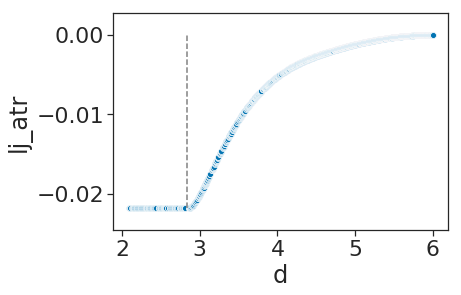

In [46]:
o = 2 * 1.421272
data = energies_df[
    (energies_df['pdb']==pdb) &
    #(energies_df['res_i_n'] == res_i_n) &
    #(energies_df['res_j_n'] == res_j_n) &
    #(energies_df['atom_i_name'] == atom_i_name) &
    #(energies_df['atom_j_name'] == atom_j_name)
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['atom_i_type_name'].str.contains('Hapo')) &
    (energies_df['atom_j_type_name'].str.contains('Hapo')) &
    (energies_df['lj_atr'] <= 0) &
    (energies_df['d'] <= 6)
].sort_values('d')[cols]
sns.scatterplot(x='d', y='lj_atr', data=data)
plt.plot(
    [o,o], [data['lj_atr'].min(), data['lj_atr'].max()],
    c='0.5', ls='--'
)
plt.show()

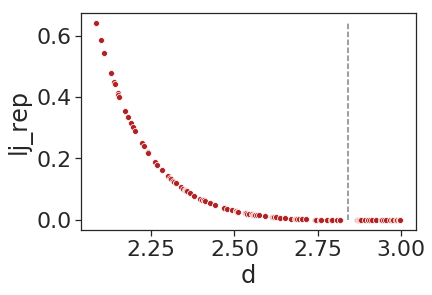

In [47]:
data = energies_df[
    (energies_df['pdb']==pdb) &
    #(energies_df['res_i_n'] == res_i_n) &
    #(energies_df['res_j_n'] == res_j_n) &
    #(energies_df['atom_i_name'] == atom_i_name) &
    #(energies_df['atom_j_name'] == atom_j_name)
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['atom_i_type_name'].str.contains('Hapo')) &
    (energies_df['atom_j_type_name'].str.contains('Hapo')) &
    (energies_df['lj_rep'] >= 0) &
    (energies_df['d'] <= 3)
].sort_values('d')[cols]
sns.scatterplot(x='d', y='lj_rep', data=data, color='firebrick')
plt.plot(
    [o,o], [data['lj_rep'].min(), data['lj_rep'].max()],
    c='0.5', ls='--'
)
plt.show()

(2.5, 3.5)

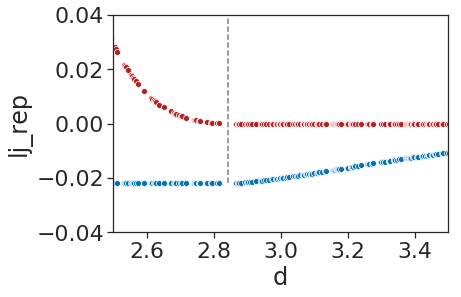

In [48]:
o = 2 * 1.421272
data = energies_df[
    (energies_df['pdb']==pdb) &
    #(energies_df['res_i_n'] == res_i_n) &
    #(energies_df['res_j_n'] == res_j_n) &
    #(energies_df['atom_i_name'] == atom_i_name) &
    #(energies_df['atom_j_name'] == atom_j_name)
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['atom_i_type_name'].str.contains('Hapo')) &
    (energies_df['atom_j_type_name'].str.contains('Hapo')) &
    (energies_df['lj_atr'] <= 0)
].sort_values('d')[cols]
sns.scatterplot(x='d', y='lj_atr', data=data)

data = energies_df[
    (energies_df['pdb']==pdb) &
    #(energies_df['res_i_n'] == res_i_n) &
    #(energies_df['res_j_n'] == res_j_n) &
    #(energies_df['atom_i_name'] == atom_i_name) &
    #(energies_df['atom_j_name'] == atom_j_name)
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['atom_i_type_name'].str.contains('Hapo')) &
    (energies_df['atom_j_type_name'].str.contains('Hapo')) &
    (energies_df['lj_rep'] >= 0)
].sort_values('d')[cols]
sns.scatterplot(x='d', y='lj_rep', data=data, color='firebrick')

plt.plot(
    [o,o], [data['lj_atr'].min(), data['lj_rep'].max()],
    c='0.5', ls='--'
)

plt.ylim([-0.04, 0.04])
plt.xlim([2.5, 3.5])

Text(0, 0.5, 'cumulative density')

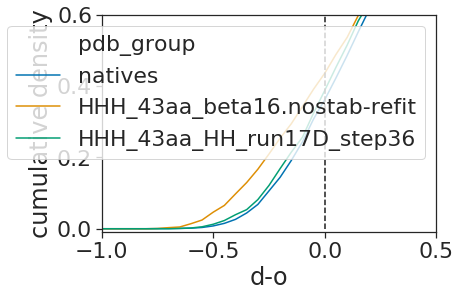

In [22]:
# ... first plotting the cumulative density
hue_order = pdb_groups
sns.lineplot(
    x=metric, y='cd', data=cd_df, hue='pdb_group'
)
plt.plot([0, 0], [0, 0.6], ls='--', c='k')
plt.ylim([-0.01, 0.6])
plt.xlim(xlim)
plt.ylabel('cumulative density')

Plot data for individual designs

In [19]:
pdb_name = 'HHH_rd4_0216_wt'
pdb_groups = [
    'beta_nov16_natives',
    'lowest_energy_decoys_cart'
]
natives = pdb_groups[0] #'HH_run17D_natives'
assert 'natives' in natives
data = energies_df[
    (energies_df['pdb_group'].isin(pdb_groups)) &
    (
        (energies_df['pdb_group'] == natives) |
        (energies_df['pdb_name'] == pdb_name)
    ) &
    (energies_df['d-o'] < -0.5) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    ~(energies_df['both_atoms_bb']) &
    ~(energies_df['atom_i_bb']) &
    ~(energies_df['atom_j_bb'])
    
].copy()
data.sort_values('d-o', ascending=True, inplace=True)
cols = [
    'pdb_name',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'd-o', 'lj_energy'
]
res_ns = [21, 39]
data[
    ((data['res_i_n'].isin(res_ns)) &
    (data['res_j_n'].isin(res_ns))) &
    (data['pdb_group'].str.contains('decoys'))
][cols].head(n=20)

,pdb_name,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,d-o,lj_energy
14011,HHH_rd4_0216_wt,21,ILE,CG2,39,LEU,3HD2,-0.682915,0.249526
14029,HHH_rd4_0216_wt,21,ILE,HB,39,LEU,CD2,-0.642615,0.188129
14039,HHH_rd4_0216_wt,21,ILE,1HG2,39,LEU,3HD2,-0.573070,0.156688


In [178]:
pdb_names = [
    'HHH_rd4_0216_wt', 'HHH_rd4_0284_wt', 'HHH_rd4_0628_wt',
    'HHH_rd4_0068_wt', 'HHH_rd4_0636_wt'
]
pdb_groups = [
    'beta_nov16_natives',
    'lowest_energy_decoys_cart'
]
atom_type_names = ['CH0', 'CH1', 'CH2', 'CH3', 'Hapo']
aas = ['VAL', 'ALA', 'ILE', 'LEU', 'MET']
aa_dict = {
    'VAL':'V', 'ALA':'A', 'ILE':'I', 'LEU':'L', 'MET':'M'
}
overlap_dict = {
    key : []
    for key in [
        'pdb_name', 'res_n', 'aa', 'res_n_aa', 'e', 'n_overlaps'
    ]
}
for pdb_name in pdb_names:
    data = energies_df[
        (energies_df['pdb_group'].isin(pdb_groups)) &
        (energies_df['pdb_name'] == pdb_name) &
        (energies_df['res_i_n'] != energies_df['res_j_n']) &
        (energies_df['res_i_name'].isin(aas)) &
        (energies_df['res_j_name'].isin(aas)) &
        (energies_df['atom_i_type_name'].isin(atom_type_names)) &
        (energies_df['atom_j_type_name'].isin(atom_type_names)) &
        ~(energies_df['both_atoms_bb']) &
        ~(energies_df['atom_i_bb']) &
        ~(energies_df['atom_j_bb']) #&
        #(energies_df['d-o'] < 0.5)
    ].copy()
    for res_n in range(1, 44):
        data_i = data[
            (data['res_i_n'] == res_n) | (data['res_j_n'] == res_n)
        ]
        if len(data_i) == 0:
            continue
        aa = list(set.union(
            set(data_i[data_i['res_i_n'] == res_n]['res_i_name']),
            set(data_i[data_i['res_j_n'] == res_n]['res_j_name'])
        ))
        assert len(aa) == 1, aa
        aa = aa_dict[aa[0]]
        lj_e = sum(data_i['lj_energy'])
        n_overlaps = sum(data_i['d-o'] <= -0.5)
        overlap_dict['pdb_name'].append(pdb_name)
        overlap_dict['res_n'].append(res_n)
        overlap_dict['aa'].append(aa)
        overlap_dict['res_n_aa'].append(f'{aa}{res_n}')
        overlap_dict['e'].append(lj_e)
        overlap_dict['n_overlaps'].append(n_overlaps)

overlap_df = pandas.DataFrame(overlap_dict)

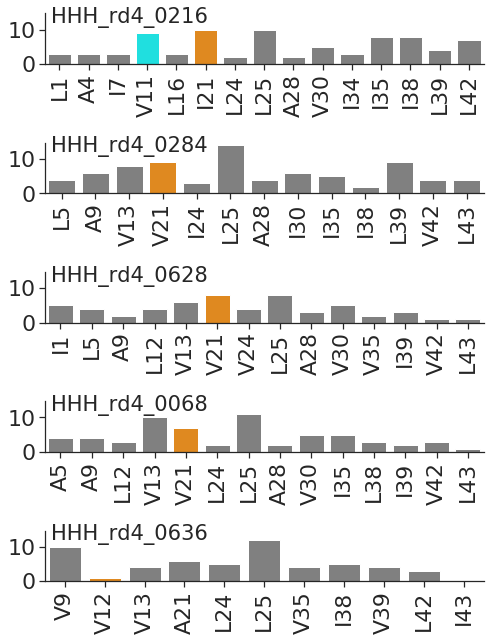

In [180]:
def get_color(pdb_name, res_n_aa):
    rescue_muts = {
        'HHH_rd4_0216_wt' : ['V11', 'I21'],
        'HHH_rd4_0284_wt' : ['V21'],
        'HHH_rd4_0628_wt' : ['V21'],
        'HHH_rd4_0068_wt' : ['V21'],
        'HHH_rd4_0636_wt' : ['V12']
    }
    if res_n_aa in rescue_muts[pdb_name]:
        if (pdb_name == 'HHH_rd4_0216_wt') and (res_n_aa == 'V11'):
            return 'cyan'
        else:
            return 'darkorange'
    else:
        return '0.5'
    
(fig, axs) = plt.subplots(
    nrows=len(pdb_names), sharex=False, figsize=[7,9], sharey=True
)
for (i, pdb_name) in enumerate(pdb_names):
    data = overlap_df[overlap_df['pdb_name'] == pdb_name].copy()
    cs = [
        get_color(pdb_name, res_n_aa)
        for res_n_aa in data['res_n_aa']
    ]
    sns.barplot(
        x='res_n_aa', y='n_overlaps', data=data,
        palette=cs, ax=axs[i]
    )
    axs[i].set(xlabel='', ylabel='')
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation='vertical')
    axs[i].text(
        0.015, 0.81, pdb_name.replace('_wt', ''),
        transform=axs[i].transAxes, fontsize=21
    )

plt.tight_layout(h_pad=2)
sns.despine()
plt.show()

['beta_nov16_natives', 'lowest_energy_decoys_torsion', 'lowest_energy_decoys_cart']
aliphatic_C_C beta_nov16_natives


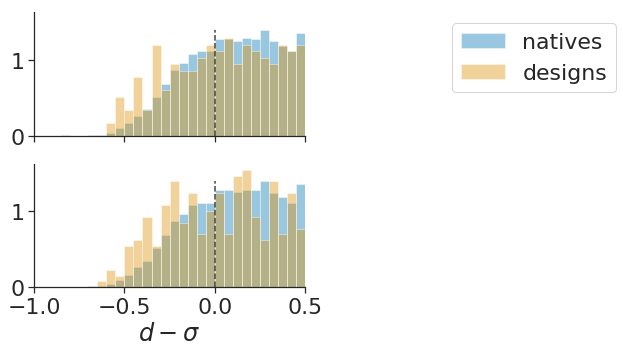

In [194]:
pdb_names = [
    'HHH_rd4_0216_wt', 'HHH_rd4_0284_wt', 'HHH_rd4_0628_wt',
    'HHH_rd4_0068_wt'
]
pdb_groups = [
    'beta_nov16_natives',
    'lowest_energy_decoys_torsion',
    'lowest_energy_decoys_cart'
]
natives = pdb_groups[0] #'HH_run17D_natives'
assert 'natives' in natives
atom_group = 'aliphatic_C_C'
#atom_group = 'CH3:OCbb' #'CH3:CObb' # 'CH3:S' # 
print(pdb_groups)
print(atom_group, natives)
data = energies_df[
    (energies_df['pdb_group'].isin(pdb_groups)) &
    (
        (energies_df['pdb_group'] == natives) |
        (energies_df['pdb_name'].isin(pdb_names))
    ) &
    (energies_df['d-o'] < 0.5) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df[atom_group] == True)
].copy()
metric = 'd-o'

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'pdb_group', 'cd']
}
min_range = -1 #data[metric].min()
max_range = 0.5 #data[metric].max()
nbins = 30
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
for bin_min in bins:
    for pdb_group in pdb_groups:
        cd_dict[metric].append(bin_min)
        cd_dict['pdb_group'].append(pdb_group)
        cd = sum(
            (data['pdb_group'] == pdb_group) &
            (data[metric] <= bin_min)
        ) / sum(data['pdb_group'] == pdb_group)
        cd_dict['cd'].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot data
nrows = len(pdb_groups[1:])
(fig, axs) = plt.subplots(
    ncols=1, nrows=nrows, sharey=True, sharex=True,
    figsize=[7,2.5*nrows]
)
xlim = [min_range, max_range]
for (i, pdb_group) in enumerate(pdb_groups[1:]):
    
    # Plot data for natives
    data_i = data[data['pdb_group'] == natives]
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label='natives', bins=bins, ax=axs[i]
    )
    
    # Plot data for the group of designs
    data_i = data[data['pdb_group'] == pdb_group]
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label='designs', bins=bins, ax=axs[i]
    )
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.5,1))
    axs[i].plot([0, 0], [0, 1.4], ls='--', c='0.25')
    if False:
        axs[i].text(
            0.05, 0.82,
            pdb_group.replace(
                '_beta16.nostab-refit', ''
            ).replace('_HH_run17D_step36', '').replace(
                '_cart', ''
            ).replace('3h_1018', 'HHH_65aa'),
            transform=axs[i].transAxes, fontsize=20
        )
    if i == nrows - 1:
        axs[i].set(
            ylabel='', xlabel='$d-\sigma$', xlim=xlim
        )
    else:
        axs[i].set(
            ylabel='', xlabel='', xlim=xlim
        )

plt.tight_layout(h_pad=1.0)
sns.despine()
plt.show()

In [189]:
set(data[data['pdb_group'] == 'lowest_energy_decoys_cart']['pdb_name'])

{'HHH_rd4_0068_wt',
 'HHH_rd4_0216_wt',
 'HHH_rd4_0284_wt',
 'HHH_rd4_0628_wt',
 'HHH_rd4_0636_wt'}

Plot the distribution of H-H distances, only considering Hs from aliphatic hydrophobic side chains

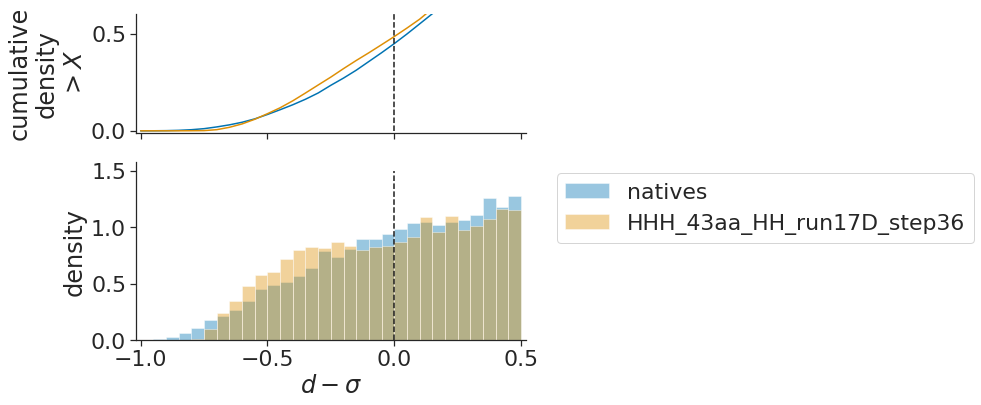

In [56]:
pdb_groups = [
    'natives', 'lowest_energy_decoys_torsion'
]
pdb_groups = [
    'natives', 'NTF2s_CN' #'HHH_BC' # 'ferr_BH', # 'MonomerDesign2019'
]
pdb_groups = [
    'HHH_43aa_beta16.nostab-refit', 'HHH_43aa_HH_run17D_step36'
]
pdb_groups = [
    'natives', 'HHH_43aa_HH_run17D_step36'
]
aas = ['VAL', 'LEU', 'ILE', 'ALA', 'MET']
atom_type_name = 'Hapo'
data = energies_df[
    (energies_df['pdb_group'].isin(pdb_groups)) &
    (energies_df['d-o'] < 0.5) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['res_i_name'].isin(aas)) &
    (energies_df['res_j_name'].isin(aas)) &
    (energies_df['atom_i_type_name'] == atom_type_name) &
    (energies_df['atom_j_type_name'] == atom_type_name)
].copy()
metric = 'd-o'

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'pdb_group', 'cd']
}
min_range = -1.0 #data[metric].min()
max_range = 0.5 #data[metric].max()
nbins = 30
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
for bin_min in bins:
    for pdb_group in pdb_groups:
        cd_dict[metric].append(bin_min)
        cd_dict['pdb_group'].append(pdb_group)
        cd = sum(
            (data['pdb_group'] == pdb_group) &
            (data[metric] <= bin_min)
        ) / sum(data['pdb_group'] == pdb_group)
        cd_dict['cd'].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot the data
(fig, axs) = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 1.5]},
    figsize=[7,6]
)
xlim = [-1.02, 0.52]

# ... first plotting the cumulative density
hue_order = pdb_groups
sns.lineplot(
    x=metric, y='cd', data=cd_df, hue='pdb_group',
    ax=axs[0]#, label=protein_group,
)
axs[0].plot([0, 0], [0, 0.6], ls='--', c='k')
axs[0].set(
    ylim=[-0.01, 0.6], ylabel='cumulative\ndensity\n$>X$',
    xlim=xlim
)
axs[0].get_legend().remove()

# ... and then the density
for pdb_group in pdb_groups:
    data_i = data[data['pdb_group'] == pdb_group]
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label=pdb_group, bins=bins, ax=axs[1]
    )
axs[1].plot([0, 0], [0, 1.5], ls='--', c='k')
axs[1].set(
    ylabel='density', xlabel='$d-\sigma$', xlim=xlim
)

plt.legend(bbox_to_anchor=(1.05,1))
sns.despine()
plt.show()

In [50]:
data.sort_values('d-o', ascending=True, inplace=True)
cols = [
    'pdb_name',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'd-o', 'd', 'lj_energy', 'lj_rep', 'lj_atr', 'fa_solv'
]
data[
    data['pdb_group'].str.contains('_B')
][cols].head(n=10)

,pdb_name,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,d-o,d,lj_energy,lj_rep,lj_atr,fa_solv


Plot C-C distances among contacts between aliphatic hydrophobic sidechains

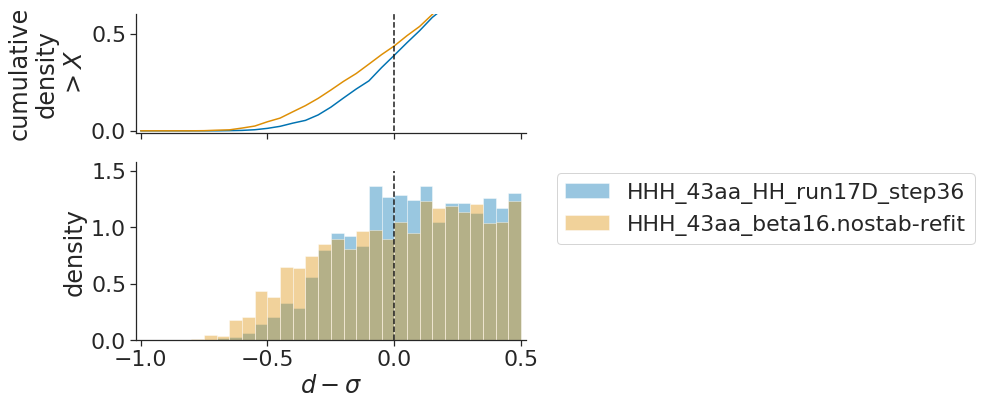

In [64]:
pdb_groups = [
    'natives', 'lowest_energy_decoys_cart'
]
pdb_groups = [
    'stable_designs', 'lowest_energy_decoys_cart'
]
pdb_groups = [
    'natives', 'NTF2s_CN' #'HHH_BC' # 'ferr_BH', # 'MonomerDesign2019'
]
pdb_groups = [
    'natives', 'HHH_43aa_HH_run17D_step36' # 'HHH_43aa_beta16.nostab-refit' #
]
pdb_groups = [
    'HHH_43aa_HH_run17D_step36', 'HHH_43aa_beta16.nostab-refit'
]
aas = ['VAL', 'LEU', 'ILE', 'ALA', 'MET']
atom_type_names = ['CH1', 'CH2', 'CH3']
data = energies_df[
    (energies_df['pdb_group'].isin(pdb_groups)) &
    (energies_df['d-o'] < 0.5) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['res_i_name'].isin(aas)) &
    (energies_df['res_j_name'].isin(aas)) &
    (energies_df['atom_i_type_name'].isin(atom_type_names)) &
    (energies_df['atom_j_type_name'].isin(atom_type_names))
].copy()
metric = 'd-o'

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'pdb_group', 'cd']
}
min_range = -1 #data[metric].min()
max_range = 0.5 #data[metric].max()
nbins = 30
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
for bin_min in bins:
    for pdb_group in pdb_groups:
        cd_dict[metric].append(bin_min)
        cd_dict['pdb_group'].append(pdb_group)
        cd = sum(
            (data['pdb_group'] == pdb_group) &
            (data[metric] <= bin_min)
        ) / sum(data['pdb_group'] == pdb_group)
        cd_dict['cd'].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot the data
(fig, axs) = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 1.5]},
    figsize=[7,6]
)
xlim = [-1.02, 0.52]

# ... first plotting the cumulative density
hue_order = pdb_groups
sns.lineplot(
    x=metric, y='cd', data=cd_df, hue='pdb_group',
    ax=axs[0]#, label=protein_group,
)
axs[0].plot([0, 0], [0, 0.6], ls='--', c='k')
axs[0].set(
    ylim=[-0.01, 0.6], xlim=xlim, ylabel='cumulative\ndensity\n$>X$'
)
axs[0].get_legend().remove()

# ... and then the density
for pdb_group in pdb_groups:
    data_i = data[data['pdb_group'] == pdb_group]
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label=pdb_group, bins=bins, ax=axs[1]
    )
axs[1].plot([0, 0], [0, 1.5], ls='--', c='k')
axs[1].set(
    ylabel='density',
    xlabel='$d-\sigma$', xlim=xlim
)

plt.legend(bbox_to_anchor=(1.05,1))
sns.despine()
plt.show()

In [61]:
data.sort_values('d-o', ascending=True, inplace=True)
cols = [
    'pdb_name',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'd-o', 'd', 'lj_energy', 'lj_rep', 'lj_atr', 'fa_solv'
]
data[
    data['pdb_group'].str.contains('H')
][cols].head(n=10)

,pdb_name,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,d-o,d,lj_energy,lj_rep,lj_atr,fa_solv
83509,run_30_start_0208_0001,25,ILE,CG2,35,VAL,CG2,-0.774518,3.249002,0.363077,0.425719,-0.062642,-0.394672
38060,run_28_start_0355_0001,8,ALA,CB,38,VAL,CG1,-0.724209,3.299311,0.265645,0.328287,-0.062642,-0.394672
52719,run_18_start_0319_0001,11,ALA,CB,21,LEU,CD2,-0.717485,3.306035,0.254291,0.316933,-0.062642,-0.394672
18491,run_10_start_0012_0001,7,VAL,CG1,37,ALA,CB,-0.714954,3.308566,0.250110,0.312752,-0.062642,-0.394672
36598,run_8_start_0189_0001,7,VAL,CG2,23,LEU,CB,-0.701151,3.322369,0.228171,0.290813,-0.062642,-0.074741
31603,run_30_start_0208_0001,8,LEU,CD2,25,ILE,CG1,-0.690140,3.333380,0.211674,0.274316,-0.062642,-0.074741
131481,run_20_start_0271_0001,25,LEU,CB,35,LEU,CD2,-0.671661,3.351859,0.185858,0.248500,-0.062642,-0.074741
10145,run_29_start_0011_0001,4,ALA,CB,30,VAL,CG1,-0.667543,3.355977,0.180409,0.243051,-0.062642,-0.394672
105755,run_3_start_0367_0001,25,ALA,CB,35,VAL,CG2,-0.658928,3.364592,0.169351,0.231993,-0.062642,-0.394672
91963,run_1_start_0151_0001,25,ALA,CB,35,VAL,CG2,-0.652872,3.370648,0.161846,0.224488,-0.062642,-0.394672


Plot H-C distances among contacts between aliphatic hydrophobic sidechains

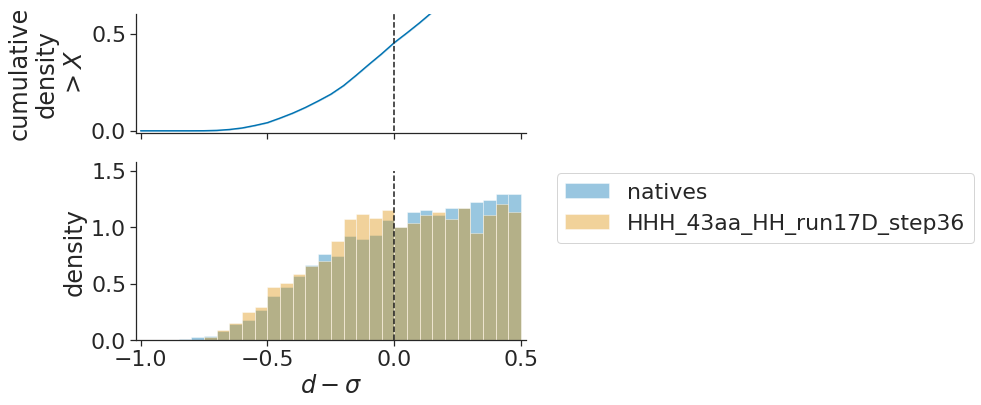

In [57]:
pdb_groups = [
    'natives', 'lowest_energy_decoys_cart'
]
pdb_groups = [
    'natives', 'NTF2s_CN' #'HHH_BC' # 'ferr_BH', # 'MonomerDesign2019'
]
pdb_groups = [
    'HHH_43aa_beta16.nostab-refit', 'HHH_43aa_HH_run17D_step36'
]
pdb_groups = [
    'natives', 'HHH_43aa_HH_run17D_step36'
]
aas = ['VAL', 'LEU', 'ILE', 'ALA', 'MET']
data = energies_df[
    (energies_df['pdb_group'].isin(pdb_groups)) &
    (energies_df['d-o'] < 0.5) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['res_i_name'].isin(aas)) &
    (energies_df['res_j_name'].isin(aas)) &
    (energies_df['has_Hapo_and_C']) &
    ~(energies_df['atom_i_name'].isin([
        'N', 'C', 'CA', 'H', 'HA', 'O'
    ])) &
    ~(energies_df['atom_j_name'].isin([
        'N', 'C', 'CA', 'H', 'HA', 'O'
    ]))
].copy()
metric = 'd-o'

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'pdb_group', 'cd']
}
min_range = -1 #data[metric].min()
max_range = 0.5 #data[metric].max()
nbins = 30
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
for bin_min in bins:
    for protein_group in pdb_groups:
        cd_dict[metric].append(bin_min)
        cd_dict['pdb_group'].append(pdb_group)
        cd = sum(
            (data['pdb_group'] == pdb_group) &
            (data[metric] <= bin_min)
        ) / sum(data['pdb_group'] == pdb_group)
        cd_dict['cd'].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot the data
(fig, axs) = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 1.5]},
    figsize=[7,6]
)
xlim = [-1.02, 0.52]

# ... first plotting the cumulative density
hue_order = pdb_groups
sns.lineplot(
    x=metric, y='cd', data=cd_df, hue='pdb_group',
    ax=axs[0]#, label=protein_group,
)
axs[0].plot([0, 0], [0, 0.6], ls='--', c='k')
axs[0].set(
    ylim=[-0.01, 0.6], ylabel='cumulative\ndensity\n$>X$',
    xlim=xlim
)
axs[0].get_legend().remove()

# ... and then the density
for pdb_group in pdb_groups:
    data_i = data[data['pdb_group'] == pdb_group]
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label=pdb_group, bins=bins, ax=axs[1]
    )
axs[1].plot([0, 0], [0, 1.5], ls='--', c='k')
axs[1].set(
    ylabel='density',
    xlabel='$d-\sigma$', xlim=xlim
)

plt.legend(bbox_to_anchor=(1.05,1))
#plt.tight_layout()
sns.despine()
plt.show()

In [23]:
data.sort_values('d-o', ascending=True, inplace=True)
cols = [
    'pdb_name',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'd-o', 'd', 'lj_energy', 'lj_rep', 'lj_atr', 'fa_solv'
]
data[
    data['pdb_group'].str.contains('_B')
][cols].head(n=10)

,pdb_name,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,d-o,d,lj_energy,lj_rep,lj_atr,fa_solv
175735,ferr_buw_04390,25,LEU,CD1,47,LEU,1HD1,-0.969368,2.463664,1.439868,1.476829,-0.036961,0.0
49291,ferr_buw_08161,5,VAL,CG1,36,VAL,HB,-0.935135,2.497897,1.180543,1.217504,-0.036961,0.0
137489,ferr_buw_14454,16,LEU,1HD1,56,LEU,CD1,-0.932493,2.500539,1.162536,1.199497,-0.036961,0.0
20449,ferr_buw_15447,3,ILE,CG2,38,ILE,HB,-0.930379,2.502653,1.148310,1.185271,-0.036961,0.0
32303,ferr_buw_09297,3,VAL,CG1,36,ILE,HB,-0.930007,2.503025,1.145829,1.182790,-0.036961,0.0
119523,ferr_buw_15447,13,LEU,CD2,36,VAL,HB,-0.926335,2.506697,1.121575,1.158536,-0.036961,0.0
117304,ferr_buw_01587,12,LEU,HG,16,ILE,CD1,-0.913641,2.519391,1.041485,1.078446,-0.036961,0.0
16049,ferr_buw_08701,1,LEU,1HD1,60,ILE,CG2,-0.904962,2.528070,0.989913,1.026874,-0.036961,0.0
16700,ferr_buw_07080,3,ILE,CG2,38,VAL,HB,-0.892697,2.540335,0.921170,0.958131,-0.036961,0.0
130413,ferr_buw_08873,16,LEU,1HD1,56,LEU,CD1,-0.879921,2.553111,0.854394,0.891355,-0.036961,0.0


Compare different groups

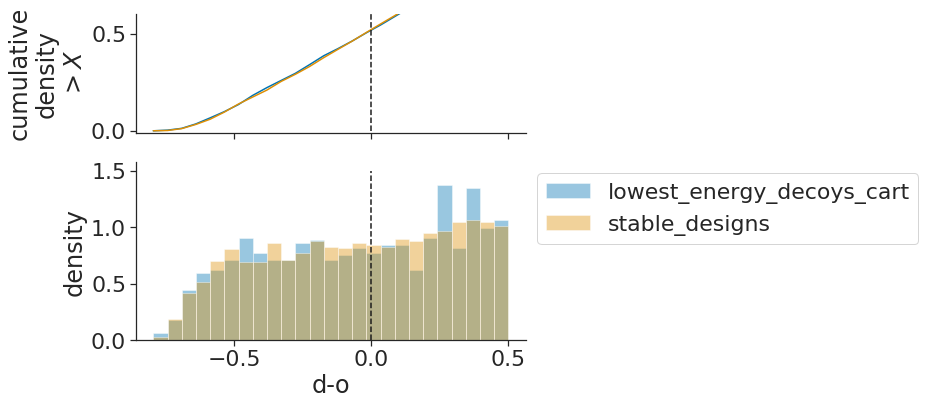

In [15]:
pdb_groups = [
    #'MonomerDesign2019', 'Legacy'
    'lowest_energy_decoys_cart', 'stable_designs'
]
aas = ['VAL', 'LEU', 'ILE', 'ALA', 'MET']
atom_type_name = 'Hapo'
data = energies_df[
    (energies_df['pdb_group'].isin(pdb_groups)) &
    (energies_df['d-o'] < 0.5) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['res_i_name'].isin(aas)) &
    (energies_df['res_j_name'].isin(aas)) &
    (energies_df['atom_i_type_name'] == atom_type_name) &
    (energies_df['atom_j_type_name'] == atom_type_name)
].copy()
metric = 'd-o'

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'pdb_group', 'cd']
}
min_range = data[metric].min()
max_range = data[metric].max()
nbins = 25
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
for bin_min in bins:
    for pdb_group in pdb_groups:
        cd_dict[metric].append(bin_min)
        cd_dict['pdb_group'].append(pdb_group)
        cd = sum(
            (data['pdb_group'] == pdb_group) &
            (data[metric] <= bin_min)
        ) / sum(data['pdb_group'] == pdb_group)
        cd_dict['cd'].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot the data
(fig, axs) = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 1.5]},
    figsize=[7,6]
)

# ... first plotting the cumulative density
hue_order = pdb_groups #['natives', 'unstable_designs']
sns.lineplot(
    x=metric, y='cd', data=cd_df, hue='pdb_group',
    ax=axs[0]#, label=protein_group,
)
axs[0].plot([0, 0], [0, 0.6], ls='--', c='k')
axs[0].set(ylim=[-0.01, 0.6], ylabel='cumulative\ndensity\n$>X$')
axs[0].get_legend().remove()

# ... and then the density
for pdb_group in pdb_groups:
    data_i = data[data['pdb_group'] == pdb_group]
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label=pdb_group, bins=bins, ax=axs[1]
    )
axs[1].plot([0, 0], [0, 1.5], ls='--', c='k')
axs[1].set(
    ylabel='density'
)

plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

Plot distribution of pairwise clashes between atoms from aliphatic side chains (VLIAM)

Clipping lj_energy at an upper limit of 1.0


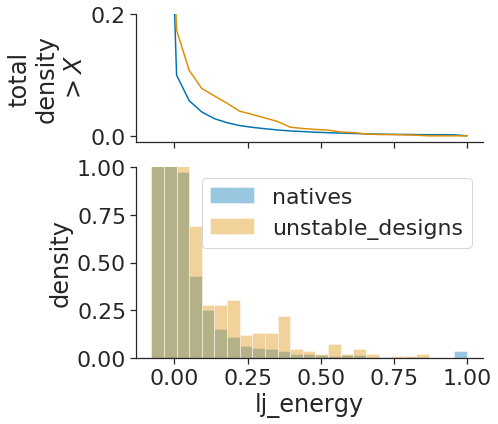

In [60]:
pdb_groups = ['lowest_energy_decoys_torsion', 'natives']
aas = ['VAL', 'LEU', 'ILE', 'ALA', 'MET']
atom_type_names = ['Hapo']
data = energies_df[
    (energies_df['pdb_group'].isin(pdb_groups)) &
    (energies_df['d-o'] < 1.0) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['res_i_name'].isin(aas)) &
    (energies_df['res_j_name'].isin(aas)) &
    #(energies_df['atom_i_type_name'].isin(atom_type_names)) &
    #(energies_df['atom_j_type_name'].isin(atom_type_names)) &
    ~(energies_df['atom_i_name'].isin([
        'N', 'C', 'CA', 'H', 'HA', 'O', 'SD'
    ])) &
    ~(energies_df['atom_j_name'].isin([
        'N', 'C', 'CA', 'H', 'HA', 'O', 'SD'
    ]))
].copy()
metric = 'lj_energy'
upper_lim = 1.0
print(f"Clipping {metric} at an upper limit of {upper_lim}")
data[metric] = data[metric].clip(upper=upper_lim)

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'protein_group', 'cd']
}
min_range = data[metric].min()
max_range = data[metric].max()
nbins = 25
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
for bin_min in bins:
    for protein_group in ['natives', 'unstable_designs']:
        cd_dict[metric].append(bin_min)
        cd_dict['protein_group'].append(protein_group)
        cd = sum(
            (data['protein_group'] == protein_group) &
            (data[metric] > bin_min)
        ) / sum(data['protein_group'] == protein_group)
        cd_dict['cd'].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot the data
(fig, axs) = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 1.5]},
    figsize=[7,6]
)

# ... first plotting the cumulative density
hue_order = ['natives', 'unstable_designs']
sns.lineplot(
    x=metric, y='cd', data=cd_df, hue='protein_group',
    ax=axs[0]#, label=protein_group,
)
axs[0].set(ylim=[-0.01, 0.2], ylabel='total\ndensity\n$>X$')
axs[0].get_legend().remove()

# ... and then the density
for protein_group in ['natives', 'unstable_designs']:
    data_i = data[data['protein_group'] == protein_group]
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label=protein_group, bins=bins, ax=axs[1]
    )
axs[1].set(
    ylabel='density', ylim=[0, 1], # yscale='log' 
)

#plt.legend(bbox_to_anchor=(1,1))
plt.legend()
plt.tight_layout()
sns.despine()
plt.show()

In [61]:
data.sort_values('lj_energy', ascending=False, inplace=True)
cols = [
    'pdb_name',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'lj_energy', 'lj_rep', 'lj_atr', 'fa_solv', 'd', 'd-o'
]
data[
    data['pdb_group'].str.contains('lowest_energy_decoys_')
][cols].head(n=10)

,pdb_name,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,lj_energy,lj_rep,lj_atr,fa_solv,d,d-o
6035,HHH_rd4_0068_wt,9,ALA,1HB,21,VAL,3HG1,0.867254,0.889062,-0.021808,0.0,2.036960,-0.805584
9810,EEHEE_rd4_0215_wt,5,VAL,2HG2,42,ILE,2HD1,0.836779,0.858587,-0.021808,0.0,2.042079,-0.800465
2461,HHH_rd4_0216_wt,11,VAL,CG2,21,ILE,1HG1,0.805159,0.842120,-0.036961,0.0,2.563151,-0.869881
8861,HHH_rd4_0628_wt,25,LEU,2HB,30,VAL,HB,0.751509,0.773317,-0.021808,0.0,2.057434,-0.785110
6885,HHH_rd4_0068_wt,25,LEU,2HB,30,VAL,HB,0.672792,0.694600,-0.021808,0.0,2.073192,-0.769352
2514,HHH_rd4_0216_wt,11,VAL,1HG2,21,ILE,1HG1,0.663609,0.685417,-0.021808,0.0,2.075145,-0.767399
1210,HHH_rd4_0284_wt,25,LEU,2HD1,35,ILE,3HG2,0.637644,0.659452,-0.021808,0.0,2.080812,-0.761732
5020,HHH_rd4_0636_wt,25,LEU,2HB,35,VAL,2HG2,0.636255,0.658063,-0.021808,0.0,2.081121,-0.761423
9579,EEHEE_rd4_0215_wt,3,MET,1HG,40,ILE,HB,0.626052,0.647860,-0.021808,0.0,2.083414,-0.759130
3149,HHH_rd4_0216_wt,25,LEU,2HB,35,ILE,1HG1,0.616971,0.638779,-0.021808,0.0,2.085484,-0.757060


Show data for individual designs

In [82]:
aas = ['VAL', 'LEU', 'ILE', 'ALA', 'MET']
design = 'HHH_rd4_0216_wt'
atom_type_names = ['CH1', 'CH2', 'CH3'] # ['Hapo'] # 
data = energies_df[
    #(energies_df['has_Hapo_and_C']) &
    #(energies_df['atom_i_type_name'].isin(atom_type_names)) &
    #(energies_df['atom_j_type_name'].isin(atom_type_names)) &
    (energies_df['pdb_group'] == 'lowest_energy_decoys_torsion') &
    (energies_df['res_i_name'].isin(aas)) &
    (energies_df['res_j_name'].isin(aas)) &
    ~(energies_df['atom_i_name'].isin([
        'N', 'C', 'CA', 'H', 'HA', 'O', 'SD'
    ])) &
    ~(energies_df['atom_j_name'].isin([
        'N', 'C', 'CA', 'H', 'HA', 'O', 'SD'
    ]))
].copy()
data.sort_values('d-o', ascending=True, inplace=True)
cols = [
    'pdb_name',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'd-o', 'd', 'lj_energy', 'lj_rep', 'lj_atr', 'fa_solv'
]
data[
    data['pdb_name'] == design
][cols].head(n=20)

,pdb_name,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,d-o,d,lj_energy,lj_rep,lj_atr,fa_solv
2461,HHH_rd4_0216_wt,11,VAL,CG2,21,ILE,1HG1,-0.869881,2.563151,0.805159,0.842120,-0.036961,0.0
2514,HHH_rd4_0216_wt,11,VAL,1HG2,21,ILE,1HG1,-0.767399,2.075145,0.663609,0.685417,-0.021808,0.0
3149,HHH_rd4_0216_wt,25,LEU,2HB,35,ILE,1HG1,-0.757060,2.085484,0.616971,0.638779,-0.021808,0.0
3365,HHH_rd4_0216_wt,30,VAL,2HG1,35,ILE,2HG1,-0.754492,2.088052,0.605884,0.627692,-0.021808,0.0
2830,HHH_rd4_0216_wt,21,ILE,CG2,39,LEU,3HD2,-0.745193,2.687839,0.375747,0.412708,-0.036961,0.0
2522,HHH_rd4_0216_wt,11,VAL,2HG2,16,LEU,2HD1,-0.743248,2.099296,0.559547,0.581355,-0.021808,0.0
1901,HHH_rd4_0216_wt,1,LEU,2HB,4,ALA,3HB,-0.735213,2.107331,0.528521,0.550329,-0.021808,0.0
3624,HHH_rd4_0216_wt,35,ILE,2HG2,39,LEU,CD1,-0.722293,2.710739,0.324241,0.361201,-0.036961,0.0
3152,HHH_rd4_0216_wt,25,LEU,1HD1,38,ILE,CG2,-0.702876,2.730156,0.285375,0.322335,-0.036961,0.0
3264,HHH_rd4_0216_wt,28,ALA,3HB,30,VAL,3HG2,-0.691992,2.150552,0.387570,0.409378,-0.021808,0.0


In [79]:
set(
    list(data[
        (data['d-o'] < -0.6) &
        (data['pdb_name'] == design)
    ]['res_i_n']) + \
    list(data[
        (data['d-o'] < -0.6) &
        (data['pdb_name'] == design)
    ]['res_j_n'])
)

{1, 4, 7, 11, 16, 21, 25, 28, 30, 34, 35, 38, 39, 42}

In [75]:
ri = 2.10 #2.011760 # carbon
ei = 0.062642 # carbon
rj = 1.421272 # Hapo
ej = 0.021808 # Hapo
o = ri + rj
e = math.sqrt(ei * ej)
d_minus_os = np.arange(-0.9, 0.55, 0.05)
energies = [
    compute_lj_energy(e, o, x+o)
    for x in d_minus_os
]

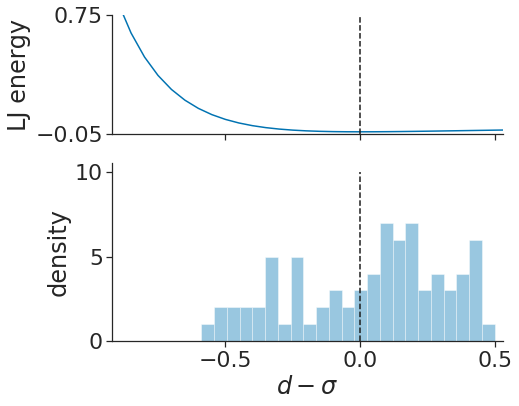

In [77]:
metric = 'd-o'

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'pdb_name', 'cd']
}
min_range = -0.92 #data[metric].min()
max_range = 0.5 #data[metric].max()
nbins = 30
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
pdb_names = list(set(data['pdb_name']))
for bin_min in bins:
    for pdb_name in pdb_names:
        cd_dict[metric].append(bin_min)
        cd_dict['pdb_name'].append(pdb_name)
        cd = sum(
            (data['pdb_name'] == pdb_name) &
            (data[metric] <= bin_min)
        ) / sum(data['pdb_name'] == pdb_name)
        cd_dict['cd'].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot the data
(fig, axs) = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 1.5]},
    figsize=[7,6]
)
xlim = [-0.92, 0.53]

# ... first plotting the cumulative density
if False:
    for pdb_name in pdb_names:
        if pdb_name == design:
            continue
        sns.lineplot(
            x=metric, y='cd', data=cd_df[cd_df['pdb_name'] == pdb_name],
            ax=axs[0], color='0.5'
        )
    sns.lineplot(
        x=metric, y='cd', data=cd_df[cd_df['pdb_name'] == design],
        ax=axs[0]
    )
    axs[0].plot([0, 0], [0, 0.6], ls='--', c='k')
    axs[0].set(
        ylim=[-0.01, 0.6], ylabel='cumulative\ndensity\n$>X$',
        xlim=xlim
    )
else:
    sns.lineplot(d_minus_os, energies, ax=axs[0])
    axs[0].plot([0, 0], [-0.05, 1.7], ls='--', c='k')
    #axs[0].plot(xlim, [0,0], ls='--', c='k')
    axs[0].set(
        ylabel='LJ energy',
        ylim=[-0.05, 0.75], xlim=xlim,
        yticks=[-0.05, 0.75]
    )
    
# ... and then the density
data_i = data[data['pdb_name'] == design]
sns.distplot(
    data_i[metric], kde=False, #norm_hist=True,
    bins=bins, ax=axs[1]
)
axs[1].plot([0, 0], [0, 10], ls='--', c='k')
axs[1].set(
    ylabel='density',
    xlabel='$d-\sigma$',
    xlim=xlim
)
sns.despine()
plt.show()

In [ ]:
metric = 'd-o'

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'pdb_name', 'cd']
}
min_range = data[metric].min()
max_range = data[metric].max()
nbins = 25
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
pdb_names = list(set(data['pdb_name']))
for bin_min in bins:
    for pdb_name in pdb_names:
        cd_dict[metric].append(bin_min)
        cd_dict['pdb_name'].append(pdb_name)
        cd = sum(
            (data['pdb_name'] == pdb_name) &
            (data[metric] <= bin_min)
        ) / sum(data['pdb_name'] == pdb_name)
        cd_dict['cd'].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot the data
(fig, axs) = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 1.5]},
    figsize=[7,6]
)

# ... first plotting the cumulative density
sns.lineplot(
    x=metric, y='cd', data=cd_df[cd_df['pdb_name'] == design],
    ax=axs[0]
)
for pdb_name in pdb_names:
    if pdb_name == design:
        continue
    sns.lineplot(
        x=metric, y='cd', data=cd_df[cd_df['pdb_name'] == pdb_name],
        ax=axs[0], color='0.5'
    )
axs[0].plot([0, 0], [0, 0.6], ls='--', c='k')
axs[0].set(ylim=[-0.01, 0.6], ylabel='cumulative\ndensity\n$>X$')

# ... and then the density
data_i = data[data['pdb_name'] == design]
sns.distplot(
    data_i[metric], kde=False, #norm_hist=True,
    bins=bins, ax=axs[1]
)
axs[1].plot([0, 0], [0, 35], ls='--', c='k')
axs[1].set(
    ylabel='density'
)
sns.despine()
plt.show()

Plot data for designs

Clipping lj_energy at an upper limit of 1.0


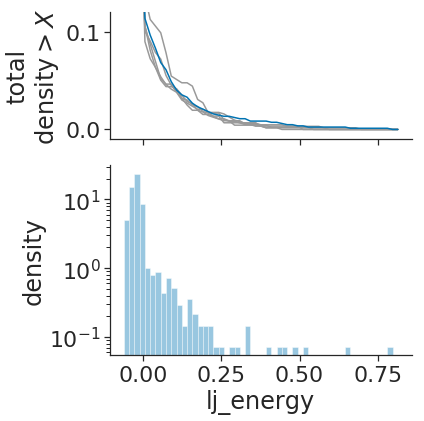

In [66]:
aas = ['VAL', 'LEU', 'ILE', 'ALA']
data = energies_df[
    (energies_df['d-o'] < 1.0) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['res_i_name'].isin(aas)) &
    (energies_df['res_j_name'].isin(aas)) &
    ~(energies_df['atom_i_name'].isin([
        'N', 'C', 'CA', 'H', 'HA', 'O'
    ])) &
    ~(energies_df['atom_j_name'].isin([
        'N', 'C', 'CA', 'H', 'HA', 'O'
    ])) &
    (energies_df['protein_group'] == 'unstable_designs')
].copy()
metric = 'lj_energy'
upper_lim = 1.0
print(f"Clipping {metric} at an upper limit of {upper_lim}")
data[metric] = data[metric].clip(upper=upper_lim)

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'cd', 'pdb']
}
min_range = data[metric].min()
max_range = data[metric].max()
nbins = 50
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+2*bin_size, bin_size)
pdbs = list(set(data['pdb']))
for bin_min in bins:
    for pdb in pdbs:
        cd_dict[metric].append(bin_min)
        cd_dict['pdb'].append(pdb)
        cd = sum(
            (data['pdb'] == pdb) &
            (data[metric] > bin_min)
        ) / sum(
            data['pdb'] == pdb
        )
        cd_dict['cd'].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot the data
(fig, axs) = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={'height_ratios': [1.0, 1.5]},
    figsize=[6,6]
)

# ... first plotting the cumulative density
if True:
    for pdb in pdbs:
        if pdb == design:
            continue
        sns.lineplot(
            x=metric, y='cd',
            data=cd_df[cd_df['pdb'] == pdb],
            ax=axs[0], color='0.6'
        )
design = 'HHH_rd4_0216_wt'
sns.lineplot(
    x=metric, y='cd',
    data=cd_df[cd_df['pdb'] == design],
    ax=axs[0]#, label=protein_group,
)
axs[0].set(ylim=[-0.01, 0.12], ylabel='total\ndensity$>X$')

# ... and then the density
sns.distplot(
    data[data['pdb'] == design][metric],
    kde=False, norm_hist=True,
    bins=bins, ax=axs[1]
)
axs[1].set(ylabel='density', yscale='log')
#plt.xlim([0.2, 0.8])
#plt.ylim([0, 10])
plt.tight_layout()
sns.despine()
plt.show()

In [67]:
pdbs

['HHH_rd4_0284_wt',
 'HHH_rd4_0628_wt',
 'HHH_rd4_0636_wt',
 'HHH_rd4_0216_wt',
 'HHH_rd4_0068_wt',
 'EEHEE_rd4_0215_wt']

In [51]:
data.sort_values('lj_energy', ascending=False, inplace=True)
cols = [
    'pdb',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'lj_energy', 'lj_rep', 'lj_atr', 'fa_solv', 'd', 'd-o'
]
data = data[
    (data['pdb'] == 'HHH_rd4_0216_wt') &
    (data['lj_energy'] > 0.4) #&
    #(data['res_i_n'].isin([11, 21])) &
    #(data['res_j_n'].isin([11, 21]))
]
data[cols].head(n=20)

,pdb,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,lj_energy,lj_rep,lj_atr,fa_solv,d,d-o
26452,HHH_rd4_0216_wt,11,VAL,1HG1,42,LEU,3HD1,0.781177,0.802985,-0.021808,0.0,2.051907,-0.790637
27808,HHH_rd4_0216_wt,11,VAL,1HG2,21,ILE,1HG1,0.660978,0.682786,-0.021808,0.0,2.075709,-0.766835
22590,HHH_rd4_0216_wt,7,ILE,2HD1,24,LEU,2HB,0.526292,0.548100,-0.021808,0.0,2.107926,-0.734618
58678,HHH_rd4_0216_wt,38,ILE,2HG2,42,LEU,2HD1,0.486237,0.508045,-0.021808,0.0,2.119033,-0.723511
13549,HHH_rd4_0216_wt,4,ALA,1HB,38,ILE,CD1,0.451180,0.488140,-0.036961,0.0,2.658783,-0.774249
18024,HHH_rd4_0216_wt,7,ILE,HB,25,LEU,3HD2,0.440951,0.462759,-0.021808,0.0,2.132679,-0.709865
27147,HHH_rd4_0216_wt,11,VAL,3HG1,16,LEU,1HB,0.401694,0.423502,-0.021808,0.0,2.145611,-0.696933


In [52]:
set(list(data['res_i_n']) + list(data['res_j_n']))

{4, 7, 11, 16, 21, 24, 25, 38, 42}

Plot distribution of pairwise clashes between sc-bb atoms with seq separation of > 1

Clipping lj_energy at an upper limit of 1.0


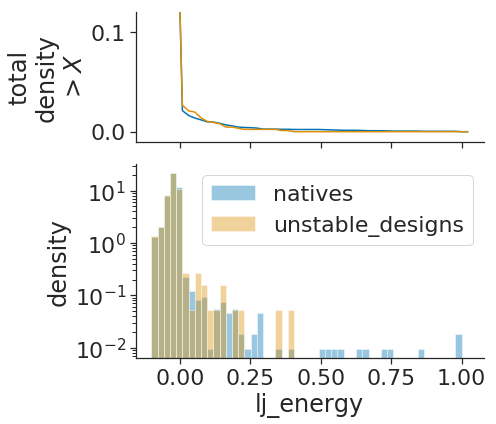

In [68]:
aas = ['VAL', 'LEU', 'ILE', 'ALA']
data = energies_df[
    (energies_df['d-o'] < 1.5) &
    (energies_df['seq_dist'] > 1) &
    (energies_df['res_i_ss'] == 'H') &
    (energies_df['res_j_ss'] == 'H') &
    (energies_df['res_i_name'].isin(aas)) &
    (energies_df['atom_j_name'].isin([
        'N', 'C', 'CA', 'H', 'HA', 'O'
    ]))
].copy()
metric = 'lj_energy'
upper_lim = 1.0
print(f"Clipping {metric} at an upper limit of {upper_lim}")
data[metric] = data[metric].clip(upper=upper_lim)

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'protein_group', 'cd']
}
min_range = data[metric].min()
max_range = data[metric].max()
nbins = 50
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
for bin_min in bins:
    for protein_group in ['natives', 'unstable_designs']:
        cd_dict[metric].append(bin_min)
        cd_dict['protein_group'].append(protein_group)
        cd = sum(
            (data['protein_group'] == protein_group) &
            (data[metric] > bin_min)
        ) / sum(data['protein_group'] == protein_group)
        cd_dict['cd'].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot the data
(fig, axs) = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 1.5]},
    figsize=[7,6]
)

# ... first plotting the cumulative density
hue_order = ['natives', 'unstable_designs']
sns.lineplot(
    x=metric, y='cd', data=cd_df, hue='protein_group',
    ax=axs[0]#, label=protein_group,
)
axs[0].set(ylim=[-0.01, 0.12], ylabel='total\ndensity\n$>X$')
axs[0].get_legend().remove()

# ... and then the density
for protein_group in ['natives', 'unstable_designs']:
    data_i = data[data['protein_group'] == protein_group]
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label=protein_group, bins=bins, ax=axs[1]
    )
axs[1].set(ylabel='density', yscale='log')

plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
sns.despine()
plt.show()

Plot distribution of pairwise clashes between sc-bb atoms with seq separation of exactly 1

Clipping lj_energy at an upper limit of 1.0


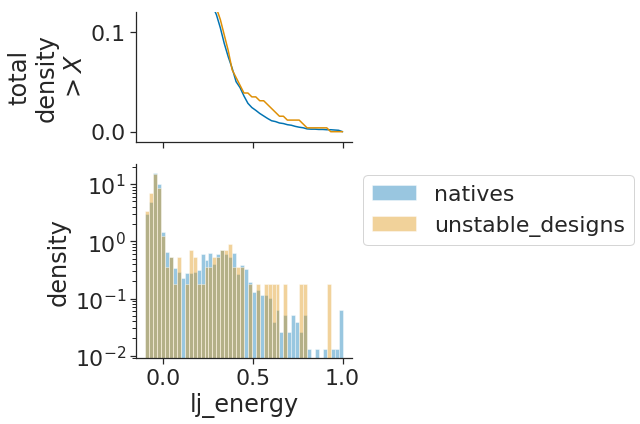

In [82]:
aas = ['VAL', 'LEU', 'ILE', 'ALA']
data = energies_df[
    (energies_df['d-o'] < 1.0) &
    (energies_df['seq_dist'] == 1) &
    (energies_df['res_i_ss'] == 'H') &
    (energies_df['res_j_ss'] == 'H') &
    (
        (energies_df['res_i_name'].isin(aas)) &
        (energies_df['atom_j_name'].isin([
        'N'#, 'C', 'CA', 'H', 'HA', 'O'
        ])) | 
        (energies_df['res_j_name'].isin(aas)) &
        (energies_df['atom_i_name'].isin([
        'N'#, 'C', 'CA', 'H', 'HA', 'O'
        ]))
    )
].copy()
metric = 'lj_energy'
upper_lim = 1.0
print(f"Clipping {metric} at an upper limit of {upper_lim}")
data[metric] = data[metric].clip(upper=upper_lim)

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'protein_group', 'cd']
}
min_range = data[metric].min()
max_range = data[metric].max()
nbins = 50
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
for bin_min in bins:
    for protein_group in ['natives', 'unstable_designs']:
        cd_dict[metric].append(bin_min)
        cd_dict['protein_group'].append(protein_group)
        cd = sum(
            (data['protein_group'] == protein_group) &
            (data[metric] > bin_min)
        ) / sum(data['protein_group'] == protein_group)
        cd_dict['cd'].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot the data
(fig, axs) = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 1.5]},
    figsize=[9,6]
)

# ... first plotting the cumulative density
hue_order = ['natives', 'unstable_designs']
sns.lineplot(
    x=metric, y='cd', data=cd_df, hue='protein_group',
    ax=axs[0]#, label=protein_group,
)
axs[0].set(ylim=[-0.01, 0.12], ylabel='total\ndensity\n$>X$')
axs[0].get_legend().remove()

# ... and then the density
for protein_group in ['natives', 'unstable_designs']:
    data_i = data[data['protein_group'] == protein_group]
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label=protein_group, bins=bins, ax=axs[1]
    )
axs[1].set(ylabel='density', yscale='log')

plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
sns.despine()
plt.show()

In [84]:
cols = [
    'pdb',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'lj_rep', 'lj_atr', 'lj_energy', 'd', 'o'
]
data.sort_values('lj_rep', ascending=False, inplace=True)
data[data['protein_group'] == 'unstable_designs'][cols].head(n=10)

,pdb,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,lj_rep,lj_atr,lj_energy,d,o
21622,HHH_rd4_0068_wt,24,LEU,CB,25,LEU,N,1.026496,-0.100652,0.925844,3.003599,3.814212
35632,HHH_rd4_0216_wt,21,ILE,CB,22,GLU,N,0.901670,-0.100652,0.801019,3.028220,3.814212
21555,EEHEE_rd4_0215_wt,22,ALA,CB,23,GLU,N,0.871215,-0.100652,0.770563,3.034713,3.814212
35132,HHH_rd4_0628_wt,21,VAL,CB,22,LYS,N,0.786718,-0.100652,0.686066,3.053903,3.814212
20742,HHH_rd4_0284_wt,24,ILE,CB,25,LEU,N,0.733025,-0.100652,0.632373,3.067119,3.814212
37894,HHH_rd4_0284_wt,39,LEU,CB,40,ARG,N,0.715026,-0.100652,0.614374,3.071751,3.814212
23603,HHH_rd4_0216_wt,11,VAL,CB,12,GLU,N,0.691624,-0.100652,0.590973,3.077938,3.814212
29912,HHH_rd4_0628_wt,13,VAL,CB,14,LYS,N,0.679545,-0.100652,0.578893,3.081207,3.814212
34081,HHH_rd4_0068_wt,35,ILE,CB,36,LYS,N,0.635682,-0.100652,0.535030,3.093545,3.814212
6085,HHH_rd4_0636_wt,12,VAL,CB,13,VAL,N,0.576913,-0.100652,0.476261,3.111362,3.814212


Plot distribution of per-atom fa_rep scores

In [85]:
for x in ['i', 'j']:
    energies_df[f'res_atom_{x}_id'] = energies_df.apply(
        lambda row: '_'.join(sorted([
            row['pdb'],
            "{0}_{1}".format(row[f'res_{x}_n'], row[f'atom_{x}_n'])
        ])),
        axis=1
    )
res_atom_ids = list(set(
    list(energies_df['res_atom_i_id']) + \
    list(energies_df['res_atom_j_id'])
))

In [86]:
aas = ['VAL', 'LEU', 'ILE', 'ALA']
data = energies_df[
    (energies_df['d-o'] < 1.5) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['res_i_name'].isin(aas)) &
    (energies_df['res_j_name'].isin(aas)) &
    ~(energies_df['atom_i_name'].isin([
        'N', 'C', 'CA', 'H', 'HA', 'O'
    ])) &
    ~(energies_df['atom_j_name'].isin([
        'N', 'C', 'CA', 'H', 'HA', 'O'
    ]))
].copy()
metric = 'lj_energy'
per_atom_rep_dict = {
    key : []
    for key in ['res_atom_id', metric]
}
for res_atom_id in res_atom_ids:
    data_i = data[
        (
            (data['res_atom_i_id'] == res_atom_id) |
            (data['res_atom_j_id'] == res_atom_id)
        )
    ]
    sum_metric = sum(data_i[metric])
    per_atom_rep_dict['res_atom_id'].append(res_atom_id)
    per_atom_rep_dict[metric].append(sum_metric)

per_atom_rep_df = pandas.DataFrame(per_atom_rep_dict)

In [90]:
per_atom_rep_df['native_or_design'] = \
    per_atom_rep_df['res_atom_id'].apply(
        lambda x: 'native' if '_clean_' in x else 'design'
    )

Clipping lj_energy at an upper limit of 1.5


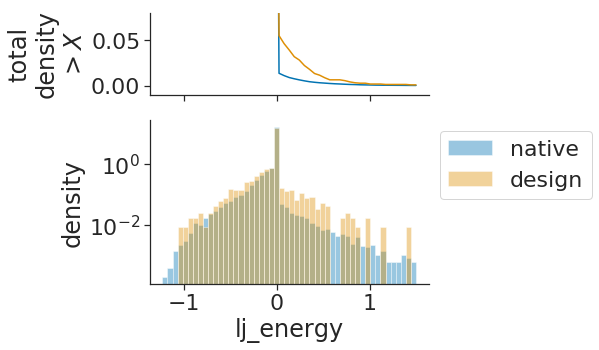

In [93]:
data = per_atom_rep_df.copy()
upper_lim = 1.5
print(f"Clipping {metric} at an upper limit of {upper_lim}")
data[metric] = data[metric].clip(upper=upper_lim)

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'native', 'design']
}
min_range = data[metric].min()
max_range = data[metric].max()
nbins = 50
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
for bin_min in bins:
    cd_dict[metric].append(bin_min)
    for native_or_design in ['native', 'design']:
        cd = sum(
            (data['native_or_design'] == native_or_design) &
            (data[metric] > bin_min)
        ) / sum(data['native_or_design'] == native_or_design)
        cd_dict[native_or_design].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot the data
(fig, axs) = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 2]},
    figsize=[5,5]
)

# ... first plotting the cumulative density
for native_or_design in ['native', 'design']:
    sns.lineplot(
        x=metric, y=native_or_design, data=cd_df,
        label=native_or_design, ax=axs[0]
    )
axs[0].set(ylim=[-0.01, 0.08], ylabel='total\ndensity\n$>X$')
axs[0].get_legend().remove()

# ... and then the density
for native_or_design in ['native', 'design']:
    data_i = data[data['native_or_design'] == native_or_design]
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label=native_or_design, bins=bins, ax=axs[1]
    )
axs[1].set(ylabel='density', yscale='log')

plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

In [97]:
per_atom_rep_df[
    per_atom_rep_df['native_or_design'] == 'design'
].sort_values(metric, ascending=False).head(n=10)

,res_atom_id,lj_energy,native_or_design
69616,21_12_HHH_rd4_0216_wt,1.958915,design
28539,35_12_HHH_rd4_0068_wt,1.536728,design
61958,35_12_HHH_rd4_0216_wt,1.436473,design
34824,11_11_HHH_rd4_0216_wt,1.165419,design
5392,21_14_HHH_rd4_0068_wt,0.979274,design
20247,9_14_HHH_rd4_0636_wt,0.957806,design
52140,25_15_HHH_rd4_0284_wt,0.852073,design
9751,40_14_EEHEE_rd4_0215_wt,0.807193,design
16579,25_12_HHH_rd4_0068_wt,0.790974,design
69429,13_15_HHH_rd4_0284_wt,0.789360,design


In [131]:
res_atom_id = '13_16_1bkr_clean_0001'
energies_df[
    (
        (energies_df['res_atom_i_id'] == res_atom_id) |
        (energies_df['res_atom_j_id'] == res_atom_id)
    ) &
    (energies_df['lj_rep'] > 0) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    ~(energies_df['atom_j_name'].isin(['N', 'C', 'CA', 'H', 'HA', 'O']))
].sort_values('lj_rep', ascending=False)[cols]

,pdb,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,lj_rep,lj_atr,lj_energy,d,o
66626,1bkr_clean_0001,9,LEU,HG,13,MET,2HE,1.390844,-0.021808,1.369036,1.971420,2.842544
58471,1bkr_clean_0001,9,LEU,CG,13,MET,2HE,0.066257,-0.036961,0.029296,2.979725,3.433032


In [56]:
df = energies_df[
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['lj_rep'] > 0) &
    (energies_df['atom_i_type_name'].str.contains('Hapo')) &
    (energies_df['atom_j_type_name'].str.contains('Hapo')) &
    ~(energies_df['atom_j_name'].isin(['N', 'C', 'CA', 'H', 'HA', 'O']))
].copy()
df.drop_duplicates('pair_id', inplace=True, keep='first')
cols = [
    'pdb',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'lj_rep', 'lj_atr', 'lj_energy', 'd', 'o'
]
df.sort_values('lj_rep', ascending=False, inplace=True)
df[cols].head(n=10)

,pdb,res_i_n,res_i_name,atom_i_name,res_j_n,res_j_name,atom_j_name,lj_rep,lj_atr,lj_energy,d,o
1080,1b9o_clean_0001.pdb,59,LEU,2HD1,70,ARG,1HB,2.749304,-0.021808,2.727496,1.872756,2.842544
212,1bkr_clean_0001.pdb,9,LEU,HG,13,MET,2HE,1.390844,-0.021808,1.369036,1.971420,2.842544
1932,1c7k_clean_0001.pdb,2,VAL,1HG2,132,GLY,1HA,1.265766,-0.021808,1.243958,1.985190,2.842544
289,1bq8_clean_0001.pdb,24,ILE,HB,19,ASP,2HB,1.100061,-0.021808,1.078253,2.005729,2.842544
897,1bkr_clean_0001.pdb,34,MET,2HG,55,LYS,1HG,1.047675,-0.021808,1.025867,2.012880,2.842544
517,1c7k_clean_0001.pdb,4,VAL,HB,34,LEU,3HD2,0.885644,-0.021808,0.863836,2.037525,2.842544
119,1c7k_clean_0001.pdb,18,ILE,1HG2,8,PRO,2HB,0.601004,-0.021808,0.579196,2.094424,2.842544
1531,1c7k_clean_0001.pdb,91,LEU,2HB,103,MET,2HG,0.591495,-0.021808,0.569687,2.096762,2.842544
179,1bkr_clean_0001.pdb,23,ILE,3HD1,11,CYS,2HB,0.501269,-0.021808,0.479461,2.120997,2.842544
361,1bkr_clean_0001.pdb,8,LEU,1HD1,23,ILE,2HG2,0.461300,-0.021808,0.439492,2.133140,2.842544


In [65]:
V_j = 25.855000
o_i = 2.011760
o_j = 2.011760
dGf_i = 7.292929 #7.7272
l_i = 3.5
o_ij = o_i + o_j
d_ij = 4.236559

desolv = \
    -V_j * dGf_i / (
        (2 * math.pow(math.pi, 3/2) * l_i * math.pow(o_i, 2))
    ) * math.exp(-math.pow(((d_ij - o_ij)/l_i), 2))

desolv

-1.190864372325896

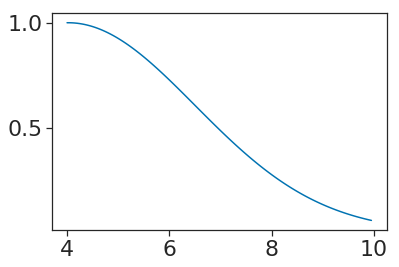

In [62]:
def compute_dist_dependence(d_ij, o_ij, l_i):
    return math.exp(-math.pow(((d_ij - o_ij)/l_i), 2))

o_i = 2.011760
o_j = 2.011760
l_i = 3.5
o_ij = o_i + o_j
xs = np.arange(4, 10, 0.05)
ys = [
    compute_dist_dependence(x, o_ij, l_i)
    for x in xs
]
sns.lineplot(xs, ys)
plt.show()

Kinds of clashes:
* sidechain - backbone between adjacent residues
    * 0216, 0284
    * general observations:
        * Some of this still present with rescue mutations
            * 0216 I21A: 21 CB -- 22 N
* sidechain - backbone between residues of distance > 1
    * 0216: I21 2HG1 -- S17 O; I21 2HD1 -- E18 HA
    * 0628 and 0284: V21 3HG2 -- N17 O
    * 0636: V12 3HG2 -- K8 O 

* sidechain - sidechain    
    * 0216: V11 CG1/1HG1/CG2/1HG2 -- I21 1HG1
    * 0636
    * 0284: both gamma carbons have at least one hydrogen clashing with other side-chain and backbone atoms
    
* "Multiple hit" hypothesis
    * 0216 I21
        * Hs from CG1 are clashing with >5 unique atoms
        * H from CD clashing with backbone of distant residue
        * CB clashing with backbone of adjacent residue
    * 0216 V11
        * Many clashes spanning multiple Hs and Cs of side chain
        * V11, I21, L25, I35 form a network of clashing residues
    * 0636 V12
        * Multiple
    * 0284
        * A9, V21, L25, I35, I38, L39 form a network of clashing residues

Questions for Frank
* how does Rosetta handle:
    * clashing w/ backbone of same residue
    * clashing w/ backbone of adjacent residues
    * clashing w/ backbone of residue of distance > 1
* quantify pairwise distances in native structures?
    * do for different kinds of atom pairs:
        * sc-sc between aliphatic hydrophobics
        * sc-bb between aliphatic hydrophobic and bb (adjacent and not)
* why not include hydrogens in fa_sol?
* scan LJ radii? Focus on aliphatic hydrogens?
    * split into different groups based on proximity to polar atoms? Sort of like different groups of carbons?
        * HA is considered a Hapo -> make it its own group?
* does Nao's model pick up on problematic sites?
    * maybe it predicts that the geometries are bad and would lead to clashes

Hypotheses:
* Single clash that is really bad
    * how test: quantify individual clashes
* Multiple clashes that compound
    * makes it much harder for clashes to be resolved by wiggling things around
    * how test: quantify the joint effects of multiple clashes
        * at level of single atoms
        * at level of whole residue

## General observations on designs

**HHH_rd4_0284**

* K6 to hydrophobics, and almost anything else
    * Clearly would add hydrophobic packing at boundary/core
* R7 to A, S, T, Q, and almost anything else
    * Gabe thinks S/T mutations might dirupt helix, let it bend
    * but broad ability of many mutations to rescue indicate R is somehow uniquely destabilizing, maybe due to unfavorable electrostatics with nearby positive charges or helical dipole. Though K is somewhat rescuing, which would argue against this, though it's possible the K effect is due to noise
* A9 to I, L, M
    * interesting because it seems like these would clash in context of current structure
* V21 to A, G
    * These mutations might relieve clashing. It looks to me like V21 clashes with the V13 backbone atoms. So maybe that's another reason that V13A doesn't help. And the backbone is already contorted in that region, already leaning out of the way, so maybe it's unlikely it would be able to adjust more.

* Gabe showed that there is a higher level of clashing in 0284 compared with 0626. Specifically, he quantified fa_rep for each residue, and showed that a handful of residues had high values, and that these values were higher in 0284 than 0626.

* Something that is interesting is that although there are many sequence differences between 0284 and 0626, mutations that convert between the two often have no effect or small effects. So it is not as simple as "reverting" to the sequence of the stable design, which is something that I might have predicted going in. Instead, some rescuing mutations happen at sites that are identical between the two. Or at sites where the sequences are non-identical, rescuing mutations are often to amino acids that differ from the stable design. So it seems like the effects are probably more complex and background dependent. I wonder if we'll see the same trend with other proteins.

EEHEE_rd4_0215


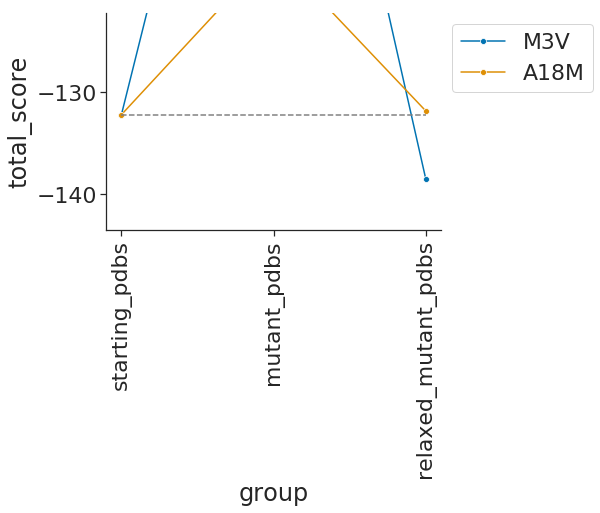

In [101]:
parent = 'HHH_rd4_0284'
mutations = ['V21A', 'V21G', 'K6L']

parent = 'HHH_rd4_0636'
mutations = ['V12A', 'K6L']

parent = 'HHH_rd4_0216'
mutations = ['K8L', 'V11A', 'V11G', 'I21A', 'I21G']

parent = 'HHH_rd4_0628'
mutations = ['K6L', 'A9L', 'E18L', 'V21A']

parent = 'HHH_rd4_0838'
mutations = ['K6L', 'K6I', 'E18L', 'E18I']

parent = 'EEHEE_rd4_0215'
mutations = ['M3V', 'A18M']

print(parent)
parent_val = list(scores_df[
    (scores_df['parent'] == parent) &
    (scores_df['group'] == 'starting_pdbs')
]['total_score'])
assert len(parent_val) == 1
parent_val = parent_val[0]

mins = []
for mutation in mutations:

    data = scores_df[
        (scores_df['parent'] == parent) &
        (
            (scores_df['mutation'] == mutation) |
            (scores_df['group'] == 'starting_pdbs')
        )
    ]

    order_dict = {
        'starting_pdbs' : 1,
        'mutant_pdbs' : 2,
        'relaxed_mutant_pdbs' : 3
    }
    data['order'] = data['group'].apply(lambda x: order_dict[x])
    data.sort_values('order', ascending=True, inplace=True)

    sns.lineplot(
        x='group', y='total_score', data=data, sort=False, marker='o',
        label=mutation
    )
    mins.append(data['total_score'].min())
plt.ylim([min(mins)-5, parent_val+10])
plt.plot([0,2], [parent_val, parent_val], ls='--', c='0.5')
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

**Observations**:
* V -> A/G
    * higher then lower:
        * HHH_rd4_0284 V21A V21G
    * higher:
        * HHH_rd4_0636
    
    
* charged -> hydrophobic
    * higher:
        * HHH_rd4_0216 K8L
        * HHH_rd4_0838 K6I, E18L
    * equal:
        * HHH_rd4_0284 K6L
    * lower:
        * HHH_rd4_0636 K6L
        * HHH_rd4_0628 K6L

In [52]:
pdbs = [
    'data/starting_pdbs/HHH_rd4_0626.pdb',
    'results/starting_pdbs/torsion_relax/HHH_rd4_0626_0001.pdb',
    'data/starting_pdbs/HHH_rd4_0284.pdb',
    'results/starting_pdbs/torsion_relax/HHH_rd4_0284_0001.pdb',
    'results/mutant_pdbs/HHH_rd4_0284_V21A.pdb',
    'results/mutant_pdbs/torsion_relax/HHH_rd4_0284_V21A_0001.pdb',
    'results/mutant_pdbs/HHH_rd4_0284_K6L.pdb',
    'results/mutant_pdbs/torsion_relax/HHH_rd4_0284_K6L_0001.pdb'
]

if True:
    pdbs = [
        'data/starting_pdbs/HHH_rd4_0216.pdb',
        'results/mutant_pdbs/HHH_rd4_0216_K8L.pdb',
        'results/mutant_pdbs/HHH_rd4_0216_V11A.pdb',
        'results/mutant_pdbs/HHH_rd4_0216_V11G.pdb',
        'results/mutant_pdbs/HHH_rd4_0216_I21A.pdb',
        'results/starting_pdbs/torsion_relax/HHH_rd4_0216_0001.pdb',
        'results/mutant_pdbs/torsion_relax/HHH_rd4_0216_K8L_0001.pdb',
        'results/mutant_pdbs/torsion_relax/HHH_rd4_0216_V11A_0001.pdb',
        'results/mutant_pdbs/torsion_relax/HHH_rd4_0216_V11G_0001.pdb',
        'results/mutant_pdbs/torsion_relax/HHH_rd4_0216_I21A_0001.pdb'
    ]

for pdb in pdbs:
    pose = pyrosetta.pose_from_pdb(pdb)
    print(pose.sequence(), sf(pose))# / pose.size())

LERAERIKREVERKQLSEKQIEDLLRRAGVDERIIEKILRELS -118.22858764606296
LERAERILREVERKQLSEKQIEDLLRRAGVDERIIEKILRELS -113.1812942239517
LERAERIKREAERKQLSEKQIEDLLRRAGVDERIIEKILRELS -115.93362815356501
LERAERIKREGERKQLSEKQIEDLLRRAGVDERIIEKILRELS -112.49116909170264
LERAERIKREVERKQLSEKQAEDLLRRAGVDERIIEKILRELS -113.19719271274542
LERAERIKREVERKQLSEKQIEDLLRRAGVDERIIEKILRELS -126.77093836532306
LERAERILREVERKQLSEKQIEDLLRRAGVDERIIEKILRELS -125.81240156899217
LERAERIKREAERKQLSEKQIEDLLRRAGVDERIIEKILRELS -129.49743956729503
LERAERIKREGERKQLSEKQIEDLLRRAGVDERIIEKILRELS -127.28155066724345
LERAERIKREVERKQLSEKQAEDLLRRAGVDERIIEKILRELS -130.4902455141348


In [76]:
# Forward fold each design and each mutant variant
dfs = []
for pdb_name in pdb_names:

    # Make a list of sequences to forward fold
    seqs_for_ff = {
        key : []
        for key in ['seq_name', 'seq']
    }
    pose = pyrosetta.pose_from_pdb(
        os.path.join(pdb_dir, '{0}.pdb'.format(pdb_name))
    )
    seq = pose.sequence()

    # ... first adding the wildtype sequence
    seqs_for_ff['seq_name'].append('{0}_wt'.format(pdb_name))
    seqs_for_ff['seq'].append(seq)

    # ... then adding mutant sequences
    if pdb_name in mutations_dict:
        for (wt_aa, site_n, mut_aa) in mutations_dict[pdb_name]:
            mut_seq = design_utils.mutate_protein_sequence(
                seq, site_n, wt_aa, mut_aa
            )
            seqs_for_ff['seq_name'].append(
                '{0}_{1}{2}{3}'.format(pdb_name, wt_aa, site_n, mut_aa)
            )
            seqs_for_ff['seq'].append(mut_seq)
    seqs_for_ff_df = pandas.DataFrame(seqs_for_ff)
    dfs.append(seqs_for_ff_df)
    
    # Fold each sequence in the above dataframe
    for (i, row) in seqs_for_ff_df.iterrows():

        # Define an output directory for storing results.
        # Do not forward fold sequences if this directory already
        # exists
        seq = row['seq']
        seq_name = row['seq_name']
        forward_folding_dir = os.path.join(
            resultsdir,
            'forward_folding_from_seq/',
            seq_name + '/'
        )
        if os.path.isdir(forward_folding_dir):
            continue
        
        # Make a FASTA file for use as input for forward folding
        fasta_dir = os.path.join(forward_folding_dir, 'fasta/')
        if not os.path.isdir(fasta_dir):
            os.makedirs(fasta_dir)
        fasta_file = os.path.join(
            fasta_dir, '{0}.fasta'.format(seq_name)
        )
        if not os.path.isfile(fasta_file):
            with open(fasta_file, 'w') as f:
                f.write('>{0}\n'.format(seq_name))
                f.write('{0}\n'.format(seq))
  
        # Forward fold the designs
        boinc_id_prefix = 'HH_2019_'
        design_utils.forward_fold_designs_from_sequence_on_boinc(
            fastas_folder=fasta_dir,
            forward_folding_dir=forward_folding_dir,
            setup_boinc_alone_script=setup_boinc_alone_script,
            boinc_id_prefix=boinc_id_prefix,
            run_jobs=True
        )
        
seqs_for_ff_df = pandas.concat(dfs)

In [14]:
# Make a list of designs
output_dir = os.path.join(
    resultsdir,
    'atom_pair_energies',
    'abinitio_minima'
)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
designs = [
    'HHH_rd4_0216_wt',
    'HHH_rd4_0284_wt',
    'HHH_rd4_0636_wt',
    'HHH_rd4_0628_wt',
    'HHH_rd4_0068_wt',
    'EEHEE_rd4_0215_wt'
]
for design in designs:
    pdb_file = glob.glob(os.path.join(
        'results/abinitio_minima',
        design,
        '*.pdb'
    ))[0]
    pdb_basename = os.path.basename(pdb_file).replace('.pdb', '')
    output_file = os.path.join(output_dir, f'{design}.csv')
    if os.path.isfile(output_file):
        continue
    print(design)
    df_exists = False
    pose = pyrosetta.pose_from_pdb(pdb_file)
    for res_i_n in range(1, pose.size()+1):
        res_i = pose.residue(res_i_n)
        res_i_name = res_i.name3()
        if res_i_name not in ['VAL', 'LEU', 'ILE', 'ALA', 'MET']:
            continue
        for atom_i_n in list(range(1, res_i.natoms()+1)):
            atom_i_name = res_i.atom_name(atom_i_n)
            if atom_i_name.strip() in ['N', 'C', 'CA', 'H', 'HA', 'O']:
                continue
            df = compute_pairwise_energies(pose, res_i_n, atom_i_n, sf)
            df['pdb'] = design
            if not df_exists:
                energies_df = df.copy()
                df_exists = True
            else:
                energies_df = \
                    pandas.concat([energies_df, df], sort=False)
    energies_df['pair_id'] = energies_df.apply(
        lambda row: '_'.join(sorted([
            row['pdb'],
            "{0}_{1}".format(row['res_i_n'], row['atom_i_n']),
            "{0}_{1}".format(row['res_j_n'], row['atom_j_n']),
        ])),
        axis=1
    )
    energies_df.to_csv(output_file, index=False)

In [15]:
# Make a list of designs
output_dir = os.path.join(
    resultsdir,
    'atom_pair_energies',
    'cart_min'
)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
designs = [
    'HHH_rd4_0216_wt',
    'HHH_rd4_0284_wt',
    'HHH_rd4_0636_wt',
    'HHH_rd4_0628_wt',
    'HHH_rd4_0068_wt',
    'EEHEE_rd4_0215_wt'
]
for design in designs:
    pdb_file = glob.glob(os.path.join(
        'results/lowest_energy_decoys/beta16.nostab-refit/',
        design,
        '*.pdb'
    ))[0]
    pdb_basename = os.path.basename(pdb_file).replace('.pdb', '')
    output_file = os.path.join(output_dir, f'{design}.csv')
    if os.path.isfile(output_file):
        continue
    print(design)
    df_exists = False
    pose = pyrosetta.pose_from_pdb(pdb_file)
    for res_i_n in range(1, pose.size()+1):
        res_i = pose.residue(res_i_n)
        res_i_name = res_i.name3()
        if res_i_name not in ['VAL', 'LEU', 'ILE', 'ALA', 'MET']:
            continue
        for atom_i_n in list(range(1, res_i.natoms()+1)):
            atom_i_name = res_i.atom_name(atom_i_n)
            if atom_i_name.strip() in ['N', 'C', 'CA', 'H', 'HA', 'O']:
                continue
            df = compute_pairwise_energies(pose, res_i_n, atom_i_n, sf)
            df['pdb'] = design
            if not df_exists:
                energies_df = df.copy()
                df_exists = True
            else:
                energies_df = \
                    pandas.concat([energies_df, df], sort=False)
    energies_df['pair_id'] = energies_df.apply(
        lambda row: '_'.join(sorted([
            row['pdb'],
            "{0}_{1}".format(row['res_i_n'], row['atom_i_n']),
            "{0}_{1}".format(row['res_j_n'], row['atom_j_n']),
        ])),
        axis=1
    )
    energies_df.to_csv(output_file, index=False)

In [16]:
# Make a list of natives
output_dir = os.path.join(
    resultsdir,
    'atom_pair_energies'
)
pdb_dir = '/home/dimaio/optE2/dualoptE/decoys/xtal_refine/'
pdbs = sorted(glob.glob(os.path.join(pdb_dir, '*.pdb')))
for pdb_file in pdbs:
    pdb_basename = os.path.basename(pdb_file).replace('.pdb', '')
    output_file = os.path.join(output_dir, f'{pdb_basename}.csv')
    if os.path.isfile(output_file):
        continue
    print(pdb_basename)
    df_exists = False
    pose = pyrosetta.pose_from_pdb(pdb_file)
    for res_i_n in range(1, pose.size()+1):
        res_i = pose.residue(res_i_n)
        res_i_name = res_i.name3()
        if res_i_name not in ['VAL', 'LEU', 'ILE', 'ALA', 'MET']:
            continue
        for atom_i_n in list(range(1, res_i.natoms()+1)):
            atom_i_name = res_i.atom_name(atom_i_n)
            if atom_i_name.strip() in ['N', 'C', 'CA', 'H', 'HA', 'O']:
                continue
            df = compute_pairwise_energies(pose, res_i_n, atom_i_n, sf)
            df['pdb'] = pdb_basename
            if not df_exists:
                energies_df = df.copy()
                df_exists = True
            else:
                energies_df = \
                    pandas.concat([energies_df, df], sort=False)
    energies_df['pair_id'] = energies_df.apply(
        lambda row: '_'.join(sorted([
            row['pdb'],
            "{0}_{1}".format(row['res_i_n'], row['atom_i_n']),
            "{0}_{1}".format(row['res_j_n'], row['atom_j_n']),
        ])),
        axis=1
    )
    energies_df.to_csv(output_file, index=False)

In [18]:
dfs = []
energies_files = glob.glob(os.path.join(
    resultsdir,
    'atom_pair_energies',
    '*.csv'
))
energies_files += glob.glob(os.path.join(
    resultsdir,
    'atom_pair_energies',
    'cart_min',
    '*.csv'
))
aas = ['VAL', 'LEU', 'ILE', 'ALA', 'MET']
for energies_file in energies_files:
    df = pandas.read_csv(energies_file)
    df = df[
        (df['d'] < 6) &
        (df['res_i_n'] != df['res_j_n']) #&
        #(df['res_i_name'].isin(aas)) &
        #(df['res_j_name'].isin(aas)) &
        #~(df['atom_j_name'].isin(['N', 'C', 'CA', 'H', 'HA', 'O']))
    ]
    energies_file_basename = \
        os.path.basename(energies_file).replace('.csv', '')
    df['pdb_name'] = energies_file_basename
    if '_clean_' in energies_file_basename:
        protein_group = 'natives'
    elif '_wt' in energies_file_basename:
        protein_group = 'unstable_designs'
    else:
        protein_group = 'rescued_designs'
    df['protein_group'] = protein_group
    dfs.append(df)
energies_df = pandas.concat(dfs, sort=False)
energies_df.drop_duplicates('pair_id', inplace=True, keep='first')
energies_df['d-o'] = energies_df['d'] - energies_df['o']
#energies_df['native_or_design'] = energies_df['pdb'].apply(
#    lambda x: 'native' if '_clean_' in x else 'design'
#)
energies_df['seq_dist'] = \
    energies_df['res_i_n'] - energies_df['res_j_n']
energies_df['seq_dist'] = energies_df['seq_dist'].abs()